In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb

In [2]:
# Importing datasets
train_data = pd.read_csv("data/Train.csv")
test_data = pd.read_csv("data/Test.csv")
#train_dummy = pd.get_dummies(train_data.drop(['uniqueid'], axis=1))
#test_dummy = pd.get_dummies(test_data.drop(['uniqueid'], axis=1))

In [3]:
# Merging the train and test data
ntrain = train_data.shape[0] 
ntest = test_data.shape[0]
dataset = pd.concat((train_data, test_data), sort=False).reset_index(drop=True)
dataset['year'].unique()
dataset.year.unique()

array([2018, 2016, 2017], dtype=int64)

# VISUALIZATION

In [4]:
dataset.head()

country  year    uniqueid bank_account location_type cellphone_access  \
0   Kenya  2018  uniqueid_1          Yes         Rural              Yes   
1   Kenya  2018  uniqueid_2           No         Rural               No   
2   Kenya  2018  uniqueid_3          Yes         Urban              Yes   
3   Kenya  2018  uniqueid_4           No         Rural              Yes   
4   Kenya  2018  uniqueid_5           No         Urban               No   

   household_size  age_of_respondent gender_of_respondent  \
0               3                 24               Female   
1               5                 70               Female   
2               5                 26                 Male   
3               5                 34               Female   
4               8                 26                 Male   

  relationship_with_head           marital_status  \
0                 Spouse  Married/Living together   
1      Head of Household                  Widowed   
2         Other relative     Single/Never Married   
3      Head of Household  Married/Living together   
4                  Child     Single/Never Married   

                   education_level                   job_type  
0              Secondary education              Self employed  
1              No formal education       Government Dependent  
2  Vocational/Specialised training              Self employed  
3                Primary education  Formally employed Private  
4                Primary education        Informally employed

In [5]:
dataset.country.unique()

array(['Kenya', 'Rwanda', 'Tanzania', 'Uganda'], dtype=object)

In [6]:
dataset.age_of_respondent.max()

100

In [7]:
dataset.age_of_respondent.min()

16

In [8]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
gender_count = dataset['gender_of_respondent'].value_counts()
sns.set(style="darkgrid")
sns.barplot(gender_count.index, gender_count.values, alpha=0.9)
plt.title('Frequency Distribution of Gender')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.show()

C:\Users\Elijah Nkuah\.conda\envs\Elijah\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [9]:
y_train = train_data.bank_account.values
y_train.shape

(23524,)

C:\Users\Elijah Nkuah\.conda\envs\Elijah\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


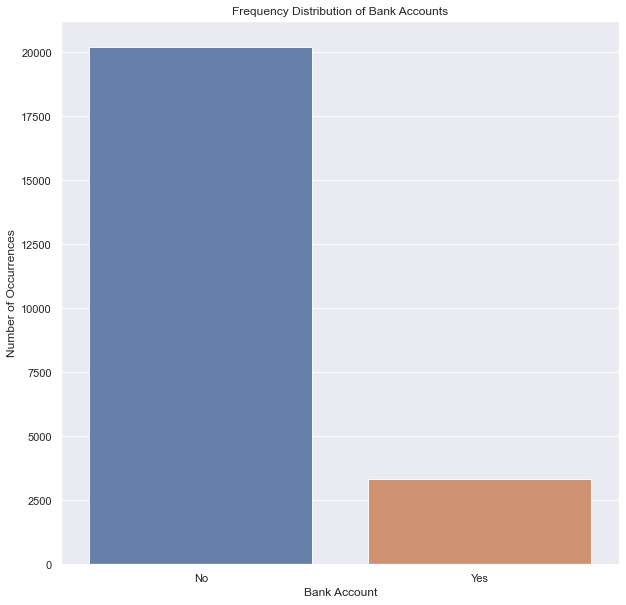

In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
bank_account_count = train_data['bank_account'].value_counts()
sns.set(style="darkgrid")
sns.barplot(bank_account_count.index, bank_account_count.values, alpha=0.9)
plt.title('Frequency Distribution of Bank Accounts')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Bank Account', fontsize=12)
plt.show()

In [11]:
train_data['bank_account'].value_counts()

No     20212
Yes     3312
Name: bank_account, dtype: int64

<AxesSubplot:xlabel='marital_status', ylabel='count'>

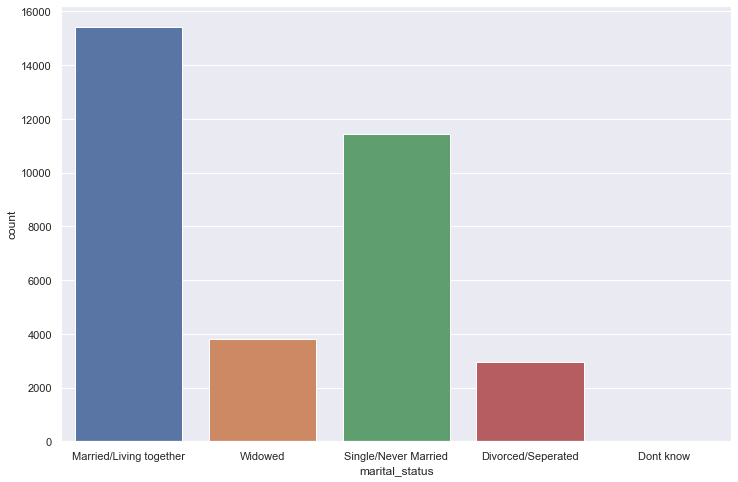

In [12]:
plt.figure(figsize = [12,8])
sns.countplot(x = 'marital_status', data = dataset)

C:\Users\Elijah Nkuah\.conda\envs\Elijah\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


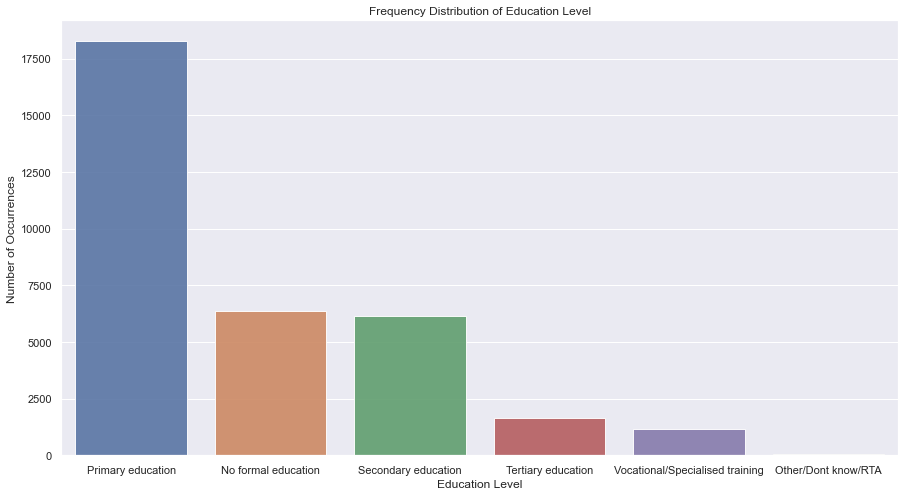

In [13]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
education_level_count = dataset['education_level'].value_counts()
sns.set(style="darkgrid")
sns.barplot(education_level_count.index, education_level_count.values, alpha=0.9)
plt.title('Frequency Distribution of Education Level')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Education Level', fontsize=12)
plt.show()

In [14]:
dataset['education_level'].value_counts()

Primary education                  18270
No formal education                 6351
Secondary education                 6125
Tertiary education                  1649
Vocational/Specialised training     1162
Other/Dont know/RTA                   53
Name: education_level, dtype: int64

# futher Analysis can be done in excel pivot table. comparing education levels to bank account created

<AxesSubplot:>

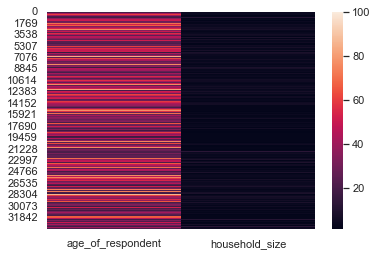

In [15]:
sns.heatmap(dataset[['age_of_respondent','household_size']])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='age_of_respondent', ylabel='household_size'>

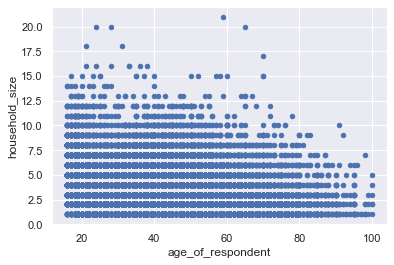

In [16]:
dataset[['age_of_respondent','household_size']].plot.scatter(x = 'age_of_respondent',y = 'household_size')

In [17]:
#Pie Chart
labels = dataset['education_level'].astype('category').cat.categories.tolist()
counts = dataset['education_level'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

In [18]:
dataset.head()
#dataset = dataset.drop(['bank_account'], axis=1)
dataset.education_level.unique()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33610 entries, 0 to 33609
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 33610 non-null  object
 1   year                    33610 non-null  int64 
 2   uniqueid                33610 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           33610 non-null  object
 5   cellphone_access        33610 non-null  object
 6   household_size          33610 non-null  int64 
 7   age_of_respondent       33610 non-null  int64 
 8   gender_of_respondent    33610 non-null  object
 9   relationship_with_head  33610 non-null  object
 10  marital_status          33610 non-null  object
 11  education_level         33610 non-null  object
 12  job_type                33610 non-null  object
dtypes: int64(3), object(10)
memory usage: 3.3+ MB


In [19]:
#dataset.head()

## Replacing some binary response with 1 or 0
##### There will be another model that will use encoder instead of replacing method

In [20]:
#train_data['bank_account'] = train_data['bank_account'].str.replace('Yes','1')
#train_data['bank_account'] = train_data['bank_account'].str.replace('No','0')
y_train = train_data.bank_account.values

In [21]:
y_train.shape

(23524,)

In [22]:
#dataset['cellphone_access'] = dataset['cellphone_access'].str.replace('Yes','1')
#dataset['cellphone_access'] = dataset['cellphone_access'].str.replace('No','0')
#dataset['gender_of_respondent'] = dataset['gender_of_respondent'].str.replace('Male','1')
#dataset['gender_of_respondent'] = dataset['gender_of_respondent'].str.replace('Female','0')
#dataset['year'] = dataset['year'].replace(2018,1)
#dataset['year'] = dataset['year'].replace(2017,2)
#dataset['year'] = dataset['year'].replace(2016,3)


dataset.head()

country  year    uniqueid bank_account location_type cellphone_access  \
0   Kenya  2018  uniqueid_1          Yes         Rural              Yes   
1   Kenya  2018  uniqueid_2           No         Rural               No   
2   Kenya  2018  uniqueid_3          Yes         Urban              Yes   
3   Kenya  2018  uniqueid_4           No         Rural              Yes   
4   Kenya  2018  uniqueid_5           No         Urban               No   

   household_size  age_of_respondent gender_of_respondent  \
0               3                 24               Female   
1               5                 70               Female   
2               5                 26                 Male   
3               5                 34               Female   
4               8                 26                 Male   

  relationship_with_head           marital_status  \
0                 Spouse  Married/Living together   
1      Head of Household                  Widowed   
2         Other relative     Single/Never Married   
3      Head of Household  Married/Living together   
4                  Child     Single/Never Married   

                   education_level                   job_type  
0              Secondary education              Self employed  
1              No formal education       Government Dependent  
2  Vocational/Specialised training              Self employed  
3                Primary education  Formally employed Private  
4                Primary education        Informally employed

In [23]:
dataset = dataset.drop(['uniqueid'], axis=1)

In [24]:
dataset.head()

country  year bank_account location_type cellphone_access  household_size  \
0   Kenya  2018          Yes         Rural              Yes               3   
1   Kenya  2018           No         Rural               No               5   
2   Kenya  2018          Yes         Urban              Yes               5   
3   Kenya  2018           No         Rural              Yes               5   
4   Kenya  2018           No         Urban               No               8   

   age_of_respondent gender_of_respondent relationship_with_head  \
0                 24               Female                 Spouse   
1                 70               Female      Head of Household   
2                 26                 Male         Other relative   
3                 34               Female      Head of Household   
4                 26                 Male                  Child   

            marital_status                  education_level  \
0  Married/Living together              Secondary education   
1                  Widowed              No formal education   
2     Single/Never Married  Vocational/Specialised training   
3  Married/Living together                Primary education   
4     Single/Never Married                Primary education   

                    job_type  
0              Self employed  
1       Government Dependent  
2              Self employed  
3  Formally employed Private  
4        Informally employed

In [25]:
dataset = dataset.drop(['bank_account'], axis=1)

In [26]:
#data = pd.get_dummies(dataset)
#data_1 = data #For checking distributions
data = dataset
data.shape

(33610, 11)

In [33]:
data.head()

country  year location_type cellphone_access  household_size  \
0   Kenya  2018         Rural              Yes               3   
1   Kenya  2018         Rural               No               5   
2   Kenya  2018         Urban              Yes               5   
3   Kenya  2018         Rural              Yes               5   
4   Kenya  2018         Urban               No               8   

   age_of_respondent gender_of_respondent relationship_with_head  \
0                 24               Female                 Spouse   
1                 70               Female      Head of Household   
2                 26                 Male         Other relative   
3                 34               Female      Head of Household   
4                 26                 Male                  Child   

            marital_status                  education_level  \
0  Married/Living together              Secondary education   
1                  Widowed              No formal education   
2     Single/Never Married  Vocational/Specialised training   
3  Married/Living together                Primary education   
4     Single/Never Married                Primary education   

                    job_type  
0              Self employed  
1       Government Dependent  
2              Self employed  
3  Formally employed Private  
4        Informally employed

In [34]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
LE = LabelEncoder()

In [35]:
data.head()

country  year location_type cellphone_access  household_size  \
0   Kenya  2018         Rural              Yes               3   
1   Kenya  2018         Rural               No               5   
2   Kenya  2018         Urban              Yes               5   
3   Kenya  2018         Rural              Yes               5   
4   Kenya  2018         Urban               No               8   

   age_of_respondent gender_of_respondent relationship_with_head  \
0                 24               Female                 Spouse   
1                 70               Female      Head of Household   
2                 26                 Male         Other relative   
3                 34               Female      Head of Household   
4                 26                 Male                  Child   

            marital_status                  education_level  \
0  Married/Living together              Secondary education   
1                  Widowed              No formal education   
2     Single/Never Married  Vocational/Specialised training   
3  Married/Living together                Primary education   
4     Single/Never Married                Primary education   

                    job_type  
0              Self employed  
1       Government Dependent  
2              Self employed  
3  Formally employed Private  
4        Informally employed

In [36]:
y_train = LE.fit_transform(y_train)

In [37]:
y_train

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [38]:
data.isnull().sum()

country                   0
year                      0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

In [39]:
#data.describe()

# SCALLING OF SOME COLUMNS
### Before scaling, the type of distribution must be checked first. This will help you know the scale that must be used

In [40]:
data_mean = np.mean(data[['household_size', 'age_of_respondent']])
data_median_hhsiz = np.median(data['household_size'])
data_median_age = np.median(data['age_of_respondent'])
data_mode = stats.mode(data[['household_size', 'age_of_respondent']])
print("The means for the various columns are: {} ".format(data_mean))
print("The median for the household_size is : {}".format(data_median_hhsiz))
print("The median for the Age_of_respondant is : {}".format(data_median_age))
print("The modes for the various columns are: {}".format(data_mode))

The means for the various columns are: household_size        3.791877
age_of_respondent    38.656114
dtype: float64 
The median for the household_size is : 3.0
The median for the Age_of_respondant is : 35.0
The modes for the various columns are: ModeResult(mode=array([[ 2, 30]], dtype=int64), count=array([[7501, 1499]]))


## Method 1.
### Min - Maximum Scale.
##### formular => Xnew = ((X-Xmin)/(Xmax - Xmin))
This scale is sensitive to outliers and its been used when the data is not Gaussian(Normal distribution)
To check normalisation, mean must be between mode & Median.
From the distribution of the two columns, the mean is greater than the mode and median. this indcates that the data is not Gaussian. 

In [41]:
# Use 3 features
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif
df = SelectKBest(f_classif, k=3)

In [42]:
data.columns

Index(['country', 'year', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')

In [43]:
#data['year'] = df.fit_transform(data, data["year"])
#data['household_size'] = df.fit_transform(data, data['household_size'])
#data['age_of_respondent'] = df.fit_transform(data, data['age_of_respondent'])

#MSB = Mean Square between groups: MSB = SSB/dfB. MSW = Mean Square within groups: f = msb / msw

In [44]:
#from sklearn.preprocessing import MinMaxScaler
#df = MinMaxScaler()
#data[['year','household_size','age_of_respondent']] = df.fit_transform(data[['year','household_size','age_of_respondent']])

In [45]:
data.year.unique()

array([2018, 2016, 2017], dtype=int64)

# 2. Standard Scaler:
### It assumes the data is normal distribution and its centered around 0, with a standard deviation of 1
z = (x - u) / s
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## 3. Max Abs Scaler
#### Scale each feature by its maximum absolute value. This estimator scales and translates each feature individually such that the maximal absolute value of each feature in the training set is 1.0. It does not shift/center the data and thus does not destroy any sparsity.
On positive-only data, this Scaler behaves similarly to Min Max Scaler and, therefore, also suffers from the presence of significant outliers.
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

## 4) Robust Scaler
#### As the name suggests, this Scaler is robust to outliers. If our data contains many outliers, scaling using the mean and standard deviation of the data wonâ€™t work well.
This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). The centering and scaling statistics of this Scaler are based on percentiles and are therefore not influenced by a few numbers of huge marginal outliers. Note that the outliers themselves are still present in the transformed data. If a separate outlier clipping is desirable, a non-linear transformation is required.
##### from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

## 5) Quantile Transformer Scaler
Transform features using quantiles information.
This method transforms the features to follow a uniform or a normal distribution. Therefore, for a given feature, this transformation tends to spread out the most frequent values. It also reduces the impact of (marginal) outliers: this is, therefore, a robust pre-processing scheme.
The cumulative distribution function of a feature is used to project the original values. Note that this transform is non-linear and may distort linear correlations between variables measured at the same scale but renders variables measured at different scales more directly comparable. This is also sometimes called as Rank scaler.
#### from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer()

## 6) Power Transformer Scaler
The power transformer is a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modeling issues related to the variability of a variable that is unequal across the range (heteroscedasticity) or situations where normality is desired.
The power transform finds the optimal scaling factor in stabilizing variance and minimizing skewness through maximum likelihood estimation. Currently, Sklearn implementation of PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood. Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data.
#### from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method='yeo-johnson')

In [39]:
#pip install rpy2

In [46]:
gender_dict = {"Male":1,"Female":2}
country_dict = {'Kenya':1, 'Rwanda':2, 'Tanzania':3, 'Uganda':4}
year_dict = {'2018':1, '2017':2, '2016':3}
feature_dict = {"No":0,"Yes":1}
location_dict = {'Rural':1, 'Urban':2}
relationship_dict = {'Head of Household':1, 'Spouse':2, 'Child':3, 'Parent':4, 'Other relative':5, 'Other non-relatives':6}
marital_dict = {'Married/Living together':1, 'Single/Never Married':2, 'Widowed':3,'Divorced/Seperated':4, 'Dont know':5}
education_dict = {'No formal education':0,'Primary education':1,'Secondary education':2,'Vocational/Specialised training':3,
                  'Tertiary education':4, 'Other/Dont know/RTA':5}
job_dict = {'Dont Know/Refuse to answer':0,'No Income':1,'Other Income':2,'Remittance Dependent':3,'Government Dependent':4,
            'Self employed':5,'Farming and Fishing':6,'Informally employed':7,'Formally employed Private':8, 
       'Formally employed Government':9}

In [47]:
data.columns

Index(['country', 'year', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')

In [48]:
for key, value in data.items():
    data['country']= data.country.replace({'Kenya':1, 'Rwanda':2, 'Tanzania':3, 'Uganda':4})
    data['year'] = data.year.replace({2018:1, 2017:2, 2016:3})
    data['location_type'] = data.location_type.replace({'Rural':1, 'Urban':2})
    data['cellphone_access'] = data.cellphone_access.replace({"No":0,"Yes":1})
    data['gender_of_respondent'] = data.gender_of_respondent.replace({"Male":1,"Female":2})
    data['relationship_with_head'] = data.relationship_with_head.replace({'Head of Household':1, 'Spouse':2, 'Child':3, 'Parent':4, 'Other relative':5, 'Other non-relatives':6})
    data['marital_status'] = data.marital_status.replace({'Married/Living together':1, 'Single/Never Married':2, 'Widowed':3,'Divorced/Seperated':4, 'Dont know':5})
    data['education_level'] = data.education_level.replace({'No formal education':0,'Primary education':1,'Secondary education':2,'Vocational/Specialised training':3,'Tertiary education':4, 'Other/Dont know/RTA':5})
    data['job_type'] = data.job_type.replace({'Dont Know/Refuse to answer':0,'No Income':1,'Other Income':2,'Remittance Dependent':3,'Government Dependent':4,'Self employed':5,'Farming and Fishing':6,'Informally employed':7,'Formally employed Private':8,'Formally employed Government':9})
    

In [49]:
data.head()

country  year  location_type  cellphone_access  household_size  \
0        1     1              1                 1               3   
1        1     1              1                 0               5   
2        1     1              2                 1               5   
3        1     1              1                 1               5   
4        1     1              2                 0               8   

   age_of_respondent  gender_of_respondent  relationship_with_head  \
0                 24                     2                       2   
1                 70                     2                       1   
2                 26                     1                       5   
3                 34                     2                       1   
4                 26                     1                       3   

   marital_status  education_level  job_type  
0               1                2         5  
1               3                0         4  
2               2                3         5  
3               1                1         8  
4               2                1         7

In [50]:
data.dtypes

country                   int64
year                      int64
location_type             int64
cellphone_access          int64
household_size            int64
age_of_respondent         int64
gender_of_respondent      int64
relationship_with_head    int64
marital_status            int64
education_level           int64
job_type                  int64
dtype: object

In [51]:
# Use 3 features
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif
df = SelectKBest(f_classif, k=3)
df1 = StandardScaler()
data_scale = df1.fit_transform(data)

In [52]:
data_df = data_scale
column = data.columns
column

Index(['country', 'year', 'location_type', 'cellphone_access',
       'household_size', 'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'],
      dtype='object')

In [53]:
data_df = pd.DataFrame(data_df, columns=column)
data = data_df
data.head()

country      year  location_type  cellphone_access  household_size  \
0 -1.299498 -1.208569      -0.798096          0.586260       -0.356203   
1 -1.299498 -1.208569      -0.798096         -1.705727        0.543439   
2 -1.299498 -1.208569       1.252982          0.586260        0.543439   
3 -1.299498 -1.208569      -0.798096          0.586260        0.543439   
4 -1.299498 -1.208569       1.252982         -1.705727        1.892903   

   age_of_respondent  gender_of_respondent  relationship_with_head  \
0          -0.891118              0.839056                0.229200   
1           1.905765              0.839056               -0.708983   
2          -0.769514             -1.191815                3.043750   
3          -0.283100              0.839056               -0.708983   
4          -0.769514             -1.191815                1.167384   

   marital_status  education_level  job_type  
0       -0.877715         0.813201 -0.234007  
1        1.234860        -1.261074 -0.803233  
2        0.178573         1.850339 -0.234007  
3       -0.877715        -0.223937  1.473669  
4        0.178573        -0.223937  0.904444

In [54]:
data.shape

(33610, 11)

In [55]:
#Train and test datasets
train = data[:ntrain].copy()
test = data[ntrain:].copy()
test = test.reset_index(drop=True)

In [58]:
 from sklearn.model_selection import GridSearchCV

In [63]:

import catboost as cb
cat_features_index = [0,1,2,3,4,5,6]

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))

params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [300]}
cb = cb.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
cb_model.fit(train, y_train)



#With Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=31, \
                            depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.15)
clf.fit(train,y_train, cat_features= cat_features_index)
auc(clf, train, test)

0:	learn: 0.6636930	total: 191ms	remaining: 57.1s
1:	learn: 0.6352799	total: 205ms	remaining: 30.5s
2:	learn: 0.6098185	total: 213ms	remaining: 21s
3:	learn: 0.5856324	total: 220ms	remaining: 16.3s
4:	learn: 0.5580279	total: 227ms	remaining: 13.4s
5:	learn: 0.5368247	total: 235ms	remaining: 11.5s
6:	learn: 0.5173676	total: 242ms	remaining: 10.1s
7:	learn: 0.4967194	total: 250ms	remaining: 9.12s
8:	learn: 0.4804287	total: 257ms	remaining: 8.32s
9:	learn: 0.4660006	total: 265ms	remaining: 7.69s
10:	learn: 0.4532792	total: 271ms	remaining: 7.13s
11:	learn: 0.4398629	total: 279ms	remaining: 6.69s
12:	learn: 0.4285442	total: 286ms	remaining: 6.32s
13:	learn: 0.4169088	total: 294ms	remaining: 6.01s
14:	learn: 0.4075820	total: 302ms	remaining: 5.75s
15:	learn: 0.3990173	total: 310ms	remaining: 5.5s
16:	learn: 0.3898347	total: 317ms	remaining: 5.28s
17:	learn: 0.3813896	total: 325ms	remaining: 5.09s
18:	learn: 0.3754282	total: 332ms	remaining: 4.9s
19:	learn: 0.3682758	total: 339ms	remaining: 

165:	learn: 0.2428887	total: 1.49s	remaining: 1.2s
166:	learn: 0.2427945	total: 1.5s	remaining: 1.19s
167:	learn: 0.2426950	total: 1.51s	remaining: 1.18s
168:	learn: 0.2425945	total: 1.51s	remaining: 1.17s
169:	learn: 0.2424735	total: 1.52s	remaining: 1.16s
170:	learn: 0.2423844	total: 1.53s	remaining: 1.15s
171:	learn: 0.2423300	total: 1.54s	remaining: 1.14s
172:	learn: 0.2422682	total: 1.55s	remaining: 1.14s
173:	learn: 0.2421275	total: 1.55s	remaining: 1.13s
174:	learn: 0.2420633	total: 1.56s	remaining: 1.12s
175:	learn: 0.2420085	total: 1.57s	remaining: 1.11s
176:	learn: 0.2419434	total: 1.58s	remaining: 1.1s
177:	learn: 0.2419131	total: 1.58s	remaining: 1.09s
178:	learn: 0.2418738	total: 1.59s	remaining: 1.08s
179:	learn: 0.2417958	total: 1.6s	remaining: 1.07s
180:	learn: 0.2417373	total: 1.61s	remaining: 1.06s
181:	learn: 0.2416903	total: 1.61s	remaining: 1.05s
182:	learn: 0.2415910	total: 1.62s	remaining: 1.04s
183:	learn: 0.2414926	total: 1.63s	remaining: 1.03s
184:	learn: 0.24

26:	learn: 0.3609660	total: 207ms	remaining: 2.09s
27:	learn: 0.3571066	total: 215ms	remaining: 2.09s
28:	learn: 0.3537056	total: 223ms	remaining: 2.08s
29:	learn: 0.3503645	total: 229ms	remaining: 2.06s
30:	learn: 0.3472461	total: 237ms	remaining: 2.06s
31:	learn: 0.3436939	total: 245ms	remaining: 2.05s
32:	learn: 0.3417357	total: 252ms	remaining: 2.04s
33:	learn: 0.3397380	total: 259ms	remaining: 2.03s
34:	learn: 0.3377875	total: 268ms	remaining: 2.03s
35:	learn: 0.3357819	total: 274ms	remaining: 2.01s
36:	learn: 0.3336190	total: 283ms	remaining: 2.01s
37:	learn: 0.3310344	total: 290ms	remaining: 2s
38:	learn: 0.3291459	total: 298ms	remaining: 2s
39:	learn: 0.3272527	total: 306ms	remaining: 1.99s
40:	learn: 0.3257977	total: 314ms	remaining: 1.99s
41:	learn: 0.3243947	total: 323ms	remaining: 1.99s
42:	learn: 0.3232023	total: 331ms	remaining: 1.98s
43:	learn: 0.3217923	total: 339ms	remaining: 1.97s
44:	learn: 0.3204880	total: 348ms	remaining: 1.97s
45:	learn: 0.3192236	total: 355ms	rem

186:	learn: 0.2813257	total: 1.47s	remaining: 889ms
187:	learn: 0.2812789	total: 1.48s	remaining: 882ms
188:	learn: 0.2811712	total: 1.49s	remaining: 875ms
189:	learn: 0.2811163	total: 1.49s	remaining: 865ms
190:	learn: 0.2810548	total: 1.5s	remaining: 858ms
191:	learn: 0.2810006	total: 1.51s	remaining: 850ms
192:	learn: 0.2809459	total: 1.52s	remaining: 842ms
193:	learn: 0.2808821	total: 1.52s	remaining: 833ms
194:	learn: 0.2808160	total: 1.53s	remaining: 825ms
195:	learn: 0.2807166	total: 1.54s	remaining: 817ms
196:	learn: 0.2806835	total: 1.55s	remaining: 809ms
197:	learn: 0.2806251	total: 1.55s	remaining: 801ms
198:	learn: 0.2805553	total: 1.56s	remaining: 793ms
199:	learn: 0.2804991	total: 1.57s	remaining: 786ms
200:	learn: 0.2804483	total: 1.58s	remaining: 777ms
201:	learn: 0.2804047	total: 1.59s	remaining: 770ms
202:	learn: 0.2803771	total: 1.59s	remaining: 762ms
203:	learn: 0.2802988	total: 1.6s	remaining: 753ms
204:	learn: 0.2802393	total: 1.61s	remaining: 745ms
205:	learn: 0.

52:	learn: 0.3070079	total: 401ms	remaining: 1.87s
53:	learn: 0.3060737	total: 409ms	remaining: 1.86s
54:	learn: 0.3053143	total: 417ms	remaining: 1.86s
55:	learn: 0.3046128	total: 424ms	remaining: 1.85s
56:	learn: 0.3036702	total: 433ms	remaining: 1.84s
57:	learn: 0.3027545	total: 441ms	remaining: 1.84s
58:	learn: 0.3020503	total: 449ms	remaining: 1.83s
59:	learn: 0.3010700	total: 457ms	remaining: 1.83s
60:	learn: 0.3004568	total: 466ms	remaining: 1.82s
61:	learn: 0.2997208	total: 475ms	remaining: 1.82s
62:	learn: 0.2992167	total: 482ms	remaining: 1.81s
63:	learn: 0.2984424	total: 490ms	remaining: 1.81s
64:	learn: 0.2979215	total: 497ms	remaining: 1.8s
65:	learn: 0.2974651	total: 505ms	remaining: 1.79s
66:	learn: 0.2969918	total: 512ms	remaining: 1.78s
67:	learn: 0.2964744	total: 521ms	remaining: 1.77s
68:	learn: 0.2960826	total: 527ms	remaining: 1.76s
69:	learn: 0.2955320	total: 535ms	remaining: 1.76s
70:	learn: 0.2950827	total: 543ms	remaining: 1.75s
71:	learn: 0.2946609	total: 550m

223:	learn: 0.2739707	total: 1.71s	remaining: 581ms
224:	learn: 0.2739443	total: 1.72s	remaining: 574ms
225:	learn: 0.2739202	total: 1.73s	remaining: 567ms
226:	learn: 0.2738548	total: 1.74s	remaining: 559ms
227:	learn: 0.2738076	total: 1.74s	remaining: 551ms
228:	learn: 0.2737752	total: 1.75s	remaining: 543ms
229:	learn: 0.2737505	total: 1.76s	remaining: 536ms
230:	learn: 0.2737046	total: 1.77s	remaining: 528ms
231:	learn: 0.2736440	total: 1.77s	remaining: 520ms
232:	learn: 0.2736053	total: 1.78s	remaining: 512ms
233:	learn: 0.2735568	total: 1.79s	remaining: 505ms
234:	learn: 0.2735242	total: 1.8s	remaining: 497ms
235:	learn: 0.2735091	total: 1.8s	remaining: 489ms
236:	learn: 0.2734572	total: 1.81s	remaining: 481ms
237:	learn: 0.2733996	total: 1.81s	remaining: 473ms
238:	learn: 0.2733629	total: 1.82s	remaining: 466ms
239:	learn: 0.2733423	total: 1.83s	remaining: 458ms
240:	learn: 0.2733081	total: 1.84s	remaining: 451ms
241:	learn: 0.2732473	total: 1.85s	remaining: 442ms
242:	learn: 0.

85:	learn: 0.2359834	total: 692ms	remaining: 1.72s
86:	learn: 0.2358557	total: 702ms	remaining: 1.72s
87:	learn: 0.2357356	total: 711ms	remaining: 1.71s
88:	learn: 0.2355715	total: 719ms	remaining: 1.7s
89:	learn: 0.2354511	total: 727ms	remaining: 1.7s
90:	learn: 0.2353032	total: 735ms	remaining: 1.69s
91:	learn: 0.2352093	total: 743ms	remaining: 1.68s
92:	learn: 0.2351130	total: 751ms	remaining: 1.67s
93:	learn: 0.2350150	total: 759ms	remaining: 1.66s
94:	learn: 0.2349761	total: 766ms	remaining: 1.65s
95:	learn: 0.2348756	total: 772ms	remaining: 1.64s
96:	learn: 0.2347363	total: 779ms	remaining: 1.63s
97:	learn: 0.2344494	total: 787ms	remaining: 1.62s
98:	learn: 0.2343605	total: 795ms	remaining: 1.61s
99:	learn: 0.2342695	total: 802ms	remaining: 1.6s
100:	learn: 0.2340569	total: 810ms	remaining: 1.6s
101:	learn: 0.2339458	total: 818ms	remaining: 1.59s
102:	learn: 0.2338336	total: 826ms	remaining: 1.58s
103:	learn: 0.2336940	total: 833ms	remaining: 1.57s
104:	learn: 0.2336386	total: 84

248:	learn: 0.2218303	total: 1.98s	remaining: 405ms
249:	learn: 0.2217147	total: 1.99s	remaining: 397ms
250:	learn: 0.2216706	total: 1.99s	remaining: 389ms
251:	learn: 0.2216105	total: 2s	remaining: 381ms
252:	learn: 0.2215442	total: 2.01s	remaining: 373ms
253:	learn: 0.2214933	total: 2.02s	remaining: 365ms
254:	learn: 0.2214554	total: 2.02s	remaining: 357ms
255:	learn: 0.2213223	total: 2.03s	remaining: 349ms
256:	learn: 0.2212735	total: 2.04s	remaining: 341ms
257:	learn: 0.2212223	total: 2.05s	remaining: 333ms
258:	learn: 0.2211473	total: 2.06s	remaining: 325ms
259:	learn: 0.2210936	total: 2.06s	remaining: 318ms
260:	learn: 0.2210396	total: 2.07s	remaining: 310ms
261:	learn: 0.2209927	total: 2.08s	remaining: 302ms
262:	learn: 0.2209402	total: 2.09s	remaining: 294ms
263:	learn: 0.2208939	total: 2.1s	remaining: 286ms
264:	learn: 0.2208659	total: 2.1s	remaining: 278ms
265:	learn: 0.2208118	total: 2.11s	remaining: 270ms
266:	learn: 0.2207753	total: 2.12s	remaining: 262ms
267:	learn: 0.220

122:	learn: 0.2706313	total: 984ms	remaining: 1.42s
123:	learn: 0.2705236	total: 993ms	remaining: 1.41s
124:	learn: 0.2703563	total: 1s	remaining: 1.4s
125:	learn: 0.2702296	total: 1.01s	remaining: 1.39s
126:	learn: 0.2701872	total: 1.02s	remaining: 1.39s
127:	learn: 0.2700806	total: 1.03s	remaining: 1.38s
128:	learn: 0.2700147	total: 1.04s	remaining: 1.38s
129:	learn: 0.2699225	total: 1.05s	remaining: 1.37s
130:	learn: 0.2697903	total: 1.06s	remaining: 1.37s
131:	learn: 0.2696941	total: 1.07s	remaining: 1.36s
132:	learn: 0.2695939	total: 1.08s	remaining: 1.35s
133:	learn: 0.2694825	total: 1.09s	remaining: 1.35s
134:	learn: 0.2693505	total: 1.1s	remaining: 1.34s
135:	learn: 0.2691959	total: 1.11s	remaining: 1.33s
136:	learn: 0.2691033	total: 1.12s	remaining: 1.33s
137:	learn: 0.2689954	total: 1.13s	remaining: 1.32s
138:	learn: 0.2689231	total: 1.14s	remaining: 1.32s
139:	learn: 0.2688295	total: 1.14s	remaining: 1.31s
140:	learn: 0.2687568	total: 1.15s	remaining: 1.3s
141:	learn: 0.2686

298:	learn: 0.2569695	total: 2.43s	remaining: 8.12ms
299:	learn: 0.2568710	total: 2.44s	remaining: 0us
0:	learn: 0.6104641	total: 7.41ms	remaining: 2.22s
1:	learn: 0.5424305	total: 14.2ms	remaining: 2.12s
2:	learn: 0.4936429	total: 20.9ms	remaining: 2.07s
3:	learn: 0.4499962	total: 28.8ms	remaining: 2.13s
4:	learn: 0.4140834	total: 36.8ms	remaining: 2.17s
5:	learn: 0.3879624	total: 45.9ms	remaining: 2.25s
6:	learn: 0.3705896	total: 54.4ms	remaining: 2.28s
7:	learn: 0.3575502	total: 62.5ms	remaining: 2.28s
8:	learn: 0.3467250	total: 71.1ms	remaining: 2.3s
9:	learn: 0.3378864	total: 79.6ms	remaining: 2.31s
10:	learn: 0.3295965	total: 87.4ms	remaining: 2.3s
11:	learn: 0.3233418	total: 94.6ms	remaining: 2.27s
12:	learn: 0.3183070	total: 102ms	remaining: 2.24s
13:	learn: 0.3130790	total: 109ms	remaining: 2.23s
14:	learn: 0.3099043	total: 116ms	remaining: 2.19s
15:	learn: 0.3073119	total: 122ms	remaining: 2.17s
16:	learn: 0.3032205	total: 131ms	remaining: 2.19s
17:	learn: 0.3004911	total: 14

179:	learn: 0.2629063	total: 1.45s	remaining: 965ms
180:	learn: 0.2627775	total: 1.46s	remaining: 957ms
181:	learn: 0.2626250	total: 1.47s	remaining: 950ms
182:	learn: 0.2625463	total: 1.47s	remaining: 941ms
183:	learn: 0.2624601	total: 1.48s	remaining: 932ms
184:	learn: 0.2623210	total: 1.49s	remaining: 924ms
185:	learn: 0.2622485	total: 1.49s	remaining: 916ms
186:	learn: 0.2621893	total: 1.5s	remaining: 908ms
187:	learn: 0.2621334	total: 1.51s	remaining: 899ms
188:	learn: 0.2620534	total: 1.52s	remaining: 891ms
189:	learn: 0.2619996	total: 1.52s	remaining: 883ms
190:	learn: 0.2619399	total: 1.53s	remaining: 875ms
191:	learn: 0.2618559	total: 1.54s	remaining: 867ms
192:	learn: 0.2617868	total: 1.55s	remaining: 858ms
193:	learn: 0.2617093	total: 1.56s	remaining: 850ms
194:	learn: 0.2616565	total: 1.56s	remaining: 842ms
195:	learn: 0.2615560	total: 1.57s	remaining: 835ms
196:	learn: 0.2614998	total: 1.58s	remaining: 826ms
197:	learn: 0.2614047	total: 1.59s	remaining: 818ms
198:	learn: 0

55:	learn: 0.2359921	total: 433ms	remaining: 1.88s
56:	learn: 0.2357997	total: 442ms	remaining: 1.89s
57:	learn: 0.2356285	total: 451ms	remaining: 1.88s
58:	learn: 0.2353981	total: 460ms	remaining: 1.88s
59:	learn: 0.2353001	total: 466ms	remaining: 1.86s
60:	learn: 0.2350360	total: 474ms	remaining: 1.85s
61:	learn: 0.2348241	total: 482ms	remaining: 1.85s
62:	learn: 0.2346457	total: 491ms	remaining: 1.85s
63:	learn: 0.2345475	total: 500ms	remaining: 1.84s
64:	learn: 0.2344560	total: 511ms	remaining: 1.85s
65:	learn: 0.2342956	total: 519ms	remaining: 1.84s
66:	learn: 0.2340972	total: 528ms	remaining: 1.84s
67:	learn: 0.2338536	total: 536ms	remaining: 1.83s
68:	learn: 0.2336553	total: 546ms	remaining: 1.83s
69:	learn: 0.2334955	total: 555ms	remaining: 1.82s
70:	learn: 0.2333525	total: 564ms	remaining: 1.82s
71:	learn: 0.2331183	total: 572ms	remaining: 1.81s
72:	learn: 0.2330131	total: 581ms	remaining: 1.81s
73:	learn: 0.2328916	total: 591ms	remaining: 1.8s
74:	learn: 0.2325723	total: 601m

216:	learn: 0.2175885	total: 1.91s	remaining: 732ms
217:	learn: 0.2175374	total: 1.92s	remaining: 724ms
218:	learn: 0.2174587	total: 1.94s	remaining: 716ms
219:	learn: 0.2173439	total: 1.94s	remaining: 707ms
220:	learn: 0.2172924	total: 1.95s	remaining: 698ms
221:	learn: 0.2171876	total: 1.96s	remaining: 690ms
222:	learn: 0.2171359	total: 1.97s	remaining: 681ms
223:	learn: 0.2170605	total: 1.98s	remaining: 673ms
224:	learn: 0.2170223	total: 1.99s	remaining: 665ms
225:	learn: 0.2169663	total: 2s	remaining: 656ms
226:	learn: 0.2169344	total: 2.01s	remaining: 647ms
227:	learn: 0.2168523	total: 2.02s	remaining: 638ms
228:	learn: 0.2167880	total: 2.03s	remaining: 629ms
229:	learn: 0.2167208	total: 2.04s	remaining: 620ms
230:	learn: 0.2165868	total: 2.04s	remaining: 611ms
231:	learn: 0.2164703	total: 2.05s	remaining: 602ms
232:	learn: 0.2164177	total: 2.06s	remaining: 593ms
233:	learn: 0.2163745	total: 2.07s	remaining: 584ms
234:	learn: 0.2163300	total: 2.08s	remaining: 575ms
235:	learn: 0.2

94:	learn: 0.2689527	total: 754ms	remaining: 1.63s
95:	learn: 0.2688105	total: 762ms	remaining: 1.62s
96:	learn: 0.2686168	total: 772ms	remaining: 1.61s
97:	learn: 0.2685547	total: 782ms	remaining: 1.61s
98:	learn: 0.2684166	total: 791ms	remaining: 1.6s
99:	learn: 0.2682458	total: 799ms	remaining: 1.6s
100:	learn: 0.2681296	total: 808ms	remaining: 1.59s
101:	learn: 0.2680153	total: 816ms	remaining: 1.58s
102:	learn: 0.2678749	total: 824ms	remaining: 1.57s
103:	learn: 0.2677609	total: 832ms	remaining: 1.57s
104:	learn: 0.2675550	total: 840ms	remaining: 1.56s
105:	learn: 0.2674269	total: 848ms	remaining: 1.55s
106:	learn: 0.2673203	total: 854ms	remaining: 1.54s
107:	learn: 0.2672067	total: 862ms	remaining: 1.53s
108:	learn: 0.2670701	total: 870ms	remaining: 1.52s
109:	learn: 0.2669312	total: 878ms	remaining: 1.52s
110:	learn: 0.2668285	total: 884ms	remaining: 1.5s
111:	learn: 0.2667033	total: 892ms	remaining: 1.5s
112:	learn: 0.2666111	total: 900ms	remaining: 1.49s
113:	learn: 0.2664911	

258:	learn: 0.2520943	total: 2.03s	remaining: 321ms
259:	learn: 0.2520101	total: 2.04s	remaining: 314ms
260:	learn: 0.2518953	total: 2.05s	remaining: 306ms
261:	learn: 0.2517718	total: 2.06s	remaining: 298ms
262:	learn: 0.2516958	total: 2.06s	remaining: 290ms
263:	learn: 0.2516281	total: 2.07s	remaining: 283ms
264:	learn: 0.2515721	total: 2.08s	remaining: 275ms
265:	learn: 0.2514115	total: 2.09s	remaining: 267ms
266:	learn: 0.2513704	total: 2.1s	remaining: 259ms
267:	learn: 0.2513361	total: 2.1s	remaining: 251ms
268:	learn: 0.2512838	total: 2.11s	remaining: 243ms
269:	learn: 0.2511371	total: 2.12s	remaining: 235ms
270:	learn: 0.2510597	total: 2.13s	remaining: 228ms
271:	learn: 0.2509886	total: 2.13s	remaining: 220ms
272:	learn: 0.2508809	total: 2.14s	remaining: 212ms
273:	learn: 0.2508167	total: 2.15s	remaining: 204ms
274:	learn: 0.2507214	total: 2.15s	remaining: 196ms
275:	learn: 0.2506665	total: 2.16s	remaining: 188ms
276:	learn: 0.2505980	total: 2.17s	remaining: 180ms
277:	learn: 0.

125:	learn: 0.2622567	total: 959ms	remaining: 1.32s
126:	learn: 0.2621980	total: 968ms	remaining: 1.32s
127:	learn: 0.2621465	total: 977ms	remaining: 1.31s
128:	learn: 0.2619633	total: 985ms	remaining: 1.3s
129:	learn: 0.2618317	total: 992ms	remaining: 1.3s
130:	learn: 0.2616526	total: 998ms	remaining: 1.29s
131:	learn: 0.2615355	total: 1s	remaining: 1.28s
132:	learn: 0.2614414	total: 1.01s	remaining: 1.27s
133:	learn: 0.2613185	total: 1.02s	remaining: 1.26s
134:	learn: 0.2612135	total: 1.03s	remaining: 1.26s
135:	learn: 0.2611492	total: 1.03s	remaining: 1.25s
136:	learn: 0.2610783	total: 1.04s	remaining: 1.24s
137:	learn: 0.2609569	total: 1.05s	remaining: 1.23s
138:	learn: 0.2607985	total: 1.06s	remaining: 1.23s
139:	learn: 0.2606854	total: 1.06s	remaining: 1.22s
140:	learn: 0.2606540	total: 1.07s	remaining: 1.21s
141:	learn: 0.2605336	total: 1.08s	remaining: 1.2s
142:	learn: 0.2603985	total: 1.09s	remaining: 1.2s
143:	learn: 0.2602590	total: 1.1s	remaining: 1.19s
144:	learn: 0.260227

288:	learn: 0.2482826	total: 2.23s	remaining: 84.8ms
289:	learn: 0.2481850	total: 2.24s	remaining: 77.2ms
290:	learn: 0.2480625	total: 2.25s	remaining: 69.4ms
291:	learn: 0.2480034	total: 2.25s	remaining: 61.7ms
292:	learn: 0.2479460	total: 2.26s	remaining: 54ms
293:	learn: 0.2478624	total: 2.27s	remaining: 46.3ms
294:	learn: 0.2478044	total: 2.28s	remaining: 38.6ms
295:	learn: 0.2477044	total: 2.28s	remaining: 30.9ms
296:	learn: 0.2476578	total: 2.29s	remaining: 23.1ms
297:	learn: 0.2476400	total: 2.3s	remaining: 15.4ms
298:	learn: 0.2475884	total: 2.31s	remaining: 7.71ms
299:	learn: 0.2474969	total: 2.31s	remaining: 0us
0:	learn: 0.6641354	total: 7.61ms	remaining: 2.28s
1:	learn: 0.6360671	total: 15.2ms	remaining: 2.27s
2:	learn: 0.6108848	total: 22.5ms	remaining: 2.23s
3:	learn: 0.5868980	total: 30.4ms	remaining: 2.25s
4:	learn: 0.5594366	total: 38ms	remaining: 2.24s
5:	learn: 0.5383181	total: 45.9ms	remaining: 2.25s
6:	learn: 0.5189059	total: 55.1ms	remaining: 2.3s
7:	learn: 0.4982

149:	learn: 0.2443176	total: 1.18s	remaining: 1.18s
150:	learn: 0.2442100	total: 1.19s	remaining: 1.17s
151:	learn: 0.2441303	total: 1.2s	remaining: 1.17s
152:	learn: 0.2440148	total: 1.21s	remaining: 1.16s
153:	learn: 0.2439587	total: 1.21s	remaining: 1.15s
154:	learn: 0.2438807	total: 1.22s	remaining: 1.14s
155:	learn: 0.2437322	total: 1.23s	remaining: 1.13s
156:	learn: 0.2436357	total: 1.24s	remaining: 1.13s
157:	learn: 0.2435489	total: 1.24s	remaining: 1.12s
158:	learn: 0.2434791	total: 1.25s	remaining: 1.11s
159:	learn: 0.2434095	total: 1.26s	remaining: 1.1s
160:	learn: 0.2433360	total: 1.27s	remaining: 1.09s
161:	learn: 0.2432708	total: 1.27s	remaining: 1.08s
162:	learn: 0.2431258	total: 1.28s	remaining: 1.08s
163:	learn: 0.2430983	total: 1.29s	remaining: 1.07s
164:	learn: 0.2430233	total: 1.3s	remaining: 1.06s
165:	learn: 0.2429066	total: 1.3s	remaining: 1.05s
166:	learn: 0.2428818	total: 1.31s	remaining: 1.05s
167:	learn: 0.2428035	total: 1.32s	remaining: 1.04s
168:	learn: 0.24

10:	learn: 0.4766400	total: 81.1ms	remaining: 2.13s
11:	learn: 0.4629129	total: 90.3ms	remaining: 2.17s
12:	learn: 0.4526845	total: 114ms	remaining: 2.51s
13:	learn: 0.4426261	total: 126ms	remaining: 2.56s
14:	learn: 0.4317698	total: 133ms	remaining: 2.53s
15:	learn: 0.4236517	total: 140ms	remaining: 2.48s
16:	learn: 0.4162211	total: 146ms	remaining: 2.44s
17:	learn: 0.4094240	total: 154ms	remaining: 2.41s
18:	learn: 0.4025810	total: 161ms	remaining: 2.38s
19:	learn: 0.3960049	total: 168ms	remaining: 2.35s
20:	learn: 0.3905207	total: 175ms	remaining: 2.33s
21:	learn: 0.3852021	total: 184ms	remaining: 2.32s
22:	learn: 0.3791537	total: 191ms	remaining: 2.31s
23:	learn: 0.3740161	total: 199ms	remaining: 2.29s
24:	learn: 0.3708163	total: 205ms	remaining: 2.25s
25:	learn: 0.3664478	total: 212ms	remaining: 2.23s
26:	learn: 0.3625592	total: 218ms	remaining: 2.21s
27:	learn: 0.3596012	total: 226ms	remaining: 2.19s
28:	learn: 0.3561149	total: 233ms	remaining: 2.18s
29:	learn: 0.3528521	total: 2

170:	learn: 0.2823884	total: 1.36s	remaining: 1.02s
171:	learn: 0.2823859	total: 1.37s	remaining: 1.02s
172:	learn: 0.2823257	total: 1.38s	remaining: 1.01s
173:	learn: 0.2822253	total: 1.39s	remaining: 1s
174:	learn: 0.2821762	total: 1.39s	remaining: 996ms
175:	learn: 0.2820352	total: 1.4s	remaining: 988ms
176:	learn: 0.2819797	total: 1.41s	remaining: 979ms
177:	learn: 0.2819346	total: 1.42s	remaining: 971ms
178:	learn: 0.2818602	total: 1.42s	remaining: 962ms
179:	learn: 0.2818056	total: 1.43s	remaining: 954ms
180:	learn: 0.2817531	total: 1.44s	remaining: 945ms
181:	learn: 0.2815733	total: 1.44s	remaining: 936ms
182:	learn: 0.2814422	total: 1.45s	remaining: 928ms
183:	learn: 0.2813887	total: 1.46s	remaining: 920ms
184:	learn: 0.2813284	total: 1.47s	remaining: 912ms
185:	learn: 0.2812844	total: 1.47s	remaining: 904ms
186:	learn: 0.2812218	total: 1.48s	remaining: 896ms
187:	learn: 0.2811454	total: 1.49s	remaining: 888ms
188:	learn: 0.2810904	total: 1.5s	remaining: 880ms
189:	learn: 0.281

33:	learn: 0.3376464	total: 287ms	remaining: 2.25s
34:	learn: 0.3353911	total: 295ms	remaining: 2.24s
35:	learn: 0.3326342	total: 304ms	remaining: 2.23s
36:	learn: 0.3308286	total: 312ms	remaining: 2.22s
37:	learn: 0.3285709	total: 319ms	remaining: 2.2s
38:	learn: 0.3271445	total: 326ms	remaining: 2.18s
39:	learn: 0.3254046	total: 333ms	remaining: 2.17s
40:	learn: 0.3238245	total: 340ms	remaining: 2.15s
41:	learn: 0.3227239	total: 346ms	remaining: 2.12s
42:	learn: 0.3212776	total: 353ms	remaining: 2.11s
43:	learn: 0.3198034	total: 361ms	remaining: 2.1s
44:	learn: 0.3183280	total: 367ms	remaining: 2.08s
45:	learn: 0.3171941	total: 374ms	remaining: 2.07s
46:	learn: 0.3159703	total: 380ms	remaining: 2.05s
47:	learn: 0.3148094	total: 388ms	remaining: 2.03s
48:	learn: 0.3136000	total: 394ms	remaining: 2.02s
49:	learn: 0.3120953	total: 401ms	remaining: 2s
50:	learn: 0.3110957	total: 407ms	remaining: 1.99s
51:	learn: 0.3100691	total: 414ms	remaining: 1.98s
52:	learn: 0.3091901	total: 421ms	re

203:	learn: 0.2752325	total: 1.58s	remaining: 745ms
204:	learn: 0.2751968	total: 1.59s	remaining: 738ms
205:	learn: 0.2751451	total: 1.6s	remaining: 730ms
206:	learn: 0.2751026	total: 1.61s	remaining: 722ms
207:	learn: 0.2750710	total: 1.62s	remaining: 715ms
208:	learn: 0.2750297	total: 1.62s	remaining: 707ms
209:	learn: 0.2749770	total: 1.63s	remaining: 699ms
210:	learn: 0.2749050	total: 1.64s	remaining: 692ms
211:	learn: 0.2748638	total: 1.65s	remaining: 684ms
212:	learn: 0.2747999	total: 1.66s	remaining: 676ms
213:	learn: 0.2747460	total: 1.66s	remaining: 668ms
214:	learn: 0.2746928	total: 1.67s	remaining: 661ms
215:	learn: 0.2746247	total: 1.68s	remaining: 653ms
216:	learn: 0.2745958	total: 1.69s	remaining: 645ms
217:	learn: 0.2745560	total: 1.69s	remaining: 637ms
218:	learn: 0.2745126	total: 1.7s	remaining: 630ms
219:	learn: 0.2744716	total: 1.71s	remaining: 621ms
220:	learn: 0.2744055	total: 1.72s	remaining: 613ms
221:	learn: 0.2743614	total: 1.72s	remaining: 606ms
222:	learn: 0.

65:	learn: 0.2397058	total: 518ms	remaining: 1.84s
66:	learn: 0.2395311	total: 528ms	remaining: 1.83s
67:	learn: 0.2394655	total: 537ms	remaining: 1.83s
68:	learn: 0.2394369	total: 544ms	remaining: 1.82s
69:	learn: 0.2393079	total: 552ms	remaining: 1.81s
70:	learn: 0.2391543	total: 560ms	remaining: 1.81s
71:	learn: 0.2390148	total: 566ms	remaining: 1.79s
72:	learn: 0.2388400	total: 574ms	remaining: 1.78s
73:	learn: 0.2385538	total: 581ms	remaining: 1.77s
74:	learn: 0.2384430	total: 589ms	remaining: 1.77s
75:	learn: 0.2383865	total: 597ms	remaining: 1.76s
76:	learn: 0.2383805	total: 605ms	remaining: 1.75s
77:	learn: 0.2383543	total: 613ms	remaining: 1.74s
78:	learn: 0.2382211	total: 621ms	remaining: 1.74s
79:	learn: 0.2381273	total: 628ms	remaining: 1.73s
80:	learn: 0.2377552	total: 636ms	remaining: 1.72s
81:	learn: 0.2376096	total: 644ms	remaining: 1.71s
82:	learn: 0.2374599	total: 652ms	remaining: 1.7s
83:	learn: 0.2373332	total: 659ms	remaining: 1.7s
84:	learn: 0.2372598	total: 667ms

247:	learn: 0.2234253	total: 1.97s	remaining: 414ms
248:	learn: 0.2233948	total: 1.98s	remaining: 406ms
249:	learn: 0.2233123	total: 1.99s	remaining: 398ms
250:	learn: 0.2232354	total: 2s	remaining: 390ms
251:	learn: 0.2231650	total: 2.01s	remaining: 382ms
252:	learn: 0.2231254	total: 2.01s	remaining: 374ms
253:	learn: 0.2230769	total: 2.02s	remaining: 366ms
254:	learn: 0.2230100	total: 2.03s	remaining: 358ms
255:	learn: 0.2229151	total: 2.04s	remaining: 350ms
256:	learn: 0.2228597	total: 2.04s	remaining: 342ms
257:	learn: 0.2228219	total: 2.05s	remaining: 334ms
258:	learn: 0.2227796	total: 2.06s	remaining: 326ms
259:	learn: 0.2227015	total: 2.07s	remaining: 318ms
260:	learn: 0.2226570	total: 2.07s	remaining: 310ms
261:	learn: 0.2225912	total: 2.08s	remaining: 302ms
262:	learn: 0.2225648	total: 2.09s	remaining: 294ms
263:	learn: 0.2225214	total: 2.1s	remaining: 286ms
264:	learn: 0.2224523	total: 2.1s	remaining: 278ms
265:	learn: 0.2223841	total: 2.11s	remaining: 270ms
266:	learn: 0.222

109:	learn: 0.2726597	total: 853ms	remaining: 1.47s
110:	learn: 0.2725686	total: 861ms	remaining: 1.47s
111:	learn: 0.2725505	total: 870ms	remaining: 1.46s
112:	learn: 0.2724471	total: 877ms	remaining: 1.45s
113:	learn: 0.2723753	total: 885ms	remaining: 1.44s
114:	learn: 0.2723077	total: 893ms	remaining: 1.44s
115:	learn: 0.2722308	total: 901ms	remaining: 1.43s
116:	learn: 0.2721627	total: 909ms	remaining: 1.42s
117:	learn: 0.2720084	total: 917ms	remaining: 1.41s
118:	learn: 0.2718890	total: 925ms	remaining: 1.41s
119:	learn: 0.2718208	total: 933ms	remaining: 1.4s
120:	learn: 0.2717329	total: 941ms	remaining: 1.39s
121:	learn: 0.2716146	total: 949ms	remaining: 1.38s
122:	learn: 0.2715198	total: 956ms	remaining: 1.38s
123:	learn: 0.2715114	total: 964ms	remaining: 1.37s
124:	learn: 0.2714407	total: 972ms	remaining: 1.36s
125:	learn: 0.2713027	total: 980ms	remaining: 1.35s
126:	learn: 0.2711938	total: 988ms	remaining: 1.34s
127:	learn: 0.2710618	total: 994ms	remaining: 1.33s
128:	learn: 0

275:	learn: 0.2601643	total: 2.15s	remaining: 187ms
276:	learn: 0.2601085	total: 2.16s	remaining: 180ms
277:	learn: 0.2600457	total: 2.17s	remaining: 172ms
278:	learn: 0.2599747	total: 2.18s	remaining: 164ms
279:	learn: 0.2599540	total: 2.19s	remaining: 157ms
280:	learn: 0.2599142	total: 2.2s	remaining: 149ms
281:	learn: 0.2598523	total: 2.21s	remaining: 141ms
282:	learn: 0.2598004	total: 2.22s	remaining: 133ms
283:	learn: 0.2597458	total: 2.22s	remaining: 125ms
284:	learn: 0.2596937	total: 2.23s	remaining: 118ms
285:	learn: 0.2595979	total: 2.24s	remaining: 110ms
286:	learn: 0.2595491	total: 2.25s	remaining: 102ms
287:	learn: 0.2594813	total: 2.26s	remaining: 94.1ms
288:	learn: 0.2594174	total: 2.27s	remaining: 86.2ms
289:	learn: 0.2593788	total: 2.27s	remaining: 78.4ms
290:	learn: 0.2593330	total: 2.28s	remaining: 70.6ms
291:	learn: 0.2592455	total: 2.29s	remaining: 62.7ms
292:	learn: 0.2592092	total: 2.3s	remaining: 54.9ms
293:	learn: 0.2591735	total: 2.31s	remaining: 47.1ms
294:	le

135:	learn: 0.2674804	total: 1.08s	remaining: 1.31s
136:	learn: 0.2673961	total: 1.09s	remaining: 1.3s
137:	learn: 0.2673421	total: 1.1s	remaining: 1.29s
138:	learn: 0.2672842	total: 1.11s	remaining: 1.28s
139:	learn: 0.2672436	total: 1.12s	remaining: 1.28s
140:	learn: 0.2671594	total: 1.12s	remaining: 1.27s
141:	learn: 0.2670215	total: 1.13s	remaining: 1.26s
142:	learn: 0.2670064	total: 1.14s	remaining: 1.25s
143:	learn: 0.2669596	total: 1.15s	remaining: 1.24s
144:	learn: 0.2668870	total: 1.15s	remaining: 1.23s
145:	learn: 0.2668080	total: 1.16s	remaining: 1.22s
146:	learn: 0.2667717	total: 1.17s	remaining: 1.21s
147:	learn: 0.2666822	total: 1.17s	remaining: 1.21s
148:	learn: 0.2665972	total: 1.18s	remaining: 1.2s
149:	learn: 0.2664947	total: 1.19s	remaining: 1.19s
150:	learn: 0.2664582	total: 1.2s	remaining: 1.18s
151:	learn: 0.2663679	total: 1.2s	remaining: 1.17s
152:	learn: 0.2663099	total: 1.21s	remaining: 1.16s
153:	learn: 0.2662289	total: 1.22s	remaining: 1.15s
154:	learn: 0.266

0:	learn: 0.5615913	total: 8.5ms	remaining: 2.54s
1:	learn: 0.4705912	total: 17.3ms	remaining: 2.58s
2:	learn: 0.4065443	total: 24.5ms	remaining: 2.43s
3:	learn: 0.3657908	total: 32ms	remaining: 2.37s
4:	learn: 0.3306654	total: 39.2ms	remaining: 2.31s
5:	learn: 0.3110129	total: 46.6ms	remaining: 2.29s
6:	learn: 0.2970716	total: 53.7ms	remaining: 2.25s
7:	learn: 0.2854698	total: 61.3ms	remaining: 2.23s
8:	learn: 0.2793998	total: 68.4ms	remaining: 2.21s
9:	learn: 0.2731840	total: 76ms	remaining: 2.2s
10:	learn: 0.2694354	total: 83.1ms	remaining: 2.18s
11:	learn: 0.2659649	total: 90.3ms	remaining: 2.17s
12:	learn: 0.2622882	total: 97.4ms	remaining: 2.15s
13:	learn: 0.2602959	total: 105ms	remaining: 2.14s
14:	learn: 0.2581714	total: 112ms	remaining: 2.13s
15:	learn: 0.2561094	total: 120ms	remaining: 2.13s
16:	learn: 0.2548408	total: 126ms	remaining: 2.1s
17:	learn: 0.2537675	total: 134ms	remaining: 2.1s
18:	learn: 0.2528969	total: 141ms	remaining: 2.09s
19:	learn: 0.2514994	total: 149ms	re

164:	learn: 0.2228607	total: 1.32s	remaining: 1.08s
165:	learn: 0.2227953	total: 1.33s	remaining: 1.07s
166:	learn: 0.2226993	total: 1.34s	remaining: 1.07s
167:	learn: 0.2226035	total: 1.35s	remaining: 1.06s
168:	learn: 0.2225566	total: 1.35s	remaining: 1.05s
169:	learn: 0.2224955	total: 1.36s	remaining: 1.04s
170:	learn: 0.2223797	total: 1.37s	remaining: 1.03s
171:	learn: 0.2223048	total: 1.38s	remaining: 1.02s
172:	learn: 0.2222626	total: 1.39s	remaining: 1.02s
173:	learn: 0.2220891	total: 1.39s	remaining: 1.01s
174:	learn: 0.2220335	total: 1.4s	remaining: 1s
175:	learn: 0.2219256	total: 1.41s	remaining: 992ms
176:	learn: 0.2218854	total: 1.42s	remaining: 984ms
177:	learn: 0.2218489	total: 1.42s	remaining: 976ms
178:	learn: 0.2217386	total: 1.43s	remaining: 967ms
179:	learn: 0.2216426	total: 1.44s	remaining: 959ms
180:	learn: 0.2215247	total: 1.45s	remaining: 950ms
181:	learn: 0.2214647	total: 1.45s	remaining: 942ms
182:	learn: 0.2214121	total: 1.46s	remaining: 933ms
183:	learn: 0.22

33:	learn: 0.2823779	total: 249ms	remaining: 1.94s
34:	learn: 0.2820821	total: 258ms	remaining: 1.95s
35:	learn: 0.2820690	total: 267ms	remaining: 1.95s
36:	learn: 0.2817776	total: 274ms	remaining: 1.95s
37:	learn: 0.2813960	total: 282ms	remaining: 1.94s
38:	learn: 0.2810630	total: 288ms	remaining: 1.93s
39:	learn: 0.2805756	total: 296ms	remaining: 1.92s
40:	learn: 0.2800641	total: 302ms	remaining: 1.91s
41:	learn: 0.2798892	total: 310ms	remaining: 1.9s
42:	learn: 0.2793614	total: 317ms	remaining: 1.9s
43:	learn: 0.2791995	total: 325ms	remaining: 1.89s
44:	learn: 0.2790490	total: 333ms	remaining: 1.88s
45:	learn: 0.2788870	total: 340ms	remaining: 1.88s
46:	learn: 0.2783979	total: 347ms	remaining: 1.87s
47:	learn: 0.2782285	total: 355ms	remaining: 1.86s
48:	learn: 0.2778170	total: 363ms	remaining: 1.86s
49:	learn: 0.2776943	total: 370ms	remaining: 1.85s
50:	learn: 0.2775288	total: 378ms	remaining: 1.85s
51:	learn: 0.2773540	total: 386ms	remaining: 1.84s
52:	learn: 0.2769478	total: 393ms

200:	learn: 0.2583886	total: 1.55s	remaining: 764ms
201:	learn: 0.2583288	total: 1.56s	remaining: 757ms
202:	learn: 0.2582798	total: 1.57s	remaining: 750ms
203:	learn: 0.2582060	total: 1.58s	remaining: 742ms
204:	learn: 0.2581581	total: 1.58s	remaining: 735ms
205:	learn: 0.2580264	total: 1.59s	remaining: 727ms
206:	learn: 0.2579594	total: 1.6s	remaining: 719ms
207:	learn: 0.2579164	total: 1.61s	remaining: 711ms
208:	learn: 0.2578614	total: 1.62s	remaining: 704ms
209:	learn: 0.2578305	total: 1.62s	remaining: 696ms
210:	learn: 0.2577385	total: 1.63s	remaining: 688ms
211:	learn: 0.2577056	total: 1.64s	remaining: 680ms
212:	learn: 0.2576973	total: 1.65s	remaining: 672ms
213:	learn: 0.2576211	total: 1.65s	remaining: 664ms
214:	learn: 0.2575863	total: 1.66s	remaining: 657ms
215:	learn: 0.2575340	total: 1.67s	remaining: 649ms
216:	learn: 0.2574452	total: 1.68s	remaining: 641ms
217:	learn: 0.2573537	total: 1.68s	remaining: 633ms
218:	learn: 0.2572489	total: 1.69s	remaining: 626ms
219:	learn: 0

63:	learn: 0.2713898	total: 492ms	remaining: 1.81s
64:	learn: 0.2712471	total: 501ms	remaining: 1.81s
65:	learn: 0.2710976	total: 510ms	remaining: 1.81s
66:	learn: 0.2709810	total: 518ms	remaining: 1.8s
67:	learn: 0.2708771	total: 526ms	remaining: 1.79s
68:	learn: 0.2707452	total: 533ms	remaining: 1.78s
69:	learn: 0.2705925	total: 541ms	remaining: 1.78s
70:	learn: 0.2703112	total: 549ms	remaining: 1.77s
71:	learn: 0.2701498	total: 556ms	remaining: 1.76s
72:	learn: 0.2700376	total: 564ms	remaining: 1.75s
73:	learn: 0.2698667	total: 571ms	remaining: 1.75s
74:	learn: 0.2697269	total: 579ms	remaining: 1.74s
75:	learn: 0.2695384	total: 587ms	remaining: 1.73s
76:	learn: 0.2693971	total: 594ms	remaining: 1.72s
77:	learn: 0.2692335	total: 602ms	remaining: 1.71s
78:	learn: 0.2689754	total: 610ms	remaining: 1.71s
79:	learn: 0.2688369	total: 617ms	remaining: 1.7s
80:	learn: 0.2687361	total: 625ms	remaining: 1.69s
81:	learn: 0.2686266	total: 633ms	remaining: 1.68s
82:	learn: 0.2684718	total: 640ms

226:	learn: 0.2550326	total: 1.77s	remaining: 570ms
227:	learn: 0.2549437	total: 1.78s	remaining: 563ms
228:	learn: 0.2549066	total: 1.79s	remaining: 555ms
229:	learn: 0.2548558	total: 1.8s	remaining: 547ms
230:	learn: 0.2547769	total: 1.8s	remaining: 539ms
231:	learn: 0.2546898	total: 1.81s	remaining: 532ms
232:	learn: 0.2546279	total: 1.82s	remaining: 524ms
233:	learn: 0.2545283	total: 1.83s	remaining: 516ms
234:	learn: 0.2544811	total: 1.83s	remaining: 508ms
235:	learn: 0.2543707	total: 1.84s	remaining: 500ms
236:	learn: 0.2543194	total: 1.85s	remaining: 492ms
237:	learn: 0.2542377	total: 1.86s	remaining: 484ms
238:	learn: 0.2541926	total: 1.86s	remaining: 476ms
239:	learn: 0.2540442	total: 1.87s	remaining: 468ms
240:	learn: 0.2539883	total: 1.88s	remaining: 460ms
241:	learn: 0.2538633	total: 1.89s	remaining: 452ms
242:	learn: 0.2538233	total: 1.89s	remaining: 444ms
243:	learn: 0.2537306	total: 1.9s	remaining: 436ms
244:	learn: 0.2536534	total: 1.91s	remaining: 428ms
245:	learn: 0.2

108:	learn: 0.2509240	total: 841ms	remaining: 1.47s
109:	learn: 0.2504605	total: 850ms	remaining: 1.47s
110:	learn: 0.2503292	total: 860ms	remaining: 1.46s
111:	learn: 0.2501841	total: 867ms	remaining: 1.46s
112:	learn: 0.2499437	total: 878ms	remaining: 1.45s
113:	learn: 0.2497022	total: 891ms	remaining: 1.45s
114:	learn: 0.2496079	total: 902ms	remaining: 1.45s
115:	learn: 0.2494002	total: 912ms	remaining: 1.45s
116:	learn: 0.2492396	total: 924ms	remaining: 1.44s
117:	learn: 0.2491453	total: 936ms	remaining: 1.44s
118:	learn: 0.2490546	total: 945ms	remaining: 1.44s
119:	learn: 0.2488578	total: 954ms	remaining: 1.43s
120:	learn: 0.2487749	total: 962ms	remaining: 1.42s
121:	learn: 0.2486366	total: 971ms	remaining: 1.42s
122:	learn: 0.2485783	total: 979ms	remaining: 1.41s
123:	learn: 0.2483070	total: 987ms	remaining: 1.4s
124:	learn: 0.2481762	total: 996ms	remaining: 1.39s
125:	learn: 0.2478518	total: 1s	remaining: 1.39s
126:	learn: 0.2476712	total: 1.01s	remaining: 1.38s
127:	learn: 0.24

269:	learn: 0.2380648	total: 2.38s	remaining: 265ms
270:	learn: 0.2380231	total: 2.39s	remaining: 256ms
271:	learn: 0.2379958	total: 2.4s	remaining: 248ms
272:	learn: 0.2379702	total: 2.42s	remaining: 239ms
273:	learn: 0.2379564	total: 2.43s	remaining: 231ms
274:	learn: 0.2379017	total: 2.44s	remaining: 222ms
275:	learn: 0.2378128	total: 2.45s	remaining: 213ms
276:	learn: 0.2377793	total: 2.46s	remaining: 205ms
277:	learn: 0.2377451	total: 2.47s	remaining: 196ms
278:	learn: 0.2377410	total: 2.48s	remaining: 187ms
279:	learn: 0.2377141	total: 2.49s	remaining: 178ms
280:	learn: 0.2376763	total: 2.5s	remaining: 169ms
281:	learn: 0.2376193	total: 2.51s	remaining: 160ms
282:	learn: 0.2375909	total: 2.52s	remaining: 152ms
283:	learn: 0.2375729	total: 2.53s	remaining: 143ms
284:	learn: 0.2375494	total: 2.54s	remaining: 134ms
285:	learn: 0.2375365	total: 2.55s	remaining: 125ms
286:	learn: 0.2374567	total: 2.56s	remaining: 116ms
287:	learn: 0.2374128	total: 2.58s	remaining: 107ms
288:	learn: 0.

142:	learn: 0.2855981	total: 1.58s	remaining: 1.73s
143:	learn: 0.2854976	total: 1.59s	remaining: 1.72s
144:	learn: 0.2854174	total: 1.6s	remaining: 1.71s
145:	learn: 0.2853152	total: 1.61s	remaining: 1.7s
146:	learn: 0.2852642	total: 1.62s	remaining: 1.69s
147:	learn: 0.2851954	total: 1.63s	remaining: 1.68s
148:	learn: 0.2851804	total: 1.65s	remaining: 1.67s
149:	learn: 0.2850904	total: 1.66s	remaining: 1.66s
150:	learn: 0.2849850	total: 1.67s	remaining: 1.65s
151:	learn: 0.2849136	total: 1.68s	remaining: 1.63s
152:	learn: 0.2848344	total: 1.69s	remaining: 1.62s
153:	learn: 0.2846947	total: 1.7s	remaining: 1.61s
154:	learn: 0.2844814	total: 1.71s	remaining: 1.6s
155:	learn: 0.2844342	total: 1.72s	remaining: 1.59s
156:	learn: 0.2843388	total: 1.73s	remaining: 1.57s
157:	learn: 0.2842953	total: 1.74s	remaining: 1.56s
158:	learn: 0.2842518	total: 1.75s	remaining: 1.55s
159:	learn: 0.2841538	total: 1.76s	remaining: 1.54s
160:	learn: 0.2840960	total: 1.77s	remaining: 1.53s
161:	learn: 0.28

22:	learn: 0.3829141	total: 204ms	remaining: 2.46s
23:	learn: 0.3784108	total: 213ms	remaining: 2.45s
24:	learn: 0.3725727	total: 224ms	remaining: 2.46s
25:	learn: 0.3675280	total: 232ms	remaining: 2.45s
26:	learn: 0.3627698	total: 241ms	remaining: 2.44s
27:	learn: 0.3591413	total: 250ms	remaining: 2.43s
28:	learn: 0.3553255	total: 260ms	remaining: 2.42s
29:	learn: 0.3520911	total: 268ms	remaining: 2.41s
30:	learn: 0.3489439	total: 276ms	remaining: 2.39s
31:	learn: 0.3461373	total: 284ms	remaining: 2.38s
32:	learn: 0.3424065	total: 293ms	remaining: 2.37s
33:	learn: 0.3393838	total: 302ms	remaining: 2.36s
34:	learn: 0.3368104	total: 311ms	remaining: 2.35s
35:	learn: 0.3341975	total: 319ms	remaining: 2.34s
36:	learn: 0.3315932	total: 329ms	remaining: 2.33s
37:	learn: 0.3297780	total: 336ms	remaining: 2.32s
38:	learn: 0.3278525	total: 345ms	remaining: 2.31s
39:	learn: 0.3261844	total: 353ms	remaining: 2.29s
40:	learn: 0.3243113	total: 361ms	remaining: 2.28s
41:	learn: 0.3226056	total: 371

184:	learn: 0.2768305	total: 1.68s	remaining: 1.04s
185:	learn: 0.2767782	total: 1.69s	remaining: 1.04s
186:	learn: 0.2767311	total: 1.7s	remaining: 1.03s
187:	learn: 0.2766610	total: 1.71s	remaining: 1.02s
188:	learn: 0.2765871	total: 1.72s	remaining: 1.01s
189:	learn: 0.2764909	total: 1.73s	remaining: 1000ms
190:	learn: 0.2764526	total: 1.73s	remaining: 990ms
191:	learn: 0.2763751	total: 1.74s	remaining: 980ms
192:	learn: 0.2762914	total: 1.75s	remaining: 971ms
193:	learn: 0.2762485	total: 1.76s	remaining: 961ms
194:	learn: 0.2761825	total: 1.77s	remaining: 951ms
195:	learn: 0.2761535	total: 1.77s	remaining: 942ms
196:	learn: 0.2760888	total: 1.78s	remaining: 932ms
197:	learn: 0.2760302	total: 1.79s	remaining: 923ms
198:	learn: 0.2760089	total: 1.8s	remaining: 913ms
199:	learn: 0.2759302	total: 1.81s	remaining: 904ms
200:	learn: 0.2758888	total: 1.81s	remaining: 894ms
201:	learn: 0.2758286	total: 1.82s	remaining: 885ms
202:	learn: 0.2757890	total: 1.83s	remaining: 875ms
203:	learn: 0

53:	learn: 0.2422409	total: 468ms	remaining: 2.13s
54:	learn: 0.2419837	total: 477ms	remaining: 2.12s
55:	learn: 0.2417491	total: 487ms	remaining: 2.12s
56:	learn: 0.2414465	total: 495ms	remaining: 2.11s
57:	learn: 0.2411663	total: 503ms	remaining: 2.1s
58:	learn: 0.2409866	total: 511ms	remaining: 2.09s
59:	learn: 0.2407617	total: 519ms	remaining: 2.08s
60:	learn: 0.2406234	total: 527ms	remaining: 2.06s
61:	learn: 0.2405625	total: 535ms	remaining: 2.05s
62:	learn: 0.2403566	total: 543ms	remaining: 2.04s
63:	learn: 0.2402310	total: 551ms	remaining: 2.03s
64:	learn: 0.2400748	total: 559ms	remaining: 2.02s
65:	learn: 0.2399225	total: 567ms	remaining: 2.01s
66:	learn: 0.2398682	total: 575ms	remaining: 2s
67:	learn: 0.2398161	total: 583ms	remaining: 1.99s
68:	learn: 0.2397416	total: 591ms	remaining: 1.98s
69:	learn: 0.2395714	total: 600ms	remaining: 1.97s
70:	learn: 0.2394290	total: 609ms	remaining: 1.96s
71:	learn: 0.2392869	total: 615ms	remaining: 1.95s
72:	learn: 0.2391046	total: 624ms	r

225:	learn: 0.2269168	total: 1.97s	remaining: 646ms
226:	learn: 0.2268982	total: 1.98s	remaining: 637ms
227:	learn: 0.2268506	total: 1.99s	remaining: 629ms
228:	learn: 0.2267632	total: 2s	remaining: 621ms
229:	learn: 0.2267092	total: 2.01s	remaining: 612ms
230:	learn: 0.2266329	total: 2.02s	remaining: 603ms
231:	learn: 0.2265271	total: 2.03s	remaining: 595ms
232:	learn: 0.2264974	total: 2.04s	remaining: 586ms
233:	learn: 0.2264161	total: 2.05s	remaining: 578ms
234:	learn: 0.2263527	total: 2.06s	remaining: 569ms
235:	learn: 0.2262662	total: 2.06s	remaining: 560ms
236:	learn: 0.2262225	total: 2.07s	remaining: 551ms
237:	learn: 0.2261602	total: 2.08s	remaining: 543ms
238:	learn: 0.2261060	total: 2.09s	remaining: 534ms
239:	learn: 0.2260781	total: 2.1s	remaining: 525ms
240:	learn: 0.2259872	total: 2.11s	remaining: 517ms
241:	learn: 0.2259379	total: 2.12s	remaining: 508ms
242:	learn: 0.2258486	total: 2.13s	remaining: 499ms
243:	learn: 0.2258433	total: 2.14s	remaining: 490ms
244:	learn: 0.22

97:	learn: 0.2745046	total: 832ms	remaining: 1.72s
98:	learn: 0.2744423	total: 842ms	remaining: 1.71s
99:	learn: 0.2743695	total: 852ms	remaining: 1.7s
100:	learn: 0.2742012	total: 860ms	remaining: 1.7s
101:	learn: 0.2741315	total: 869ms	remaining: 1.69s
102:	learn: 0.2741055	total: 878ms	remaining: 1.68s
103:	learn: 0.2740535	total: 887ms	remaining: 1.67s
104:	learn: 0.2739766	total: 895ms	remaining: 1.66s
105:	learn: 0.2738202	total: 904ms	remaining: 1.66s
106:	learn: 0.2736186	total: 913ms	remaining: 1.65s
107:	learn: 0.2735580	total: 922ms	remaining: 1.64s
108:	learn: 0.2734505	total: 932ms	remaining: 1.63s
109:	learn: 0.2732858	total: 941ms	remaining: 1.63s
110:	learn: 0.2732074	total: 950ms	remaining: 1.62s
111:	learn: 0.2731479	total: 958ms	remaining: 1.61s
112:	learn: 0.2730884	total: 967ms	remaining: 1.6s
113:	learn: 0.2729837	total: 975ms	remaining: 1.59s
114:	learn: 0.2728835	total: 984ms	remaining: 1.58s
115:	learn: 0.2727711	total: 993ms	remaining: 1.57s
116:	learn: 0.2726

268:	learn: 0.2622660	total: 2.34s	remaining: 270ms
269:	learn: 0.2621838	total: 2.35s	remaining: 261ms
270:	learn: 0.2621075	total: 2.36s	remaining: 252ms
271:	learn: 0.2620621	total: 2.37s	remaining: 244ms
272:	learn: 0.2619962	total: 2.38s	remaining: 235ms
273:	learn: 0.2619029	total: 2.38s	remaining: 226ms
274:	learn: 0.2618272	total: 2.39s	remaining: 218ms
275:	learn: 0.2617939	total: 2.4s	remaining: 209ms
276:	learn: 0.2617336	total: 2.41s	remaining: 200ms
277:	learn: 0.2617086	total: 2.42s	remaining: 191ms
278:	learn: 0.2616440	total: 2.43s	remaining: 183ms
279:	learn: 0.2615619	total: 2.44s	remaining: 174ms
280:	learn: 0.2614896	total: 2.44s	remaining: 165ms
281:	learn: 0.2614319	total: 2.45s	remaining: 157ms
282:	learn: 0.2613830	total: 2.46s	remaining: 148ms
283:	learn: 0.2613705	total: 2.47s	remaining: 139ms
284:	learn: 0.2613511	total: 2.48s	remaining: 130ms
285:	learn: 0.2612967	total: 2.49s	remaining: 122ms
286:	learn: 0.2612125	total: 2.5s	remaining: 113ms
287:	learn: 0.

129:	learn: 0.2682401	total: 1.19s	remaining: 1.55s
130:	learn: 0.2681545	total: 1.2s	remaining: 1.54s
131:	learn: 0.2680646	total: 1.21s	remaining: 1.54s
132:	learn: 0.2679906	total: 1.22s	remaining: 1.53s
133:	learn: 0.2678375	total: 1.23s	remaining: 1.52s
134:	learn: 0.2677633	total: 1.24s	remaining: 1.51s
135:	learn: 0.2676613	total: 1.25s	remaining: 1.51s
136:	learn: 0.2676079	total: 1.26s	remaining: 1.5s
137:	learn: 0.2675391	total: 1.27s	remaining: 1.49s
138:	learn: 0.2675035	total: 1.28s	remaining: 1.48s
139:	learn: 0.2674443	total: 1.29s	remaining: 1.47s
140:	learn: 0.2673932	total: 1.3s	remaining: 1.47s
141:	learn: 0.2673268	total: 1.31s	remaining: 1.46s
142:	learn: 0.2672975	total: 1.32s	remaining: 1.45s
143:	learn: 0.2672578	total: 1.33s	remaining: 1.44s
144:	learn: 0.2672079	total: 1.34s	remaining: 1.43s
145:	learn: 0.2671347	total: 1.35s	remaining: 1.42s
146:	learn: 0.2670525	total: 1.36s	remaining: 1.42s
147:	learn: 0.2670322	total: 1.37s	remaining: 1.41s
148:	learn: 0.2

296:	learn: 0.2591943	total: 2.72s	remaining: 27.4ms
297:	learn: 0.2591357	total: 2.73s	remaining: 18.3ms
298:	learn: 0.2590909	total: 2.74s	remaining: 9.16ms
299:	learn: 0.2589996	total: 2.75s	remaining: 0us
0:	learn: 0.5625662	total: 7.86ms	remaining: 2.35s
1:	learn: 0.4717077	total: 15.6ms	remaining: 2.33s
2:	learn: 0.4075644	total: 23.4ms	remaining: 2.32s
3:	learn: 0.3670116	total: 31.4ms	remaining: 2.32s
4:	learn: 0.3321612	total: 40.4ms	remaining: 2.38s
5:	learn: 0.3116807	total: 48.4ms	remaining: 2.37s
6:	learn: 0.2986833	total: 56.5ms	remaining: 2.37s
7:	learn: 0.2872072	total: 64.5ms	remaining: 2.36s
8:	learn: 0.2806865	total: 71.8ms	remaining: 2.32s
9:	learn: 0.2760297	total: 79.9ms	remaining: 2.32s
10:	learn: 0.2723830	total: 87.9ms	remaining: 2.31s
11:	learn: 0.2689911	total: 96ms	remaining: 2.31s
12:	learn: 0.2653175	total: 104ms	remaining: 2.29s
13:	learn: 0.2626824	total: 111ms	remaining: 2.27s
14:	learn: 0.2598615	total: 119ms	remaining: 2.27s
15:	learn: 0.2578934	total

163:	learn: 0.2249536	total: 1.44s	remaining: 1.2s
164:	learn: 0.2248816	total: 1.45s	remaining: 1.19s
165:	learn: 0.2247745	total: 1.46s	remaining: 1.18s
166:	learn: 0.2246998	total: 1.47s	remaining: 1.17s
167:	learn: 0.2246802	total: 1.48s	remaining: 1.16s
168:	learn: 0.2246426	total: 1.49s	remaining: 1.15s
169:	learn: 0.2245533	total: 1.5s	remaining: 1.15s
170:	learn: 0.2245462	total: 1.51s	remaining: 1.14s
171:	learn: 0.2244760	total: 1.52s	remaining: 1.13s
172:	learn: 0.2243706	total: 1.53s	remaining: 1.12s
173:	learn: 0.2243460	total: 1.54s	remaining: 1.12s
174:	learn: 0.2243227	total: 1.55s	remaining: 1.11s
175:	learn: 0.2242294	total: 1.56s	remaining: 1.1s
176:	learn: 0.2241764	total: 1.58s	remaining: 1.09s
177:	learn: 0.2240978	total: 1.58s	remaining: 1.09s
178:	learn: 0.2240605	total: 1.59s	remaining: 1.08s
179:	learn: 0.2239912	total: 1.6s	remaining: 1.07s
180:	learn: 0.2238507	total: 1.61s	remaining: 1.06s
181:	learn: 0.2237024	total: 1.62s	remaining: 1.05s
182:	learn: 0.22

30:	learn: 0.2842448	total: 255ms	remaining: 2.21s
31:	learn: 0.2840302	total: 265ms	remaining: 2.22s
32:	learn: 0.2828304	total: 275ms	remaining: 2.22s
33:	learn: 0.2819665	total: 283ms	remaining: 2.21s
34:	learn: 0.2814289	total: 292ms	remaining: 2.21s
35:	learn: 0.2811612	total: 300ms	remaining: 2.2s
36:	learn: 0.2807039	total: 309ms	remaining: 2.19s
37:	learn: 0.2803566	total: 316ms	remaining: 2.18s
38:	learn: 0.2800088	total: 325ms	remaining: 2.17s
39:	learn: 0.2798300	total: 334ms	remaining: 2.17s
40:	learn: 0.2795979	total: 342ms	remaining: 2.16s
41:	learn: 0.2793064	total: 351ms	remaining: 2.16s
42:	learn: 0.2791591	total: 360ms	remaining: 2.15s
43:	learn: 0.2787267	total: 368ms	remaining: 2.14s
44:	learn: 0.2783637	total: 377ms	remaining: 2.13s
45:	learn: 0.2781177	total: 385ms	remaining: 2.13s
46:	learn: 0.2779359	total: 394ms	remaining: 2.12s
47:	learn: 0.2777498	total: 402ms	remaining: 2.11s
48:	learn: 0.2775532	total: 411ms	remaining: 2.11s
49:	learn: 0.2772724	total: 420m

199:	learn: 0.2600688	total: 1.73s	remaining: 866ms
200:	learn: 0.2599905	total: 1.75s	remaining: 860ms
201:	learn: 0.2598826	total: 1.75s	remaining: 851ms
202:	learn: 0.2597499	total: 1.76s	remaining: 842ms
203:	learn: 0.2596814	total: 1.77s	remaining: 833ms
204:	learn: 0.2596319	total: 1.78s	remaining: 824ms
205:	learn: 0.2595822	total: 1.79s	remaining: 815ms
206:	learn: 0.2594297	total: 1.79s	remaining: 806ms
207:	learn: 0.2593742	total: 1.8s	remaining: 797ms
208:	learn: 0.2593297	total: 1.81s	remaining: 788ms
209:	learn: 0.2592067	total: 1.82s	remaining: 779ms
210:	learn: 0.2591224	total: 1.83s	remaining: 770ms
211:	learn: 0.2590943	total: 1.83s	remaining: 761ms
212:	learn: 0.2589990	total: 1.84s	remaining: 752ms
213:	learn: 0.2589442	total: 1.85s	remaining: 744ms
214:	learn: 0.2588455	total: 1.86s	remaining: 735ms
215:	learn: 0.2587311	total: 1.87s	remaining: 726ms
216:	learn: 0.2587126	total: 1.87s	remaining: 717ms
217:	learn: 0.2585767	total: 1.88s	remaining: 708ms
218:	learn: 0

64:	learn: 0.2715322	total: 571ms	remaining: 2.06s
65:	learn: 0.2714200	total: 581ms	remaining: 2.06s
66:	learn: 0.2712111	total: 592ms	remaining: 2.06s
67:	learn: 0.2710308	total: 601ms	remaining: 2.05s
68:	learn: 0.2708082	total: 610ms	remaining: 2.04s
69:	learn: 0.2705511	total: 619ms	remaining: 2.03s
70:	learn: 0.2703700	total: 628ms	remaining: 2.02s
71:	learn: 0.2701978	total: 637ms	remaining: 2.02s
72:	learn: 0.2700872	total: 646ms	remaining: 2.01s
73:	learn: 0.2698604	total: 655ms	remaining: 2s
74:	learn: 0.2697013	total: 663ms	remaining: 1.99s
75:	learn: 0.2696226	total: 672ms	remaining: 1.98s
76:	learn: 0.2694422	total: 681ms	remaining: 1.97s
77:	learn: 0.2693741	total: 689ms	remaining: 1.96s
78:	learn: 0.2692597	total: 698ms	remaining: 1.95s
79:	learn: 0.2690623	total: 707ms	remaining: 1.94s
80:	learn: 0.2689024	total: 716ms	remaining: 1.93s
81:	learn: 0.2687106	total: 724ms	remaining: 1.93s
82:	learn: 0.2686318	total: 733ms	remaining: 1.92s
83:	learn: 0.2684976	total: 742ms	

237:	learn: 0.2567135	total: 2.12s	remaining: 553ms
238:	learn: 0.2565288	total: 2.13s	remaining: 544ms
239:	learn: 0.2564898	total: 2.14s	remaining: 536ms
240:	learn: 0.2564096	total: 2.15s	remaining: 527ms
241:	learn: 0.2563614	total: 2.16s	remaining: 518ms
242:	learn: 0.2563240	total: 2.17s	remaining: 509ms
243:	learn: 0.2562384	total: 2.18s	remaining: 500ms
244:	learn: 0.2561180	total: 2.19s	remaining: 491ms
245:	learn: 0.2560599	total: 2.19s	remaining: 482ms
246:	learn: 0.2560167	total: 2.2s	remaining: 473ms
247:	learn: 0.2559905	total: 2.21s	remaining: 464ms
248:	learn: 0.2558890	total: 2.22s	remaining: 455ms
249:	learn: 0.2558463	total: 2.23s	remaining: 446ms
250:	learn: 0.2558262	total: 2.24s	remaining: 437ms
251:	learn: 0.2557841	total: 2.25s	remaining: 428ms
252:	learn: 0.2557377	total: 2.25s	remaining: 419ms
253:	learn: 0.2557158	total: 2.26s	remaining: 410ms
254:	learn: 0.2556676	total: 2.27s	remaining: 401ms
255:	learn: 0.2555397	total: 2.28s	remaining: 392ms
256:	learn: 0

97:	learn: 0.2351530	total: 1.2s	remaining: 2.47s
98:	learn: 0.2349027	total: 1.21s	remaining: 2.46s
99:	learn: 0.2346574	total: 1.22s	remaining: 2.45s
100:	learn: 0.2344679	total: 1.24s	remaining: 2.43s
101:	learn: 0.2341915	total: 1.25s	remaining: 2.42s
102:	learn: 0.2340467	total: 1.26s	remaining: 2.41s
103:	learn: 0.2338338	total: 1.27s	remaining: 2.4s
104:	learn: 0.2336176	total: 1.29s	remaining: 2.4s
105:	learn: 0.2332764	total: 1.31s	remaining: 2.39s
106:	learn: 0.2331333	total: 1.32s	remaining: 2.39s
107:	learn: 0.2330065	total: 1.34s	remaining: 2.38s
108:	learn: 0.2328200	total: 1.35s	remaining: 2.37s
109:	learn: 0.2326228	total: 1.36s	remaining: 2.35s
110:	learn: 0.2324551	total: 1.38s	remaining: 2.34s
111:	learn: 0.2323311	total: 1.39s	remaining: 2.33s
112:	learn: 0.2322058	total: 1.4s	remaining: 2.32s
113:	learn: 0.2320047	total: 1.41s	remaining: 2.31s
114:	learn: 0.2318467	total: 1.43s	remaining: 2.29s
115:	learn: 0.2317021	total: 1.44s	remaining: 2.28s
116:	learn: 0.23154

257:	learn: 0.2172152	total: 3.12s	remaining: 508ms
258:	learn: 0.2170917	total: 3.13s	remaining: 496ms
259:	learn: 0.2170315	total: 3.14s	remaining: 484ms
260:	learn: 0.2169842	total: 3.16s	remaining: 472ms
261:	learn: 0.2168595	total: 3.17s	remaining: 460ms
262:	learn: 0.2167580	total: 3.18s	remaining: 448ms
263:	learn: 0.2167008	total: 3.19s	remaining: 436ms
264:	learn: 0.2167006	total: 3.2s	remaining: 423ms
265:	learn: 0.2166415	total: 3.21s	remaining: 410ms
266:	learn: 0.2165490	total: 3.22s	remaining: 398ms
267:	learn: 0.2164697	total: 3.24s	remaining: 387ms
268:	learn: 0.2163584	total: 3.26s	remaining: 375ms
269:	learn: 0.2163000	total: 3.27s	remaining: 363ms
270:	learn: 0.2162670	total: 3.29s	remaining: 352ms
271:	learn: 0.2162006	total: 3.3s	remaining: 340ms
272:	learn: 0.2161748	total: 3.31s	remaining: 328ms
273:	learn: 0.2160323	total: 3.33s	remaining: 316ms
274:	learn: 0.2159635	total: 3.34s	remaining: 304ms
275:	learn: 0.2157842	total: 3.35s	remaining: 291ms
276:	learn: 0.

130:	learn: 0.2692360	total: 1.6s	remaining: 2.06s
131:	learn: 0.2690557	total: 1.61s	remaining: 2.05s
132:	learn: 0.2689456	total: 1.62s	remaining: 2.04s
133:	learn: 0.2688770	total: 1.64s	remaining: 2.03s
134:	learn: 0.2686865	total: 1.65s	remaining: 2.01s
135:	learn: 0.2685359	total: 1.66s	remaining: 2s
136:	learn: 0.2684352	total: 1.67s	remaining: 1.99s
137:	learn: 0.2682242	total: 1.68s	remaining: 1.98s
138:	learn: 0.2680519	total: 1.7s	remaining: 1.96s
139:	learn: 0.2679146	total: 1.71s	remaining: 1.95s
140:	learn: 0.2677944	total: 1.72s	remaining: 1.94s
141:	learn: 0.2676686	total: 1.73s	remaining: 1.93s
142:	learn: 0.2675052	total: 1.74s	remaining: 1.91s
143:	learn: 0.2672912	total: 1.76s	remaining: 1.9s
144:	learn: 0.2670864	total: 1.77s	remaining: 1.89s
145:	learn: 0.2668812	total: 1.78s	remaining: 1.88s
146:	learn: 0.2667174	total: 1.79s	remaining: 1.87s
147:	learn: 0.2666123	total: 1.81s	remaining: 1.86s
148:	learn: 0.2665035	total: 1.82s	remaining: 1.84s
149:	learn: 0.2662

298:	learn: 0.2509549	total: 3.75s	remaining: 12.5ms
299:	learn: 0.2508626	total: 3.76s	remaining: 0us
0:	learn: 0.6665125	total: 10.3ms	remaining: 3.07s
1:	learn: 0.6417360	total: 19.7ms	remaining: 2.94s
2:	learn: 0.6155035	total: 28.4ms	remaining: 2.81s
3:	learn: 0.5908867	total: 40.7ms	remaining: 3.01s
4:	learn: 0.5693336	total: 53ms	remaining: 3.13s
5:	learn: 0.5467996	total: 65.1ms	remaining: 3.19s
6:	learn: 0.5252118	total: 77.9ms	remaining: 3.26s
7:	learn: 0.5059242	total: 91.2ms	remaining: 3.33s
8:	learn: 0.4896974	total: 106ms	remaining: 3.43s
9:	learn: 0.4747917	total: 121ms	remaining: 3.51s
10:	learn: 0.4612403	total: 135ms	remaining: 3.55s
11:	learn: 0.4476926	total: 165ms	remaining: 3.95s
12:	learn: 0.4358927	total: 177ms	remaining: 3.92s
13:	learn: 0.4259270	total: 190ms	remaining: 3.88s
14:	learn: 0.4171868	total: 202ms	remaining: 3.84s
15:	learn: 0.4074180	total: 215ms	remaining: 3.82s
16:	learn: 0.3982740	total: 228ms	remaining: 3.79s
17:	learn: 0.3922148	total: 240ms	

169:	learn: 0.2603891	total: 2.13s	remaining: 1.63s
170:	learn: 0.2602983	total: 2.14s	remaining: 1.62s
171:	learn: 0.2601566	total: 2.16s	remaining: 1.6s
172:	learn: 0.2600922	total: 2.17s	remaining: 1.59s
173:	learn: 0.2599875	total: 2.18s	remaining: 1.58s
174:	learn: 0.2598957	total: 2.19s	remaining: 1.57s
175:	learn: 0.2597282	total: 2.21s	remaining: 1.55s
176:	learn: 0.2596047	total: 2.22s	remaining: 1.54s
177:	learn: 0.2595355	total: 2.23s	remaining: 1.53s
178:	learn: 0.2593926	total: 2.24s	remaining: 1.52s
179:	learn: 0.2593064	total: 2.26s	remaining: 1.5s
180:	learn: 0.2592355	total: 2.27s	remaining: 1.49s
181:	learn: 0.2591280	total: 2.28s	remaining: 1.48s
182:	learn: 0.2590694	total: 2.29s	remaining: 1.47s
183:	learn: 0.2589890	total: 2.3s	remaining: 1.45s
184:	learn: 0.2589169	total: 2.31s	remaining: 1.44s
185:	learn: 0.2588433	total: 2.33s	remaining: 1.43s
186:	learn: 0.2587799	total: 2.34s	remaining: 1.41s
187:	learn: 0.2586539	total: 2.35s	remaining: 1.4s
188:	learn: 0.25

40:	learn: 0.2279399	total: 504ms	remaining: 3.18s
41:	learn: 0.2273821	total: 518ms	remaining: 3.18s
42:	learn: 0.2270198	total: 532ms	remaining: 3.18s
43:	learn: 0.2267024	total: 545ms	remaining: 3.17s
44:	learn: 0.2263315	total: 559ms	remaining: 3.17s
45:	learn: 0.2261727	total: 569ms	remaining: 3.14s
46:	learn: 0.2258606	total: 582ms	remaining: 3.13s
47:	learn: 0.2255221	total: 593ms	remaining: 3.12s
48:	learn: 0.2254824	total: 600ms	remaining: 3.07s
49:	learn: 0.2251685	total: 612ms	remaining: 3.06s
50:	learn: 0.2247166	total: 624ms	remaining: 3.05s
51:	learn: 0.2244787	total: 638ms	remaining: 3.04s
52:	learn: 0.2242551	total: 651ms	remaining: 3.03s
53:	learn: 0.2239539	total: 663ms	remaining: 3.02s
54:	learn: 0.2236754	total: 675ms	remaining: 3s
55:	learn: 0.2234781	total: 687ms	remaining: 2.99s
56:	learn: 0.2232210	total: 701ms	remaining: 2.99s
57:	learn: 0.2229692	total: 715ms	remaining: 2.98s
58:	learn: 0.2224386	total: 728ms	remaining: 2.97s
59:	learn: 0.2221205	total: 740ms	

214:	learn: 0.1858432	total: 2.67s	remaining: 1.05s
215:	learn: 0.1856930	total: 2.68s	remaining: 1.04s
216:	learn: 0.1855382	total: 2.69s	remaining: 1.03s
217:	learn: 0.1853145	total: 2.71s	remaining: 1.02s
218:	learn: 0.1851350	total: 2.72s	remaining: 1.01s
219:	learn: 0.1850243	total: 2.73s	remaining: 994ms
220:	learn: 0.1848388	total: 2.75s	remaining: 982ms
221:	learn: 0.1846820	total: 2.76s	remaining: 970ms
222:	learn: 0.1844822	total: 2.77s	remaining: 958ms
223:	learn: 0.1842066	total: 2.79s	remaining: 945ms
224:	learn: 0.1838927	total: 2.8s	remaining: 933ms
225:	learn: 0.1837428	total: 2.81s	remaining: 920ms
226:	learn: 0.1835686	total: 2.82s	remaining: 908ms
227:	learn: 0.1834369	total: 2.83s	remaining: 895ms
228:	learn: 0.1833381	total: 2.85s	remaining: 882ms
229:	learn: 0.1831421	total: 2.86s	remaining: 870ms
230:	learn: 0.1829575	total: 2.87s	remaining: 858ms
231:	learn: 0.1828916	total: 2.88s	remaining: 846ms
232:	learn: 0.1827897	total: 2.9s	remaining: 833ms
233:	learn: 0.

80:	learn: 0.2534003	total: 1s	remaining: 2.71s
81:	learn: 0.2529506	total: 1.01s	remaining: 2.7s
82:	learn: 0.2526127	total: 1.03s	remaining: 2.69s
83:	learn: 0.2523017	total: 1.04s	remaining: 2.67s
84:	learn: 0.2519845	total: 1.05s	remaining: 2.66s
85:	learn: 0.2517495	total: 1.06s	remaining: 2.65s
86:	learn: 0.2515404	total: 1.08s	remaining: 2.64s
87:	learn: 0.2512460	total: 1.09s	remaining: 2.63s
88:	learn: 0.2508309	total: 1.1s	remaining: 2.61s
89:	learn: 0.2503817	total: 1.11s	remaining: 2.6s
90:	learn: 0.2502483	total: 1.13s	remaining: 2.59s
91:	learn: 0.2499577	total: 1.14s	remaining: 2.57s
92:	learn: 0.2495602	total: 1.15s	remaining: 2.56s
93:	learn: 0.2493432	total: 1.16s	remaining: 2.54s
94:	learn: 0.2490460	total: 1.17s	remaining: 2.53s
95:	learn: 0.2488052	total: 1.18s	remaining: 2.52s
96:	learn: 0.2484036	total: 1.2s	remaining: 2.51s
97:	learn: 0.2480970	total: 1.21s	remaining: 2.5s
98:	learn: 0.2479397	total: 1.22s	remaining: 2.48s
99:	learn: 0.2477441	total: 1.24s	remai

254:	learn: 0.2106724	total: 3.17s	remaining: 560ms
255:	learn: 0.2104996	total: 3.19s	remaining: 548ms
256:	learn: 0.2101955	total: 3.2s	remaining: 535ms
257:	learn: 0.2100575	total: 3.21s	remaining: 523ms
258:	learn: 0.2098405	total: 3.22s	remaining: 510ms
259:	learn: 0.2097099	total: 3.23s	remaining: 497ms
260:	learn: 0.2095507	total: 3.25s	remaining: 485ms
261:	learn: 0.2094757	total: 3.26s	remaining: 472ms
262:	learn: 0.2093490	total: 3.27s	remaining: 460ms
263:	learn: 0.2091090	total: 3.28s	remaining: 447ms
264:	learn: 0.2089757	total: 3.29s	remaining: 435ms
265:	learn: 0.2088149	total: 3.3s	remaining: 422ms
266:	learn: 0.2085489	total: 3.32s	remaining: 410ms
267:	learn: 0.2081953	total: 3.33s	remaining: 397ms
268:	learn: 0.2080389	total: 3.34s	remaining: 385ms
269:	learn: 0.2078210	total: 3.35s	remaining: 372ms
270:	learn: 0.2075474	total: 3.37s	remaining: 360ms
271:	learn: 0.2073679	total: 3.38s	remaining: 348ms
272:	learn: 0.2071242	total: 3.39s	remaining: 336ms
273:	learn: 0.

126:	learn: 0.2411140	total: 1.58s	remaining: 2.15s
127:	learn: 0.2408308	total: 1.59s	remaining: 2.14s
128:	learn: 0.2404794	total: 1.6s	remaining: 2.13s
129:	learn: 0.2402889	total: 1.62s	remaining: 2.12s
130:	learn: 0.2401234	total: 1.63s	remaining: 2.1s
131:	learn: 0.2397778	total: 1.64s	remaining: 2.09s
132:	learn: 0.2395355	total: 1.66s	remaining: 2.08s
133:	learn: 0.2391449	total: 1.67s	remaining: 2.06s
134:	learn: 0.2389985	total: 1.68s	remaining: 2.05s
135:	learn: 0.2386806	total: 1.69s	remaining: 2.04s
136:	learn: 0.2385237	total: 1.7s	remaining: 2.03s
137:	learn: 0.2381837	total: 1.72s	remaining: 2.01s
138:	learn: 0.2379835	total: 1.73s	remaining: 2s
139:	learn: 0.2375754	total: 1.74s	remaining: 1.99s
140:	learn: 0.2373468	total: 1.75s	remaining: 1.98s
141:	learn: 0.2370853	total: 1.77s	remaining: 1.97s
142:	learn: 0.2367711	total: 1.78s	remaining: 1.96s
143:	learn: 0.2363418	total: 1.79s	remaining: 1.94s
144:	learn: 0.2361145	total: 1.81s	remaining: 1.93s
145:	learn: 0.2358

297:	learn: 0.2061522	total: 3.74s	remaining: 25.1ms
298:	learn: 0.2060271	total: 3.76s	remaining: 12.6ms
299:	learn: 0.2057760	total: 3.77s	remaining: 0us
0:	learn: 0.5584122	total: 9.35ms	remaining: 2.79s
1:	learn: 0.4579397	total: 18.4ms	remaining: 2.75s
2:	learn: 0.3816458	total: 30ms	remaining: 2.97s
3:	learn: 0.3461257	total: 41.9ms	remaining: 3.1s
4:	learn: 0.3157792	total: 53.2ms	remaining: 3.14s
5:	learn: 0.2979802	total: 64.7ms	remaining: 3.17s
6:	learn: 0.2866169	total: 76.1ms	remaining: 3.19s
7:	learn: 0.2740937	total: 87.8ms	remaining: 3.21s
8:	learn: 0.2631264	total: 99.8ms	remaining: 3.23s
9:	learn: 0.2557195	total: 112ms	remaining: 3.24s
10:	learn: 0.2521532	total: 125ms	remaining: 3.28s
11:	learn: 0.2494604	total: 138ms	remaining: 3.3s
12:	learn: 0.2460297	total: 149ms	remaining: 3.29s
13:	learn: 0.2437715	total: 162ms	remaining: 3.3s
14:	learn: 0.2434377	total: 168ms	remaining: 3.19s
15:	learn: 0.2405911	total: 185ms	remaining: 3.29s
16:	learn: 0.2390628	total: 200ms	

171:	learn: 0.1799823	total: 2.11s	remaining: 1.57s
172:	learn: 0.1796126	total: 2.13s	remaining: 1.56s
173:	learn: 0.1794613	total: 2.15s	remaining: 1.55s
174:	learn: 0.1791892	total: 2.16s	remaining: 1.54s
175:	learn: 0.1790121	total: 2.18s	remaining: 1.53s
176:	learn: 0.1788636	total: 2.19s	remaining: 1.52s
177:	learn: 0.1785911	total: 2.21s	remaining: 1.51s
178:	learn: 0.1781517	total: 2.22s	remaining: 1.5s
179:	learn: 0.1779583	total: 2.23s	remaining: 1.49s
180:	learn: 0.1776859	total: 2.24s	remaining: 1.48s
181:	learn: 0.1775276	total: 2.26s	remaining: 1.46s
182:	learn: 0.1774048	total: 2.27s	remaining: 1.45s
183:	learn: 0.1770565	total: 2.28s	remaining: 1.44s
184:	learn: 0.1768225	total: 2.29s	remaining: 1.42s
185:	learn: 0.1766158	total: 2.31s	remaining: 1.41s
186:	learn: 0.1764762	total: 2.32s	remaining: 1.4s
187:	learn: 0.1762835	total: 2.33s	remaining: 1.39s
188:	learn: 0.1760642	total: 2.34s	remaining: 1.38s
189:	learn: 0.1757637	total: 2.35s	remaining: 1.36s
190:	learn: 0.

42:	learn: 0.2574812	total: 532ms	remaining: 3.18s
43:	learn: 0.2571513	total: 546ms	remaining: 3.17s
44:	learn: 0.2565098	total: 559ms	remaining: 3.17s
45:	learn: 0.2558514	total: 572ms	remaining: 3.15s
46:	learn: 0.2553696	total: 584ms	remaining: 3.14s
47:	learn: 0.2549390	total: 597ms	remaining: 3.13s
48:	learn: 0.2544506	total: 610ms	remaining: 3.12s
49:	learn: 0.2539653	total: 622ms	remaining: 3.11s
50:	learn: 0.2536997	total: 634ms	remaining: 3.1s
51:	learn: 0.2528335	total: 647ms	remaining: 3.09s
52:	learn: 0.2525097	total: 660ms	remaining: 3.07s
53:	learn: 0.2518313	total: 672ms	remaining: 3.06s
54:	learn: 0.2510550	total: 685ms	remaining: 3.05s
55:	learn: 0.2505837	total: 697ms	remaining: 3.04s
56:	learn: 0.2503318	total: 708ms	remaining: 3.02s
57:	learn: 0.2500790	total: 720ms	remaining: 3s
58:	learn: 0.2496551	total: 734ms	remaining: 3s
59:	learn: 0.2493846	total: 747ms	remaining: 2.99s
60:	learn: 0.2487624	total: 760ms	remaining: 2.98s
61:	learn: 0.2484465	total: 773ms	rema

212:	learn: 0.2008740	total: 2.68s	remaining: 1.09s
213:	learn: 0.2005726	total: 2.69s	remaining: 1.08s
214:	learn: 0.2003160	total: 2.71s	remaining: 1.07s
215:	learn: 0.2002086	total: 2.72s	remaining: 1.06s
216:	learn: 0.1999922	total: 2.73s	remaining: 1.04s
217:	learn: 0.1997358	total: 2.75s	remaining: 1.03s
218:	learn: 0.1995123	total: 2.76s	remaining: 1.02s
219:	learn: 0.1993766	total: 2.77s	remaining: 1.01s
220:	learn: 0.1991243	total: 2.78s	remaining: 994ms
221:	learn: 0.1987895	total: 2.79s	remaining: 981ms
222:	learn: 0.1986606	total: 2.8s	remaining: 968ms
223:	learn: 0.1984328	total: 2.82s	remaining: 956ms
224:	learn: 0.1981874	total: 2.83s	remaining: 943ms
225:	learn: 0.1980579	total: 2.84s	remaining: 930ms
226:	learn: 0.1976390	total: 2.85s	remaining: 917ms
227:	learn: 0.1975424	total: 2.86s	remaining: 904ms
228:	learn: 0.1972690	total: 2.88s	remaining: 892ms
229:	learn: 0.1969262	total: 2.89s	remaining: 880ms
230:	learn: 0.1966402	total: 2.9s	remaining: 867ms
231:	learn: 0.

81:	learn: 0.2417828	total: 1.02s	remaining: 2.71s
82:	learn: 0.2414957	total: 1.03s	remaining: 2.7s
83:	learn: 0.2409947	total: 1.05s	remaining: 2.69s
84:	learn: 0.2406105	total: 1.06s	remaining: 2.68s
85:	learn: 0.2401827	total: 1.07s	remaining: 2.67s
86:	learn: 0.2398592	total: 1.08s	remaining: 2.65s
87:	learn: 0.2395449	total: 1.09s	remaining: 2.64s
88:	learn: 0.2388084	total: 1.11s	remaining: 2.63s
89:	learn: 0.2383540	total: 1.12s	remaining: 2.62s
90:	learn: 0.2380222	total: 1.13s	remaining: 2.6s
91:	learn: 0.2375365	total: 1.15s	remaining: 2.59s
92:	learn: 0.2370042	total: 1.16s	remaining: 2.58s
93:	learn: 0.2366651	total: 1.17s	remaining: 2.56s
94:	learn: 0.2363622	total: 1.18s	remaining: 2.55s
95:	learn: 0.2358903	total: 1.2s	remaining: 2.54s
96:	learn: 0.2355233	total: 1.21s	remaining: 2.53s
97:	learn: 0.2350849	total: 1.22s	remaining: 2.52s
98:	learn: 0.2347726	total: 1.24s	remaining: 2.51s
99:	learn: 0.2345329	total: 1.25s	remaining: 2.5s
100:	learn: 0.2340793	total: 1.26s	

254:	learn: 0.1932053	total: 3.18s	remaining: 562ms
255:	learn: 0.1930778	total: 3.2s	remaining: 549ms
256:	learn: 0.1928815	total: 3.21s	remaining: 537ms
257:	learn: 0.1927709	total: 3.22s	remaining: 525ms
258:	learn: 0.1926379	total: 3.23s	remaining: 512ms
259:	learn: 0.1924866	total: 3.25s	remaining: 499ms
260:	learn: 0.1922894	total: 3.26s	remaining: 487ms
261:	learn: 0.1921405	total: 3.27s	remaining: 474ms
262:	learn: 0.1918584	total: 3.28s	remaining: 462ms
263:	learn: 0.1916434	total: 3.29s	remaining: 449ms
264:	learn: 0.1914252	total: 3.31s	remaining: 437ms
265:	learn: 0.1911781	total: 3.32s	remaining: 424ms
266:	learn: 0.1910286	total: 3.33s	remaining: 412ms
267:	learn: 0.1908049	total: 3.34s	remaining: 399ms
268:	learn: 0.1906374	total: 3.35s	remaining: 387ms
269:	learn: 0.1904683	total: 3.37s	remaining: 374ms
270:	learn: 0.1902707	total: 3.39s	remaining: 362ms
271:	learn: 0.1901978	total: 3.4s	remaining: 350ms
272:	learn: 0.1900876	total: 3.41s	remaining: 337ms
273:	learn: 0.

130:	learn: 0.2317346	total: 1.6s	remaining: 2.06s
131:	learn: 0.2316263	total: 1.61s	remaining: 2.05s
132:	learn: 0.2315079	total: 1.63s	remaining: 2.04s
133:	learn: 0.2313591	total: 1.64s	remaining: 2.03s
134:	learn: 0.2311836	total: 1.65s	remaining: 2.02s
135:	learn: 0.2310966	total: 1.67s	remaining: 2.01s
136:	learn: 0.2309615	total: 1.68s	remaining: 2s
137:	learn: 0.2308823	total: 1.7s	remaining: 1.99s
138:	learn: 0.2308180	total: 1.71s	remaining: 1.98s
139:	learn: 0.2307112	total: 1.73s	remaining: 1.97s
140:	learn: 0.2305732	total: 1.74s	remaining: 1.96s
141:	learn: 0.2304815	total: 1.76s	remaining: 1.96s
142:	learn: 0.2303961	total: 1.77s	remaining: 1.95s
143:	learn: 0.2302668	total: 1.79s	remaining: 1.94s
144:	learn: 0.2301785	total: 1.8s	remaining: 1.93s
145:	learn: 0.2301013	total: 1.82s	remaining: 1.92s
146:	learn: 0.2300360	total: 1.83s	remaining: 1.91s
147:	learn: 0.2299822	total: 1.84s	remaining: 1.89s
148:	learn: 0.2298757	total: 1.85s	remaining: 1.88s
149:	learn: 0.2297

294:	learn: 0.2185363	total: 3.97s	remaining: 67.3ms
295:	learn: 0.2184472	total: 3.99s	remaining: 53.9ms
296:	learn: 0.2183638	total: 4s	remaining: 40.5ms
297:	learn: 0.2182942	total: 4.02s	remaining: 27ms
298:	learn: 0.2182126	total: 4.03s	remaining: 13.5ms
299:	learn: 0.2181084	total: 4.05s	remaining: 0us
0:	learn: 0.6659282	total: 11.3ms	remaining: 3.39s
1:	learn: 0.6412183	total: 25.2ms	remaining: 3.75s
2:	learn: 0.6190850	total: 34.1ms	remaining: 3.38s
3:	learn: 0.5975761	total: 43.5ms	remaining: 3.22s
4:	learn: 0.5724282	total: 60.6ms	remaining: 3.58s
5:	learn: 0.5501229	total: 77.7ms	remaining: 3.81s
6:	learn: 0.5315230	total: 92.5ms	remaining: 3.87s
7:	learn: 0.5137886	total: 104ms	remaining: 3.8s
8:	learn: 0.4987429	total: 118ms	remaining: 3.82s
9:	learn: 0.4847886	total: 132ms	remaining: 3.84s
10:	learn: 0.4715007	total: 141ms	remaining: 3.71s
11:	learn: 0.4568158	total: 155ms	remaining: 3.73s
12:	learn: 0.4445889	total: 170ms	remaining: 3.76s
13:	learn: 0.4345462	total: 186

155:	learn: 0.2677104	total: 2.25s	remaining: 2.08s
156:	learn: 0.2676278	total: 2.26s	remaining: 2.06s
157:	learn: 0.2675986	total: 2.27s	remaining: 2.04s
158:	learn: 0.2674794	total: 2.28s	remaining: 2.02s
159:	learn: 0.2673213	total: 2.3s	remaining: 2.01s
160:	learn: 0.2672867	total: 2.31s	remaining: 1.99s
161:	learn: 0.2671053	total: 2.32s	remaining: 1.98s
162:	learn: 0.2670342	total: 2.33s	remaining: 1.96s
163:	learn: 0.2669371	total: 2.34s	remaining: 1.94s
164:	learn: 0.2667211	total: 2.35s	remaining: 1.93s
165:	learn: 0.2666482	total: 2.37s	remaining: 1.91s
166:	learn: 0.2666111	total: 2.38s	remaining: 1.89s
167:	learn: 0.2665054	total: 2.39s	remaining: 1.88s
168:	learn: 0.2663455	total: 2.41s	remaining: 1.87s
169:	learn: 0.2662454	total: 2.42s	remaining: 1.85s
170:	learn: 0.2661700	total: 2.44s	remaining: 1.84s
171:	learn: 0.2660973	total: 2.46s	remaining: 1.83s
172:	learn: 0.2659355	total: 2.47s	remaining: 1.81s
173:	learn: 0.2658224	total: 2.48s	remaining: 1.8s
174:	learn: 0.

17:	learn: 0.3979527	total: 196ms	remaining: 3.07s
18:	learn: 0.3893095	total: 209ms	remaining: 3.1s
19:	learn: 0.3823474	total: 221ms	remaining: 3.09s
20:	learn: 0.3767967	total: 230ms	remaining: 3.06s
21:	learn: 0.3708051	total: 244ms	remaining: 3.08s
22:	learn: 0.3655513	total: 257ms	remaining: 3.1s
23:	learn: 0.3604336	total: 271ms	remaining: 3.12s
24:	learn: 0.3554704	total: 292ms	remaining: 3.21s
25:	learn: 0.3506948	total: 306ms	remaining: 3.22s
26:	learn: 0.3457486	total: 320ms	remaining: 3.24s
27:	learn: 0.3413665	total: 337ms	remaining: 3.28s
28:	learn: 0.3381207	total: 351ms	remaining: 3.28s
29:	learn: 0.3344050	total: 364ms	remaining: 3.27s
30:	learn: 0.3316405	total: 377ms	remaining: 3.27s
31:	learn: 0.3283511	total: 388ms	remaining: 3.25s
32:	learn: 0.3256248	total: 403ms	remaining: 3.26s
33:	learn: 0.3230606	total: 417ms	remaining: 3.26s
34:	learn: 0.3208715	total: 429ms	remaining: 3.25s
35:	learn: 0.3184696	total: 441ms	remaining: 3.24s
36:	learn: 0.3163677	total: 454ms

188:	learn: 0.2623464	total: 2.35s	remaining: 1.38s
189:	learn: 0.2623281	total: 2.36s	remaining: 1.37s
190:	learn: 0.2621778	total: 2.38s	remaining: 1.36s
191:	learn: 0.2621306	total: 2.39s	remaining: 1.34s
192:	learn: 0.2620657	total: 2.4s	remaining: 1.33s
193:	learn: 0.2619938	total: 2.41s	remaining: 1.32s
194:	learn: 0.2619308	total: 2.42s	remaining: 1.3s
195:	learn: 0.2618598	total: 2.44s	remaining: 1.29s
196:	learn: 0.2618048	total: 2.45s	remaining: 1.28s
197:	learn: 0.2616437	total: 2.46s	remaining: 1.27s
198:	learn: 0.2615194	total: 2.47s	remaining: 1.25s
199:	learn: 0.2614318	total: 2.48s	remaining: 1.24s
200:	learn: 0.2613559	total: 2.5s	remaining: 1.23s
201:	learn: 0.2612903	total: 2.51s	remaining: 1.22s
202:	learn: 0.2612052	total: 2.52s	remaining: 1.2s
203:	learn: 0.2611323	total: 2.53s	remaining: 1.19s
204:	learn: 0.2610836	total: 2.54s	remaining: 1.18s
205:	learn: 0.2610240	total: 2.56s	remaining: 1.17s
206:	learn: 0.2609659	total: 2.57s	remaining: 1.16s
207:	learn: 0.26

49:	learn: 0.2282035	total: 625ms	remaining: 3.12s
50:	learn: 0.2278379	total: 639ms	remaining: 3.12s
51:	learn: 0.2274910	total: 653ms	remaining: 3.11s
52:	learn: 0.2274160	total: 661ms	remaining: 3.08s
53:	learn: 0.2270047	total: 673ms	remaining: 3.07s
54:	learn: 0.2267369	total: 685ms	remaining: 3.05s
55:	learn: 0.2263577	total: 698ms	remaining: 3.04s
56:	learn: 0.2262911	total: 707ms	remaining: 3.01s
57:	learn: 0.2260892	total: 719ms	remaining: 3s
58:	learn: 0.2257751	total: 731ms	remaining: 2.98s
59:	learn: 0.2255012	total: 743ms	remaining: 2.97s
60:	learn: 0.2254456	total: 751ms	remaining: 2.94s
61:	learn: 0.2251909	total: 763ms	remaining: 2.93s
62:	learn: 0.2251752	total: 771ms	remaining: 2.9s
63:	learn: 0.2250390	total: 783ms	remaining: 2.89s
64:	learn: 0.2248763	total: 795ms	remaining: 2.88s
65:	learn: 0.2246574	total: 807ms	remaining: 2.86s
66:	learn: 0.2244187	total: 821ms	remaining: 2.86s
67:	learn: 0.2243097	total: 835ms	remaining: 2.85s
68:	learn: 0.2242065	total: 846ms	r

209:	learn: 0.1961224	total: 2.6s	remaining: 1.11s
210:	learn: 0.1960636	total: 2.61s	remaining: 1.1s
211:	learn: 0.1959826	total: 2.63s	remaining: 1.09s
212:	learn: 0.1958250	total: 2.64s	remaining: 1.08s
213:	learn: 0.1956221	total: 2.65s	remaining: 1.06s
214:	learn: 0.1954350	total: 2.66s	remaining: 1.05s
215:	learn: 0.1953391	total: 2.67s	remaining: 1.04s
216:	learn: 0.1952174	total: 2.69s	remaining: 1.03s
217:	learn: 0.1951024	total: 2.7s	remaining: 1.01s
218:	learn: 0.1949818	total: 2.71s	remaining: 1s
219:	learn: 0.1948306	total: 2.72s	remaining: 990ms
220:	learn: 0.1946747	total: 2.73s	remaining: 978ms
221:	learn: 0.1944733	total: 2.75s	remaining: 965ms
222:	learn: 0.1942810	total: 2.76s	remaining: 953ms
223:	learn: 0.1942345	total: 2.77s	remaining: 940ms
224:	learn: 0.1941057	total: 2.78s	remaining: 928ms
225:	learn: 0.1938965	total: 2.8s	remaining: 917ms
226:	learn: 0.1936609	total: 2.81s	remaining: 904ms
227:	learn: 0.1936140	total: 2.82s	remaining: 892ms
228:	learn: 0.19354

79:	learn: 0.2570453	total: 993ms	remaining: 2.73s
80:	learn: 0.2566117	total: 1.01s	remaining: 2.72s
81:	learn: 0.2563238	total: 1.02s	remaining: 2.71s
82:	learn: 0.2561715	total: 1.03s	remaining: 2.7s
83:	learn: 0.2559171	total: 1.04s	remaining: 2.69s
84:	learn: 0.2557924	total: 1.06s	remaining: 2.67s
85:	learn: 0.2555123	total: 1.07s	remaining: 2.66s
86:	learn: 0.2553586	total: 1.08s	remaining: 2.65s
87:	learn: 0.2552042	total: 1.09s	remaining: 2.63s
88:	learn: 0.2549081	total: 1.1s	remaining: 2.62s
89:	learn: 0.2544994	total: 1.12s	remaining: 2.61s
90:	learn: 0.2542614	total: 1.13s	remaining: 2.59s
91:	learn: 0.2539913	total: 1.14s	remaining: 2.58s
92:	learn: 0.2537070	total: 1.15s	remaining: 2.57s
93:	learn: 0.2534631	total: 1.17s	remaining: 2.56s
94:	learn: 0.2533253	total: 1.18s	remaining: 2.54s
95:	learn: 0.2530462	total: 1.19s	remaining: 2.53s
96:	learn: 0.2528466	total: 1.21s	remaining: 2.52s
97:	learn: 0.2526106	total: 1.22s	remaining: 2.51s
98:	learn: 0.2524400	total: 1.23s

238:	learn: 0.2248277	total: 2.98s	remaining: 760ms
239:	learn: 0.2246831	total: 2.99s	remaining: 747ms
240:	learn: 0.2244746	total: 3s	remaining: 735ms
241:	learn: 0.2243682	total: 3.01s	remaining: 722ms
242:	learn: 0.2241336	total: 3.02s	remaining: 710ms
243:	learn: 0.2240546	total: 3.04s	remaining: 697ms
244:	learn: 0.2238539	total: 3.05s	remaining: 684ms
245:	learn: 0.2237606	total: 3.06s	remaining: 671ms
246:	learn: 0.2235780	total: 3.07s	remaining: 659ms
247:	learn: 0.2234349	total: 3.08s	remaining: 646ms
248:	learn: 0.2233710	total: 3.09s	remaining: 634ms
249:	learn: 0.2233225	total: 3.1s	remaining: 621ms
250:	learn: 0.2232114	total: 3.12s	remaining: 609ms
251:	learn: 0.2229460	total: 3.13s	remaining: 596ms
252:	learn: 0.2228488	total: 3.14s	remaining: 583ms
253:	learn: 0.2226195	total: 3.15s	remaining: 571ms
254:	learn: 0.2224004	total: 3.16s	remaining: 558ms
255:	learn: 0.2223630	total: 3.18s	remaining: 546ms
256:	learn: 0.2221877	total: 3.19s	remaining: 534ms
257:	learn: 0.22

110:	learn: 0.2488014	total: 1.38s	remaining: 2.34s
111:	learn: 0.2484978	total: 1.39s	remaining: 2.33s
112:	learn: 0.2481768	total: 1.4s	remaining: 2.32s
113:	learn: 0.2479456	total: 1.42s	remaining: 2.31s
114:	learn: 0.2478175	total: 1.43s	remaining: 2.3s
115:	learn: 0.2475786	total: 1.44s	remaining: 2.29s
116:	learn: 0.2471980	total: 1.45s	remaining: 2.27s
117:	learn: 0.2470056	total: 1.47s	remaining: 2.26s
118:	learn: 0.2468158	total: 1.48s	remaining: 2.25s
119:	learn: 0.2467183	total: 1.49s	remaining: 2.24s
120:	learn: 0.2464078	total: 1.5s	remaining: 2.22s
121:	learn: 0.2460911	total: 1.52s	remaining: 2.21s
122:	learn: 0.2458939	total: 1.53s	remaining: 2.2s
123:	learn: 0.2456992	total: 1.54s	remaining: 2.19s
124:	learn: 0.2455335	total: 1.55s	remaining: 2.17s
125:	learn: 0.2453707	total: 1.57s	remaining: 2.16s
126:	learn: 0.2451538	total: 1.58s	remaining: 2.15s
127:	learn: 0.2450287	total: 1.59s	remaining: 2.14s
128:	learn: 0.2448923	total: 1.61s	remaining: 2.13s
129:	learn: 0.24

269:	learn: 0.2199036	total: 3.36s	remaining: 374ms
270:	learn: 0.2197604	total: 3.37s	remaining: 361ms
271:	learn: 0.2194891	total: 3.39s	remaining: 349ms
272:	learn: 0.2193550	total: 3.4s	remaining: 336ms
273:	learn: 0.2192430	total: 3.41s	remaining: 324ms
274:	learn: 0.2191569	total: 3.42s	remaining: 311ms
275:	learn: 0.2189227	total: 3.44s	remaining: 299ms
276:	learn: 0.2188422	total: 3.45s	remaining: 286ms
277:	learn: 0.2186135	total: 3.46s	remaining: 274ms
278:	learn: 0.2184801	total: 3.47s	remaining: 261ms
279:	learn: 0.2183743	total: 3.48s	remaining: 249ms
280:	learn: 0.2182387	total: 3.5s	remaining: 236ms
281:	learn: 0.2181002	total: 3.51s	remaining: 224ms
282:	learn: 0.2180318	total: 3.52s	remaining: 211ms
283:	learn: 0.2179731	total: 3.53s	remaining: 199ms
284:	learn: 0.2178676	total: 3.54s	remaining: 186ms
285:	learn: 0.2177169	total: 3.56s	remaining: 174ms
286:	learn: 0.2175389	total: 3.57s	remaining: 162ms
287:	learn: 0.2173544	total: 3.58s	remaining: 149ms
288:	learn: 0.

144:	learn: 0.1964577	total: 1.8s	remaining: 1.92s
145:	learn: 0.1963854	total: 1.81s	remaining: 1.91s
146:	learn: 0.1961424	total: 1.82s	remaining: 1.9s
147:	learn: 0.1958877	total: 1.84s	remaining: 1.89s
148:	learn: 0.1957119	total: 1.85s	remaining: 1.87s
149:	learn: 0.1954628	total: 1.86s	remaining: 1.86s
150:	learn: 0.1951594	total: 1.87s	remaining: 1.85s
151:	learn: 0.1950920	total: 1.89s	remaining: 1.84s
152:	learn: 0.1949126	total: 1.9s	remaining: 1.82s
153:	learn: 0.1946817	total: 1.91s	remaining: 1.81s
154:	learn: 0.1945721	total: 1.92s	remaining: 1.8s
155:	learn: 0.1944084	total: 1.94s	remaining: 1.79s
156:	learn: 0.1942354	total: 1.95s	remaining: 1.78s
157:	learn: 0.1941027	total: 1.96s	remaining: 1.76s
158:	learn: 0.1939086	total: 1.97s	remaining: 1.75s
159:	learn: 0.1935928	total: 1.99s	remaining: 1.74s
160:	learn: 0.1933274	total: 2s	remaining: 1.73s
161:	learn: 0.1930105	total: 2.02s	remaining: 1.72s
162:	learn: 0.1927050	total: 2.03s	remaining: 1.7s
163:	learn: 0.192495

15:	learn: 0.2799867	total: 200ms	remaining: 3.54s
16:	learn: 0.2786552	total: 212ms	remaining: 3.54s
17:	learn: 0.2774259	total: 226ms	remaining: 3.54s
18:	learn: 0.2762651	total: 239ms	remaining: 3.53s
19:	learn: 0.2748485	total: 251ms	remaining: 3.51s
20:	learn: 0.2733865	total: 264ms	remaining: 3.5s
21:	learn: 0.2724882	total: 276ms	remaining: 3.49s
22:	learn: 0.2720767	total: 288ms	remaining: 3.47s
23:	learn: 0.2711664	total: 300ms	remaining: 3.45s
24:	learn: 0.2702846	total: 313ms	remaining: 3.44s
25:	learn: 0.2696493	total: 325ms	remaining: 3.42s
26:	learn: 0.2689548	total: 337ms	remaining: 3.41s
27:	learn: 0.2681962	total: 350ms	remaining: 3.4s
28:	learn: 0.2675010	total: 362ms	remaining: 3.38s
29:	learn: 0.2671981	total: 374ms	remaining: 3.37s
30:	learn: 0.2669052	total: 386ms	remaining: 3.35s
31:	learn: 0.2662106	total: 401ms	remaining: 3.36s
32:	learn: 0.2654884	total: 414ms	remaining: 3.35s
33:	learn: 0.2650609	total: 427ms	remaining: 3.34s
34:	learn: 0.2644555	total: 439ms

186:	learn: 0.2184929	total: 2.35s	remaining: 1.42s
187:	learn: 0.2182226	total: 2.37s	remaining: 1.41s
188:	learn: 0.2181250	total: 2.38s	remaining: 1.4s
189:	learn: 0.2177858	total: 2.39s	remaining: 1.39s
190:	learn: 0.2174829	total: 2.41s	remaining: 1.37s
191:	learn: 0.2172546	total: 2.42s	remaining: 1.36s
192:	learn: 0.2169825	total: 2.43s	remaining: 1.35s
193:	learn: 0.2166609	total: 2.44s	remaining: 1.33s
194:	learn: 0.2163312	total: 2.46s	remaining: 1.32s
195:	learn: 0.2162087	total: 2.47s	remaining: 1.31s
196:	learn: 0.2160105	total: 2.48s	remaining: 1.3s
197:	learn: 0.2157429	total: 2.49s	remaining: 1.28s
198:	learn: 0.2154934	total: 2.5s	remaining: 1.27s
199:	learn: 0.2153623	total: 2.51s	remaining: 1.26s
200:	learn: 0.2152256	total: 2.53s	remaining: 1.24s
201:	learn: 0.2151389	total: 2.54s	remaining: 1.23s
202:	learn: 0.2150779	total: 2.55s	remaining: 1.22s
203:	learn: 0.2149292	total: 2.56s	remaining: 1.21s
204:	learn: 0.2148740	total: 2.58s	remaining: 1.19s
205:	learn: 0.2

56:	learn: 0.2564548	total: 687ms	remaining: 2.93s
57:	learn: 0.2562003	total: 700ms	remaining: 2.92s
58:	learn: 0.2560170	total: 713ms	remaining: 2.91s
59:	learn: 0.2553410	total: 725ms	remaining: 2.9s
60:	learn: 0.2550310	total: 737ms	remaining: 2.89s
61:	learn: 0.2548046	total: 748ms	remaining: 2.87s
62:	learn: 0.2544841	total: 760ms	remaining: 2.86s
63:	learn: 0.2541022	total: 772ms	remaining: 2.85s
64:	learn: 0.2537086	total: 784ms	remaining: 2.83s
65:	learn: 0.2535336	total: 796ms	remaining: 2.82s
66:	learn: 0.2531888	total: 807ms	remaining: 2.81s
67:	learn: 0.2528297	total: 818ms	remaining: 2.79s
68:	learn: 0.2524828	total: 830ms	remaining: 2.78s
69:	learn: 0.2522227	total: 842ms	remaining: 2.77s
70:	learn: 0.2518976	total: 853ms	remaining: 2.75s
71:	learn: 0.2515862	total: 864ms	remaining: 2.74s
72:	learn: 0.2513018	total: 878ms	remaining: 2.73s
73:	learn: 0.2509457	total: 892ms	remaining: 2.73s
74:	learn: 0.2505744	total: 905ms	remaining: 2.71s
75:	learn: 0.2502480	total: 919m

227:	learn: 0.2134087	total: 2.85s	remaining: 899ms
228:	learn: 0.2131366	total: 2.86s	remaining: 887ms
229:	learn: 0.2130282	total: 2.87s	remaining: 874ms
230:	learn: 0.2128992	total: 2.88s	remaining: 862ms
231:	learn: 0.2127388	total: 2.9s	remaining: 849ms
232:	learn: 0.2127023	total: 2.91s	remaining: 837ms
233:	learn: 0.2125918	total: 2.92s	remaining: 824ms
234:	learn: 0.2124706	total: 2.93s	remaining: 811ms
235:	learn: 0.2122704	total: 2.94s	remaining: 799ms
236:	learn: 0.2121526	total: 2.96s	remaining: 786ms
237:	learn: 0.2119875	total: 2.97s	remaining: 773ms
238:	learn: 0.2116467	total: 2.98s	remaining: 761ms
239:	learn: 0.2114469	total: 2.99s	remaining: 748ms
240:	learn: 0.2112430	total: 3s	remaining: 736ms
241:	learn: 0.2110939	total: 3.02s	remaining: 723ms
242:	learn: 0.2109061	total: 3.03s	remaining: 710ms
243:	learn: 0.2108193	total: 3.04s	remaining: 697ms
244:	learn: 0.2106962	total: 3.05s	remaining: 685ms
245:	learn: 0.2106487	total: 3.06s	remaining: 673ms
246:	learn: 0.21

101:	learn: 0.2382664	total: 1.24s	remaining: 2.4s
102:	learn: 0.2380261	total: 1.25s	remaining: 2.39s
103:	learn: 0.2378928	total: 1.26s	remaining: 2.38s
104:	learn: 0.2376453	total: 1.28s	remaining: 2.37s
105:	learn: 0.2375357	total: 1.29s	remaining: 2.36s
106:	learn: 0.2373802	total: 1.3s	remaining: 2.35s
107:	learn: 0.2371014	total: 1.31s	remaining: 2.34s
108:	learn: 0.2369141	total: 1.33s	remaining: 2.33s
109:	learn: 0.2367316	total: 1.34s	remaining: 2.32s
110:	learn: 0.2365385	total: 1.36s	remaining: 2.31s
111:	learn: 0.2363688	total: 1.37s	remaining: 2.31s
112:	learn: 0.2362379	total: 1.39s	remaining: 2.3s
113:	learn: 0.2360884	total: 1.4s	remaining: 2.29s
114:	learn: 0.2359903	total: 1.42s	remaining: 2.28s
115:	learn: 0.2357813	total: 1.43s	remaining: 2.27s
116:	learn: 0.2355982	total: 1.44s	remaining: 2.26s
117:	learn: 0.2354758	total: 1.46s	remaining: 2.25s
118:	learn: 0.2353163	total: 1.47s	remaining: 2.23s
119:	learn: 0.2351088	total: 1.48s	remaining: 2.22s
120:	learn: 0.23

261:	learn: 0.2236414	total: 3.18s	remaining: 461ms
262:	learn: 0.2235888	total: 3.19s	remaining: 449ms
263:	learn: 0.2235886	total: 3.2s	remaining: 436ms
264:	learn: 0.2235320	total: 3.21s	remaining: 424ms
265:	learn: 0.2234846	total: 3.22s	remaining: 412ms
266:	learn: 0.2234284	total: 3.23s	remaining: 400ms
267:	learn: 0.2233690	total: 3.25s	remaining: 388ms
268:	learn: 0.2232924	total: 3.26s	remaining: 376ms
269:	learn: 0.2232577	total: 3.27s	remaining: 364ms
270:	learn: 0.2231936	total: 3.29s	remaining: 352ms
271:	learn: 0.2231643	total: 3.3s	remaining: 340ms
272:	learn: 0.2230997	total: 3.32s	remaining: 328ms
273:	learn: 0.2230205	total: 3.33s	remaining: 316ms
274:	learn: 0.2229798	total: 3.35s	remaining: 304ms
275:	learn: 0.2229522	total: 3.36s	remaining: 292ms
276:	learn: 0.2228721	total: 3.37s	remaining: 280ms
277:	learn: 0.2228508	total: 3.39s	remaining: 268ms
278:	learn: 0.2227881	total: 3.4s	remaining: 256ms
279:	learn: 0.2227207	total: 3.41s	remaining: 244ms
280:	learn: 0.2

133:	learn: 0.2722220	total: 1.68s	remaining: 2.08s
134:	learn: 0.2720745	total: 1.69s	remaining: 2.06s
135:	learn: 0.2719185	total: 1.7s	remaining: 2.05s
136:	learn: 0.2717921	total: 1.71s	remaining: 2.04s
137:	learn: 0.2716002	total: 1.73s	remaining: 2.03s
138:	learn: 0.2714296	total: 1.74s	remaining: 2.01s
139:	learn: 0.2712316	total: 1.75s	remaining: 2s
140:	learn: 0.2711137	total: 1.76s	remaining: 1.99s
141:	learn: 0.2709881	total: 1.77s	remaining: 1.97s
142:	learn: 0.2708780	total: 1.78s	remaining: 1.96s
143:	learn: 0.2706822	total: 1.8s	remaining: 1.95s
144:	learn: 0.2705418	total: 1.81s	remaining: 1.93s
145:	learn: 0.2703942	total: 1.82s	remaining: 1.92s
146:	learn: 0.2703086	total: 1.83s	remaining: 1.91s
147:	learn: 0.2701645	total: 1.84s	remaining: 1.89s
148:	learn: 0.2701008	total: 1.85s	remaining: 1.88s
149:	learn: 0.2699477	total: 1.87s	remaining: 1.87s
150:	learn: 0.2698680	total: 1.88s	remaining: 1.86s
151:	learn: 0.2697181	total: 1.89s	remaining: 1.84s
152:	learn: 0.269

296:	learn: 0.2585979	total: 3.64s	remaining: 36.8ms
297:	learn: 0.2585941	total: 3.65s	remaining: 24.5ms
298:	learn: 0.2585439	total: 3.67s	remaining: 12.3ms
299:	learn: 0.2584834	total: 3.68s	remaining: 0us
0:	learn: 0.6665530	total: 9.72ms	remaining: 2.9s
1:	learn: 0.6417962	total: 19.3ms	remaining: 2.88s
2:	learn: 0.6172360	total: 27.3ms	remaining: 2.71s
3:	learn: 0.5953332	total: 36ms	remaining: 2.66s
4:	learn: 0.5715268	total: 47.8ms	remaining: 2.82s
5:	learn: 0.5513037	total: 58.3ms	remaining: 2.86s
6:	learn: 0.5327551	total: 70.1ms	remaining: 2.94s
7:	learn: 0.5134594	total: 81.2ms	remaining: 2.96s
8:	learn: 0.4978103	total: 91.9ms	remaining: 2.97s
9:	learn: 0.4846292	total: 99.6ms	remaining: 2.89s
10:	learn: 0.4703138	total: 113ms	remaining: 2.96s
11:	learn: 0.4573562	total: 126ms	remaining: 3.02s
12:	learn: 0.4464569	total: 136ms	remaining: 3.01s
13:	learn: 0.4381976	total: 144ms	remaining: 2.94s
14:	learn: 0.4270775	total: 156ms	remaining: 2.96s
15:	learn: 0.4177768	total: 1

172:	learn: 0.2655747	total: 2.07s	remaining: 1.52s
173:	learn: 0.2655023	total: 2.08s	remaining: 1.51s
174:	learn: 0.2654479	total: 2.1s	remaining: 1.5s
175:	learn: 0.2652815	total: 2.11s	remaining: 1.49s
176:	learn: 0.2651970	total: 2.12s	remaining: 1.47s
177:	learn: 0.2651486	total: 2.13s	remaining: 1.46s
178:	learn: 0.2650865	total: 2.15s	remaining: 1.45s
179:	learn: 0.2649422	total: 2.16s	remaining: 1.44s
180:	learn: 0.2648843	total: 2.17s	remaining: 1.43s
181:	learn: 0.2648165	total: 2.18s	remaining: 1.42s
182:	learn: 0.2646959	total: 2.19s	remaining: 1.4s
183:	learn: 0.2646193	total: 2.21s	remaining: 1.39s
184:	learn: 0.2644569	total: 2.22s	remaining: 1.38s
185:	learn: 0.2644038	total: 2.23s	remaining: 1.37s
186:	learn: 0.2643402	total: 2.24s	remaining: 1.35s
187:	learn: 0.2642780	total: 2.25s	remaining: 1.34s
188:	learn: 0.2641660	total: 2.27s	remaining: 1.33s
189:	learn: 0.2640674	total: 2.28s	remaining: 1.32s
190:	learn: 0.2640021	total: 2.29s	remaining: 1.31s
191:	learn: 0.2

31:	learn: 0.2376074	total: 394ms	remaining: 3.3s
32:	learn: 0.2367276	total: 408ms	remaining: 3.3s
33:	learn: 0.2363467	total: 421ms	remaining: 3.29s
34:	learn: 0.2361071	total: 433ms	remaining: 3.27s
35:	learn: 0.2357589	total: 444ms	remaining: 3.26s
36:	learn: 0.2352455	total: 457ms	remaining: 3.25s
37:	learn: 0.2348965	total: 468ms	remaining: 3.23s
38:	learn: 0.2343009	total: 481ms	remaining: 3.22s
39:	learn: 0.2339226	total: 493ms	remaining: 3.2s
40:	learn: 0.2332764	total: 506ms	remaining: 3.2s
41:	learn: 0.2330064	total: 518ms	remaining: 3.18s
42:	learn: 0.2326613	total: 530ms	remaining: 3.17s
43:	learn: 0.2323756	total: 542ms	remaining: 3.15s
44:	learn: 0.2320427	total: 554ms	remaining: 3.14s
45:	learn: 0.2316107	total: 566ms	remaining: 3.13s
46:	learn: 0.2312967	total: 578ms	remaining: 3.11s
47:	learn: 0.2312782	total: 589ms	remaining: 3.09s
48:	learn: 0.2309673	total: 602ms	remaining: 3.08s
49:	learn: 0.2307101	total: 614ms	remaining: 3.07s
50:	learn: 0.2305268	total: 625ms	r

193:	learn: 0.2062863	total: 2.37s	remaining: 1.29s
194:	learn: 0.2061514	total: 2.38s	remaining: 1.28s
195:	learn: 0.2060988	total: 2.39s	remaining: 1.27s
196:	learn: 0.2060985	total: 2.4s	remaining: 1.25s
197:	learn: 0.2059977	total: 2.41s	remaining: 1.24s
198:	learn: 0.2058478	total: 2.42s	remaining: 1.23s
199:	learn: 0.2057997	total: 2.43s	remaining: 1.22s
200:	learn: 0.2056824	total: 2.44s	remaining: 1.2s
201:	learn: 0.2056250	total: 2.46s	remaining: 1.19s
202:	learn: 0.2054909	total: 2.47s	remaining: 1.18s
203:	learn: 0.2054907	total: 2.48s	remaining: 1.17s
204:	learn: 0.2053713	total: 2.49s	remaining: 1.15s
205:	learn: 0.2052496	total: 2.5s	remaining: 1.14s
206:	learn: 0.2051130	total: 2.51s	remaining: 1.13s
207:	learn: 0.2049707	total: 2.52s	remaining: 1.11s
208:	learn: 0.2047390	total: 2.53s	remaining: 1.1s
209:	learn: 0.2045912	total: 2.54s	remaining: 1.09s
210:	learn: 0.2044812	total: 2.56s	remaining: 1.08s
211:	learn: 0.2044775	total: 2.57s	remaining: 1.07s
212:	learn: 0.20

64:	learn: 0.2643950	total: 804ms	remaining: 2.91s
65:	learn: 0.2642316	total: 817ms	remaining: 2.9s
66:	learn: 0.2640681	total: 830ms	remaining: 2.89s
67:	learn: 0.2636265	total: 843ms	remaining: 2.88s
68:	learn: 0.2633269	total: 856ms	remaining: 2.86s
69:	learn: 0.2630400	total: 868ms	remaining: 2.85s
70:	learn: 0.2627139	total: 880ms	remaining: 2.84s
71:	learn: 0.2626116	total: 891ms	remaining: 2.82s
72:	learn: 0.2623722	total: 902ms	remaining: 2.8s
73:	learn: 0.2622168	total: 913ms	remaining: 2.79s
74:	learn: 0.2620261	total: 925ms	remaining: 2.77s
75:	learn: 0.2618756	total: 936ms	remaining: 2.76s
76:	learn: 0.2616642	total: 949ms	remaining: 2.75s
77:	learn: 0.2614949	total: 960ms	remaining: 2.73s
78:	learn: 0.2613021	total: 971ms	remaining: 2.72s
79:	learn: 0.2611721	total: 983ms	remaining: 2.7s
80:	learn: 0.2608652	total: 997ms	remaining: 2.69s
81:	learn: 0.2607462	total: 1.01s	remaining: 2.68s
82:	learn: 0.2605751	total: 1.02s	remaining: 2.67s
83:	learn: 0.2602706	total: 1.03s	

236:	learn: 0.2344358	total: 2.93s	remaining: 778ms
237:	learn: 0.2343059	total: 2.94s	remaining: 766ms
238:	learn: 0.2341562	total: 2.95s	remaining: 754ms
239:	learn: 0.2341089	total: 2.97s	remaining: 742ms
240:	learn: 0.2340510	total: 2.98s	remaining: 729ms
241:	learn: 0.2338807	total: 2.99s	remaining: 717ms
242:	learn: 0.2338076	total: 3s	remaining: 704ms
243:	learn: 0.2337613	total: 3.01s	remaining: 692ms
244:	learn: 0.2336535	total: 3.03s	remaining: 679ms
245:	learn: 0.2335324	total: 3.04s	remaining: 667ms
246:	learn: 0.2333676	total: 3.05s	remaining: 655ms
247:	learn: 0.2333292	total: 3.06s	remaining: 642ms
248:	learn: 0.2331329	total: 3.07s	remaining: 630ms
249:	learn: 0.2330700	total: 3.09s	remaining: 617ms
250:	learn: 0.2329263	total: 3.1s	remaining: 605ms
251:	learn: 0.2326808	total: 3.11s	remaining: 593ms
252:	learn: 0.2324919	total: 3.13s	remaining: 581ms
253:	learn: 0.2323887	total: 3.14s	remaining: 569ms
254:	learn: 0.2322732	total: 3.15s	remaining: 556ms
255:	learn: 0.23

99:	learn: 0.2554223	total: 1.2s	remaining: 2.4s
100:	learn: 0.2552866	total: 1.21s	remaining: 2.39s
101:	learn: 0.2551119	total: 1.23s	remaining: 2.38s
102:	learn: 0.2549512	total: 1.24s	remaining: 2.37s
103:	learn: 0.2544797	total: 1.25s	remaining: 2.36s
104:	learn: 0.2542606	total: 1.26s	remaining: 2.35s
105:	learn: 0.2539724	total: 1.28s	remaining: 2.33s
106:	learn: 0.2537547	total: 1.29s	remaining: 2.32s
107:	learn: 0.2534098	total: 1.3s	remaining: 2.31s
108:	learn: 0.2531366	total: 1.31s	remaining: 2.3s
109:	learn: 0.2528856	total: 1.32s	remaining: 2.29s
110:	learn: 0.2526770	total: 1.33s	remaining: 2.27s
111:	learn: 0.2523488	total: 1.35s	remaining: 2.26s
112:	learn: 0.2522276	total: 1.36s	remaining: 2.25s
113:	learn: 0.2518242	total: 1.37s	remaining: 2.23s
114:	learn: 0.2516518	total: 1.38s	remaining: 2.22s
115:	learn: 0.2515542	total: 1.39s	remaining: 2.21s
116:	learn: 0.2513594	total: 1.41s	remaining: 2.21s
117:	learn: 0.2511853	total: 1.42s	remaining: 2.19s
118:	learn: 0.251

261:	learn: 0.2302665	total: 3.19s	remaining: 463ms
262:	learn: 0.2301300	total: 3.2s	remaining: 451ms
263:	learn: 0.2300911	total: 3.22s	remaining: 439ms
264:	learn: 0.2300399	total: 3.23s	remaining: 427ms
265:	learn: 0.2299606	total: 3.24s	remaining: 414ms
266:	learn: 0.2297588	total: 3.25s	remaining: 402ms
267:	learn: 0.2296380	total: 3.27s	remaining: 390ms
268:	learn: 0.2295789	total: 3.28s	remaining: 378ms
269:	learn: 0.2293920	total: 3.29s	remaining: 366ms
270:	learn: 0.2292840	total: 3.3s	remaining: 353ms
271:	learn: 0.2292508	total: 3.31s	remaining: 341ms
272:	learn: 0.2291290	total: 3.33s	remaining: 329ms
273:	learn: 0.2289376	total: 3.34s	remaining: 317ms
274:	learn: 0.2288165	total: 3.35s	remaining: 305ms
275:	learn: 0.2287270	total: 3.37s	remaining: 293ms
276:	learn: 0.2285410	total: 3.38s	remaining: 281ms
277:	learn: 0.2284151	total: 3.39s	remaining: 269ms
278:	learn: 0.2282572	total: 3.41s	remaining: 256ms
279:	learn: 0.2281681	total: 3.42s	remaining: 244ms
280:	learn: 0.

131:	learn: 0.2051459	total: 1.64s	remaining: 2.09s
132:	learn: 0.2049827	total: 1.65s	remaining: 2.08s
133:	learn: 0.2047739	total: 1.67s	remaining: 2.06s
134:	learn: 0.2046005	total: 1.68s	remaining: 2.05s
135:	learn: 0.2043701	total: 1.69s	remaining: 2.04s
136:	learn: 0.2043700	total: 1.69s	remaining: 2.02s
137:	learn: 0.2043149	total: 1.71s	remaining: 2s
138:	learn: 0.2040420	total: 1.72s	remaining: 1.99s
139:	learn: 0.2037001	total: 1.73s	remaining: 1.98s
140:	learn: 0.2034344	total: 1.74s	remaining: 1.97s
141:	learn: 0.2033145	total: 1.75s	remaining: 1.95s
142:	learn: 0.2031966	total: 1.76s	remaining: 1.94s
143:	learn: 0.2029238	total: 1.78s	remaining: 1.93s
144:	learn: 0.2028489	total: 1.79s	remaining: 1.91s
145:	learn: 0.2025983	total: 1.8s	remaining: 1.9s
146:	learn: 0.2023353	total: 1.81s	remaining: 1.89s
147:	learn: 0.2021834	total: 1.82s	remaining: 1.87s
148:	learn: 0.2020321	total: 1.84s	remaining: 1.86s
149:	learn: 0.2018352	total: 1.85s	remaining: 1.85s
150:	learn: 0.201

293:	learn: 0.1821717	total: 3.82s	remaining: 78ms
294:	learn: 0.1820618	total: 3.84s	remaining: 65.2ms
295:	learn: 0.1820339	total: 3.89s	remaining: 52.6ms
296:	learn: 0.1819294	total: 3.91s	remaining: 39.5ms
297:	learn: 0.1817881	total: 3.92s	remaining: 26.3ms
298:	learn: 0.1815627	total: 3.94s	remaining: 13.2ms
299:	learn: 0.1813602	total: 3.96s	remaining: 0us
0:	learn: 0.5697178	total: 19.4ms	remaining: 5.81s
1:	learn: 0.4816044	total: 42.1ms	remaining: 6.27s
2:	learn: 0.4137924	total: 59.3ms	remaining: 5.87s
3:	learn: 0.3752756	total: 75.8ms	remaining: 5.61s
4:	learn: 0.3523152	total: 90ms	remaining: 5.31s
5:	learn: 0.3350199	total: 106ms	remaining: 5.2s
6:	learn: 0.3201626	total: 123ms	remaining: 5.14s
7:	learn: 0.3095573	total: 139ms	remaining: 5.08s
8:	learn: 0.3040119	total: 155ms	remaining: 5.02s
9:	learn: 0.2994147	total: 171ms	remaining: 4.95s
10:	learn: 0.2963936	total: 192ms	remaining: 5.05s
11:	learn: 0.2933736	total: 217ms	remaining: 5.21s
12:	learn: 0.2893451	total: 23

156:	learn: 0.2354270	total: 2.4s	remaining: 2.19s
157:	learn: 0.2353441	total: 2.42s	remaining: 2.17s
158:	learn: 0.2351268	total: 2.43s	remaining: 2.16s
159:	learn: 0.2350711	total: 2.45s	remaining: 2.14s
160:	learn: 0.2349677	total: 2.46s	remaining: 2.13s
161:	learn: 0.2349673	total: 2.47s	remaining: 2.1s
162:	learn: 0.2349673	total: 2.48s	remaining: 2.08s
163:	learn: 0.2349498	total: 2.49s	remaining: 2.07s
164:	learn: 0.2348505	total: 2.51s	remaining: 2.05s
165:	learn: 0.2347490	total: 2.53s	remaining: 2.04s
166:	learn: 0.2345748	total: 2.55s	remaining: 2.03s
167:	learn: 0.2344432	total: 2.57s	remaining: 2.02s
168:	learn: 0.2341523	total: 2.59s	remaining: 2.01s
169:	learn: 0.2340459	total: 2.61s	remaining: 1.99s
170:	learn: 0.2338410	total: 2.62s	remaining: 1.98s
171:	learn: 0.2336071	total: 2.64s	remaining: 1.96s
172:	learn: 0.2330587	total: 2.65s	remaining: 1.95s
173:	learn: 0.2327596	total: 2.67s	remaining: 1.93s
174:	learn: 0.2326734	total: 2.68s	remaining: 1.91s
175:	learn: 0.

15:	learn: 0.2801995	total: 209ms	remaining: 3.71s
16:	learn: 0.2784298	total: 223ms	remaining: 3.71s
17:	learn: 0.2768685	total: 236ms	remaining: 3.69s
18:	learn: 0.2756928	total: 249ms	remaining: 3.68s
19:	learn: 0.2747822	total: 261ms	remaining: 3.65s
20:	learn: 0.2737720	total: 273ms	remaining: 3.62s
21:	learn: 0.2732555	total: 283ms	remaining: 3.57s
22:	learn: 0.2723833	total: 295ms	remaining: 3.56s
23:	learn: 0.2716643	total: 307ms	remaining: 3.53s
24:	learn: 0.2709380	total: 320ms	remaining: 3.52s
25:	learn: 0.2704468	total: 332ms	remaining: 3.5s
26:	learn: 0.2699160	total: 349ms	remaining: 3.53s
27:	learn: 0.2691150	total: 363ms	remaining: 3.53s
28:	learn: 0.2687149	total: 376ms	remaining: 3.52s
29:	learn: 0.2683529	total: 389ms	remaining: 3.5s
30:	learn: 0.2678247	total: 405ms	remaining: 3.51s
31:	learn: 0.2673237	total: 420ms	remaining: 3.52s
32:	learn: 0.2668482	total: 433ms	remaining: 3.5s
33:	learn: 0.2664854	total: 446ms	remaining: 3.49s
34:	learn: 0.2658996	total: 459ms	

188:	learn: 0.2281916	total: 2.38s	remaining: 1.4s
189:	learn: 0.2280553	total: 2.39s	remaining: 1.39s
190:	learn: 0.2279285	total: 2.41s	remaining: 1.37s
191:	learn: 0.2276830	total: 2.42s	remaining: 1.36s
192:	learn: 0.2275825	total: 2.43s	remaining: 1.35s
193:	learn: 0.2273292	total: 2.44s	remaining: 1.33s
194:	learn: 0.2272541	total: 2.46s	remaining: 1.32s
195:	learn: 0.2271048	total: 2.47s	remaining: 1.31s
196:	learn: 0.2268915	total: 2.48s	remaining: 1.3s
197:	learn: 0.2268067	total: 2.49s	remaining: 1.28s
198:	learn: 0.2267423	total: 2.5s	remaining: 1.27s
199:	learn: 0.2267315	total: 2.52s	remaining: 1.26s
200:	learn: 0.2266245	total: 2.53s	remaining: 1.24s
201:	learn: 0.2265657	total: 2.54s	remaining: 1.23s
202:	learn: 0.2265016	total: 2.55s	remaining: 1.22s
203:	learn: 0.2263651	total: 2.56s	remaining: 1.21s
204:	learn: 0.2261691	total: 2.58s	remaining: 1.19s
205:	learn: 0.2260811	total: 2.59s	remaining: 1.18s
206:	learn: 0.2258089	total: 2.6s	remaining: 1.17s
207:	learn: 0.22

54:	learn: 0.2378368	total: 1.54s	remaining: 6.88s
55:	learn: 0.2370616	total: 1.58s	remaining: 6.88s
56:	learn: 0.2363621	total: 1.61s	remaining: 6.87s
57:	learn: 0.2354166	total: 1.64s	remaining: 6.85s
58:	learn: 0.2344508	total: 1.67s	remaining: 6.83s
59:	learn: 0.2335816	total: 1.7s	remaining: 6.82s
60:	learn: 0.2329964	total: 1.73s	remaining: 6.79s
61:	learn: 0.2324013	total: 1.77s	remaining: 6.8s
62:	learn: 0.2321394	total: 1.78s	remaining: 6.71s
63:	learn: 0.2316087	total: 1.81s	remaining: 6.69s
64:	learn: 0.2306199	total: 1.85s	remaining: 6.68s
65:	learn: 0.2301169	total: 1.88s	remaining: 6.65s
66:	learn: 0.2296377	total: 1.91s	remaining: 6.63s
67:	learn: 0.2289605	total: 1.94s	remaining: 6.61s
68:	learn: 0.2283889	total: 1.97s	remaining: 6.59s
69:	learn: 0.2276325	total: 2s	remaining: 6.58s
70:	learn: 0.2268406	total: 2.04s	remaining: 6.57s
71:	learn: 0.2263546	total: 2.07s	remaining: 6.55s
72:	learn: 0.2257552	total: 2.1s	remaining: 6.53s
73:	learn: 0.2251553	total: 2.13s	rem

216:	learn: 0.1907198	total: 6.4s	remaining: 2.45s
217:	learn: 0.1907194	total: 6.41s	remaining: 2.41s
218:	learn: 0.1905867	total: 6.44s	remaining: 2.38s
219:	learn: 0.1904838	total: 6.47s	remaining: 2.35s
220:	learn: 0.1903189	total: 6.5s	remaining: 2.33s
221:	learn: 0.1903041	total: 6.51s	remaining: 2.29s
222:	learn: 0.1900364	total: 6.55s	remaining: 2.26s
223:	learn: 0.1898865	total: 6.58s	remaining: 2.23s
224:	learn: 0.1897431	total: 6.61s	remaining: 2.2s
225:	learn: 0.1896383	total: 6.65s	remaining: 2.18s
226:	learn: 0.1894860	total: 6.68s	remaining: 2.15s
227:	learn: 0.1893062	total: 6.71s	remaining: 2.12s
228:	learn: 0.1890628	total: 6.74s	remaining: 2.09s
229:	learn: 0.1890521	total: 6.75s	remaining: 2.05s
230:	learn: 0.1889719	total: 6.78s	remaining: 2.02s
231:	learn: 0.1888602	total: 6.81s	remaining: 2s
232:	learn: 0.1887428	total: 6.84s	remaining: 1.97s
233:	learn: 0.1886640	total: 6.87s	remaining: 1.94s
234:	learn: 0.1886511	total: 6.88s	remaining: 1.9s
235:	learn: 0.18848

80:	learn: 0.2581349	total: 2.42s	remaining: 6.54s
81:	learn: 0.2580570	total: 2.42s	remaining: 6.45s
82:	learn: 0.2576356	total: 2.46s	remaining: 6.43s
83:	learn: 0.2572417	total: 2.49s	remaining: 6.41s
84:	learn: 0.2571865	total: 2.5s	remaining: 6.32s
85:	learn: 0.2565983	total: 2.53s	remaining: 6.3s
86:	learn: 0.2559059	total: 2.56s	remaining: 6.28s
87:	learn: 0.2555375	total: 2.59s	remaining: 6.25s
88:	learn: 0.2549858	total: 2.62s	remaining: 6.22s
89:	learn: 0.2544972	total: 2.66s	remaining: 6.21s
90:	learn: 0.2540126	total: 2.7s	remaining: 6.2s
91:	learn: 0.2535709	total: 2.73s	remaining: 6.17s
92:	learn: 0.2533319	total: 2.76s	remaining: 6.14s
93:	learn: 0.2528635	total: 2.79s	remaining: 6.12s
94:	learn: 0.2524935	total: 2.82s	remaining: 6.09s
95:	learn: 0.2521082	total: 2.85s	remaining: 6.07s
96:	learn: 0.2516245	total: 2.89s	remaining: 6.05s
97:	learn: 0.2512482	total: 2.92s	remaining: 6.02s
98:	learn: 0.2507020	total: 2.95s	remaining: 5.99s
99:	learn: 0.2505143	total: 2.98s	r

244:	learn: 0.2162665	total: 7.39s	remaining: 1.66s
245:	learn: 0.2159348	total: 7.43s	remaining: 1.63s
246:	learn: 0.2157635	total: 7.46s	remaining: 1.6s
247:	learn: 0.2154906	total: 7.49s	remaining: 1.57s
248:	learn: 0.2152609	total: 7.53s	remaining: 1.54s
249:	learn: 0.2151270	total: 7.56s	remaining: 1.51s
250:	learn: 0.2149568	total: 7.59s	remaining: 1.48s
251:	learn: 0.2148889	total: 7.62s	remaining: 1.45s
252:	learn: 0.2147907	total: 7.65s	remaining: 1.42s
253:	learn: 0.2146618	total: 7.68s	remaining: 1.39s
254:	learn: 0.2146484	total: 7.69s	remaining: 1.36s
255:	learn: 0.2146457	total: 7.7s	remaining: 1.32s
256:	learn: 0.2145773	total: 7.73s	remaining: 1.29s
257:	learn: 0.2143797	total: 7.76s	remaining: 1.26s
258:	learn: 0.2141141	total: 7.79s	remaining: 1.23s
259:	learn: 0.2139380	total: 7.82s	remaining: 1.2s
260:	learn: 0.2139336	total: 7.83s	remaining: 1.17s
261:	learn: 0.2138321	total: 7.87s	remaining: 1.14s
262:	learn: 0.2136224	total: 7.9s	remaining: 1.11s
263:	learn: 0.21

107:	learn: 0.2473160	total: 3.1s	remaining: 5.51s
108:	learn: 0.2470843	total: 3.13s	remaining: 5.49s
109:	learn: 0.2466842	total: 3.17s	remaining: 5.48s
110:	learn: 0.2462772	total: 3.21s	remaining: 5.47s
111:	learn: 0.2459421	total: 3.25s	remaining: 5.45s
112:	learn: 0.2457990	total: 3.29s	remaining: 5.44s
113:	learn: 0.2455256	total: 3.33s	remaining: 5.43s
114:	learn: 0.2450551	total: 3.37s	remaining: 5.42s
115:	learn: 0.2447113	total: 3.41s	remaining: 5.4s
116:	learn: 0.2443788	total: 3.44s	remaining: 5.39s
117:	learn: 0.2441308	total: 3.48s	remaining: 5.37s
118:	learn: 0.2438784	total: 3.51s	remaining: 5.34s
119:	learn: 0.2435112	total: 3.55s	remaining: 5.33s
120:	learn: 0.2432063	total: 3.59s	remaining: 5.31s
121:	learn: 0.2429489	total: 3.62s	remaining: 5.28s
122:	learn: 0.2426101	total: 3.65s	remaining: 5.25s
123:	learn: 0.2422492	total: 3.68s	remaining: 5.23s
124:	learn: 0.2419062	total: 3.71s	remaining: 5.2s
125:	learn: 0.2416789	total: 3.75s	remaining: 5.17s
126:	learn: 0.2

269:	learn: 0.2175872	total: 7.77s	remaining: 863ms
270:	learn: 0.2175065	total: 7.8s	remaining: 835ms
271:	learn: 0.2173047	total: 7.83s	remaining: 806ms
272:	learn: 0.2171629	total: 7.86s	remaining: 777ms
273:	learn: 0.2170045	total: 7.89s	remaining: 749ms
274:	learn: 0.2168665	total: 7.94s	remaining: 721ms
275:	learn: 0.2166823	total: 7.97s	remaining: 693ms
276:	learn: 0.2165072	total: 8.01s	remaining: 665ms
277:	learn: 0.2163562	total: 8.04s	remaining: 637ms
278:	learn: 0.2163168	total: 8.07s	remaining: 608ms
279:	learn: 0.2162172	total: 8.1s	remaining: 579ms
280:	learn: 0.2160797	total: 8.14s	remaining: 550ms
281:	learn: 0.2160689	total: 8.15s	remaining: 520ms
282:	learn: 0.2158860	total: 8.18s	remaining: 492ms
283:	learn: 0.2156696	total: 8.22s	remaining: 463ms
284:	learn: 0.2156649	total: 8.23s	remaining: 433ms
285:	learn: 0.2152319	total: 8.26s	remaining: 404ms
286:	learn: 0.2152262	total: 8.27s	remaining: 375ms
287:	learn: 0.2151570	total: 8.3s	remaining: 346ms
288:	learn: 0.2

132:	learn: 0.1595945	total: 4.03s	remaining: 5.05s
133:	learn: 0.1590629	total: 4.06s	remaining: 5.03s
134:	learn: 0.1584431	total: 4.09s	remaining: 5s
135:	learn: 0.1577213	total: 4.13s	remaining: 4.97s
136:	learn: 0.1570995	total: 4.16s	remaining: 4.95s
137:	learn: 0.1565635	total: 4.19s	remaining: 4.92s
138:	learn: 0.1562412	total: 4.22s	remaining: 4.89s
139:	learn: 0.1557398	total: 4.26s	remaining: 4.86s
140:	learn: 0.1551230	total: 4.29s	remaining: 4.84s
141:	learn: 0.1549203	total: 4.32s	remaining: 4.81s
142:	learn: 0.1545144	total: 4.36s	remaining: 4.78s
143:	learn: 0.1543173	total: 4.39s	remaining: 4.75s
144:	learn: 0.1540045	total: 4.42s	remaining: 4.72s
145:	learn: 0.1537412	total: 4.45s	remaining: 4.7s
146:	learn: 0.1535102	total: 4.49s	remaining: 4.67s
147:	learn: 0.1531440	total: 4.52s	remaining: 4.64s
148:	learn: 0.1528056	total: 4.55s	remaining: 4.61s
149:	learn: 0.1522935	total: 4.58s	remaining: 4.58s
150:	learn: 0.1517934	total: 4.61s	remaining: 4.55s
151:	learn: 0.15

297:	learn: 0.1130569	total: 9.44s	remaining: 63.3ms
298:	learn: 0.1128590	total: 9.47s	remaining: 31.7ms
299:	learn: 0.1127557	total: 9.5s	remaining: 0us
0:	learn: 0.6073149	total: 10.2ms	remaining: 3.04s
1:	learn: 0.5253448	total: 42.8ms	remaining: 6.38s
2:	learn: 0.4731502	total: 56.6ms	remaining: 5.6s
3:	learn: 0.4247121	total: 89.2ms	remaining: 6.6s
4:	learn: 0.3894991	total: 120ms	remaining: 7.07s
5:	learn: 0.3645055	total: 153ms	remaining: 7.52s
6:	learn: 0.3443741	total: 185ms	remaining: 7.73s
7:	learn: 0.3286264	total: 215ms	remaining: 7.86s
8:	learn: 0.3156051	total: 247ms	remaining: 7.97s
9:	learn: 0.3101579	total: 258ms	remaining: 7.49s
10:	learn: 0.3032155	total: 292ms	remaining: 7.68s
11:	learn: 0.2934651	total: 324ms	remaining: 7.78s
12:	learn: 0.2876343	total: 355ms	remaining: 7.84s
13:	learn: 0.2839794	total: 385ms	remaining: 7.87s
14:	learn: 0.2797782	total: 415ms	remaining: 7.89s
15:	learn: 0.2758788	total: 447ms	remaining: 7.93s
16:	learn: 0.2724897	total: 486ms	rem

164:	learn: 0.1649885	total: 5.12s	remaining: 4.19s
165:	learn: 0.1644825	total: 5.15s	remaining: 4.16s
166:	learn: 0.1632443	total: 5.18s	remaining: 4.13s
167:	learn: 0.1627937	total: 5.22s	remaining: 4.1s
168:	learn: 0.1623081	total: 5.25s	remaining: 4.07s
169:	learn: 0.1618850	total: 5.28s	remaining: 4.04s
170:	learn: 0.1615045	total: 5.31s	remaining: 4.01s
171:	learn: 0.1612610	total: 5.34s	remaining: 3.98s
172:	learn: 0.1609435	total: 5.38s	remaining: 3.95s
173:	learn: 0.1607381	total: 5.41s	remaining: 3.92s
174:	learn: 0.1605463	total: 5.47s	remaining: 3.9s
175:	learn: 0.1600897	total: 5.51s	remaining: 3.88s
176:	learn: 0.1598082	total: 5.54s	remaining: 3.85s
177:	learn: 0.1595040	total: 5.57s	remaining: 3.82s
178:	learn: 0.1591145	total: 5.61s	remaining: 3.79s
179:	learn: 0.1585361	total: 5.64s	remaining: 3.76s
180:	learn: 0.1581453	total: 5.67s	remaining: 3.73s
181:	learn: 0.1575867	total: 5.71s	remaining: 3.7s
182:	learn: 0.1570160	total: 5.74s	remaining: 3.67s
183:	learn: 0.1

24:	learn: 0.2553625	total: 914ms	remaining: 10.1s
25:	learn: 0.2542868	total: 959ms	remaining: 10.1s
26:	learn: 0.2527059	total: 999ms	remaining: 10.1s
27:	learn: 0.2514381	total: 1.04s	remaining: 10.1s
28:	learn: 0.2507194	total: 1.07s	remaining: 10s
29:	learn: 0.2497536	total: 1.12s	remaining: 10.1s
30:	learn: 0.2476383	total: 1.17s	remaining: 10.2s
31:	learn: 0.2455925	total: 1.21s	remaining: 10.1s
32:	learn: 0.2441743	total: 1.24s	remaining: 10s
33:	learn: 0.2426783	total: 1.27s	remaining: 9.98s
34:	learn: 0.2421137	total: 1.31s	remaining: 9.91s
35:	learn: 0.2410984	total: 1.34s	remaining: 9.83s
36:	learn: 0.2410386	total: 1.35s	remaining: 9.57s
37:	learn: 0.2396368	total: 1.39s	remaining: 9.57s
38:	learn: 0.2388441	total: 1.43s	remaining: 9.55s
39:	learn: 0.2386526	total: 1.44s	remaining: 9.35s
40:	learn: 0.2380207	total: 1.48s	remaining: 9.34s
41:	learn: 0.2367532	total: 1.52s	remaining: 9.33s
42:	learn: 0.2358639	total: 1.56s	remaining: 9.31s
43:	learn: 0.2358160	total: 1.57s	r

187:	learn: 0.1592659	total: 7.67s	remaining: 4.57s
188:	learn: 0.1588616	total: 7.72s	remaining: 4.54s
189:	learn: 0.1581477	total: 7.77s	remaining: 4.5s
190:	learn: 0.1575572	total: 7.81s	remaining: 4.46s
191:	learn: 0.1572339	total: 7.86s	remaining: 4.42s
192:	learn: 0.1569057	total: 7.91s	remaining: 4.38s
193:	learn: 0.1565910	total: 7.95s	remaining: 4.34s
194:	learn: 0.1562904	total: 7.99s	remaining: 4.3s
195:	learn: 0.1559061	total: 8.04s	remaining: 4.26s
196:	learn: 0.1554911	total: 8.08s	remaining: 4.22s
197:	learn: 0.1552576	total: 8.12s	remaining: 4.18s
198:	learn: 0.1550847	total: 8.17s	remaining: 4.15s
199:	learn: 0.1548595	total: 8.22s	remaining: 4.11s
200:	learn: 0.1546567	total: 8.26s	remaining: 4.07s
201:	learn: 0.1544494	total: 8.31s	remaining: 4.03s
202:	learn: 0.1540869	total: 8.35s	remaining: 3.99s
203:	learn: 0.1539767	total: 8.4s	remaining: 3.95s
204:	learn: 0.1535598	total: 8.44s	remaining: 3.91s
205:	learn: 0.1533271	total: 8.48s	remaining: 3.87s
206:	learn: 0.1

52:	learn: 0.1834572	total: 1.8s	remaining: 8.38s
53:	learn: 0.1823856	total: 1.84s	remaining: 8.38s
54:	learn: 0.1820656	total: 1.88s	remaining: 8.36s
55:	learn: 0.1813239	total: 1.91s	remaining: 8.34s
56:	learn: 0.1809243	total: 1.95s	remaining: 8.31s
57:	learn: 0.1805187	total: 1.99s	remaining: 8.29s
58:	learn: 0.1793660	total: 2.03s	remaining: 8.28s
59:	learn: 0.1789951	total: 2.06s	remaining: 8.26s
60:	learn: 0.1785641	total: 2.1s	remaining: 8.23s
61:	learn: 0.1774728	total: 2.13s	remaining: 8.19s
62:	learn: 0.1766160	total: 2.17s	remaining: 8.16s
63:	learn: 0.1760536	total: 2.21s	remaining: 8.13s
64:	learn: 0.1752122	total: 2.24s	remaining: 8.1s
65:	learn: 0.1748529	total: 2.28s	remaining: 8.09s
66:	learn: 0.1745475	total: 2.32s	remaining: 8.06s
67:	learn: 0.1737822	total: 2.35s	remaining: 8.03s
68:	learn: 0.1735552	total: 2.39s	remaining: 8s
69:	learn: 0.1730581	total: 2.42s	remaining: 7.96s
70:	learn: 0.1723836	total: 2.46s	remaining: 7.94s
71:	learn: 0.1718993	total: 2.5s	rema

216:	learn: 0.1076547	total: 8.28s	remaining: 3.17s
217:	learn: 0.1071149	total: 8.32s	remaining: 3.13s
218:	learn: 0.1069633	total: 8.36s	remaining: 3.09s
219:	learn: 0.1068755	total: 8.4s	remaining: 3.06s
220:	learn: 0.1066096	total: 8.44s	remaining: 3.02s
221:	learn: 0.1062648	total: 8.48s	remaining: 2.98s
222:	learn: 0.1057689	total: 8.53s	remaining: 2.94s
223:	learn: 0.1055432	total: 8.57s	remaining: 2.91s
224:	learn: 0.1054526	total: 8.61s	remaining: 2.87s
225:	learn: 0.1051050	total: 8.64s	remaining: 2.83s
226:	learn: 0.1048765	total: 8.68s	remaining: 2.79s
227:	learn: 0.1046027	total: 8.72s	remaining: 2.75s
228:	learn: 0.1043217	total: 8.77s	remaining: 2.72s
229:	learn: 0.1041910	total: 8.81s	remaining: 2.68s
230:	learn: 0.1039110	total: 8.86s	remaining: 2.65s
231:	learn: 0.1035944	total: 8.9s	remaining: 2.61s
232:	learn: 0.1034327	total: 8.94s	remaining: 2.57s
233:	learn: 0.1032020	total: 8.99s	remaining: 2.54s
234:	learn: 0.1030047	total: 9.04s	remaining: 2.5s
235:	learn: 0.1

81:	learn: 0.1864124	total: 2.53s	remaining: 6.74s
82:	learn: 0.1860881	total: 2.56s	remaining: 6.71s
83:	learn: 0.1847362	total: 2.6s	remaining: 6.68s
84:	learn: 0.1839394	total: 2.63s	remaining: 6.65s
85:	learn: 0.1832471	total: 2.66s	remaining: 6.62s
86:	learn: 0.1819983	total: 2.69s	remaining: 6.59s
87:	learn: 0.1812030	total: 2.72s	remaining: 6.56s
88:	learn: 0.1804309	total: 2.76s	remaining: 6.54s
89:	learn: 0.1801136	total: 2.79s	remaining: 6.51s
90:	learn: 0.1792897	total: 2.82s	remaining: 6.49s
91:	learn: 0.1786423	total: 2.85s	remaining: 6.46s
92:	learn: 0.1779030	total: 2.89s	remaining: 6.43s
93:	learn: 0.1772023	total: 2.92s	remaining: 6.4s
94:	learn: 0.1767770	total: 2.96s	remaining: 6.38s
95:	learn: 0.1752796	total: 2.99s	remaining: 6.35s
96:	learn: 0.1742594	total: 3.02s	remaining: 6.32s
97:	learn: 0.1731417	total: 3.05s	remaining: 6.29s
98:	learn: 0.1722714	total: 3.08s	remaining: 6.26s
99:	learn: 0.1709077	total: 3.12s	remaining: 6.23s
100:	learn: 0.1704379	total: 3.15

246:	learn: 0.1051706	total: 7.98s	remaining: 1.71s
247:	learn: 0.1049483	total: 8.01s	remaining: 1.68s
248:	learn: 0.1045496	total: 8.04s	remaining: 1.65s
249:	learn: 0.1040982	total: 8.07s	remaining: 1.61s
250:	learn: 0.1038676	total: 8.11s	remaining: 1.58s
251:	learn: 0.1033250	total: 8.14s	remaining: 1.55s
252:	learn: 0.1031315	total: 8.17s	remaining: 1.52s
253:	learn: 0.1029204	total: 8.2s	remaining: 1.49s
254:	learn: 0.1027426	total: 8.23s	remaining: 1.45s
255:	learn: 0.1024710	total: 8.27s	remaining: 1.42s
256:	learn: 0.1021286	total: 8.3s	remaining: 1.39s
257:	learn: 0.1016765	total: 8.33s	remaining: 1.36s
258:	learn: 0.1015024	total: 8.37s	remaining: 1.32s
259:	learn: 0.1013328	total: 8.4s	remaining: 1.29s
260:	learn: 0.1011699	total: 8.44s	remaining: 1.26s
261:	learn: 0.1008638	total: 8.47s	remaining: 1.23s
262:	learn: 0.1006639	total: 8.5s	remaining: 1.2s
263:	learn: 0.1005190	total: 8.53s	remaining: 1.16s
264:	learn: 0.1004351	total: 8.56s	remaining: 1.13s
265:	learn: 0.100

111:	learn: 0.1696167	total: 3.85s	remaining: 6.46s
112:	learn: 0.1689184	total: 3.9s	remaining: 6.45s
113:	learn: 0.1681014	total: 3.95s	remaining: 6.45s
114:	learn: 0.1675958	total: 4s	remaining: 6.44s
115:	learn: 0.1669571	total: 4.1s	remaining: 6.51s
116:	learn: 0.1664900	total: 4.15s	remaining: 6.49s
117:	learn: 0.1658933	total: 4.19s	remaining: 6.47s
118:	learn: 0.1653701	total: 4.28s	remaining: 6.51s
119:	learn: 0.1646244	total: 4.32s	remaining: 6.49s
120:	learn: 0.1643031	total: 4.37s	remaining: 6.46s
121:	learn: 0.1635363	total: 4.41s	remaining: 6.43s
122:	learn: 0.1630752	total: 4.45s	remaining: 6.4s
123:	learn: 0.1626367	total: 4.49s	remaining: 6.38s
124:	learn: 0.1623221	total: 4.53s	remaining: 6.35s
125:	learn: 0.1616326	total: 4.58s	remaining: 6.32s
126:	learn: 0.1611774	total: 4.62s	remaining: 6.29s
127:	learn: 0.1606022	total: 4.66s	remaining: 6.26s
128:	learn: 0.1601610	total: 4.7s	remaining: 6.23s
129:	learn: 0.1598391	total: 4.74s	remaining: 6.2s
130:	learn: 0.159586

270:	learn: 0.1102803	total: 9.72s	remaining: 1.04s
271:	learn: 0.1100546	total: 9.75s	remaining: 1s
272:	learn: 0.1098581	total: 9.79s	remaining: 968ms
273:	learn: 0.1096272	total: 9.82s	remaining: 932ms
274:	learn: 0.1095871	total: 9.85s	remaining: 895ms
275:	learn: 0.1092968	total: 9.88s	remaining: 859ms
276:	learn: 0.1089012	total: 9.91s	remaining: 823ms
277:	learn: 0.1086063	total: 9.95s	remaining: 787ms
278:	learn: 0.1085101	total: 9.98s	remaining: 751ms
279:	learn: 0.1083867	total: 10s	remaining: 715ms
280:	learn: 0.1083210	total: 10s	remaining: 679ms
281:	learn: 0.1080435	total: 10.1s	remaining: 643ms
282:	learn: 0.1078905	total: 10.1s	remaining: 607ms
283:	learn: 0.1075988	total: 10.1s	remaining: 571ms
284:	learn: 0.1074279	total: 10.2s	remaining: 535ms
285:	learn: 0.1070790	total: 10.2s	remaining: 499ms
286:	learn: 0.1067437	total: 10.2s	remaining: 464ms
287:	learn: 0.1064386	total: 10.3s	remaining: 428ms
288:	learn: 0.1060540	total: 10.3s	remaining: 392ms
289:	learn: 0.10577

132:	learn: 0.2137001	total: 3.93s	remaining: 4.93s
133:	learn: 0.2134445	total: 3.96s	remaining: 4.91s
134:	learn: 0.2132540	total: 3.99s	remaining: 4.88s
135:	learn: 0.2128554	total: 4.02s	remaining: 4.85s
136:	learn: 0.2126313	total: 4.06s	remaining: 4.83s
137:	learn: 0.2123523	total: 4.09s	remaining: 4.8s
138:	learn: 0.2122576	total: 4.12s	remaining: 4.77s
139:	learn: 0.2121075	total: 4.15s	remaining: 4.75s
140:	learn: 0.2120721	total: 4.16s	remaining: 4.7s
141:	learn: 0.2118821	total: 4.2s	remaining: 4.67s
142:	learn: 0.2117084	total: 4.23s	remaining: 4.64s
143:	learn: 0.2114601	total: 4.26s	remaining: 4.61s
144:	learn: 0.2112859	total: 4.29s	remaining: 4.58s
145:	learn: 0.2111502	total: 4.32s	remaining: 4.55s
146:	learn: 0.2109778	total: 4.35s	remaining: 4.53s
147:	learn: 0.2107407	total: 4.39s	remaining: 4.5s
148:	learn: 0.2105998	total: 4.42s	remaining: 4.48s
149:	learn: 0.2103869	total: 4.45s	remaining: 4.45s
150:	learn: 0.2103267	total: 4.46s	remaining: 4.4s
151:	learn: 0.210

295:	learn: 0.1931709	total: 8.55s	remaining: 116ms
296:	learn: 0.1931644	total: 8.56s	remaining: 86.5ms
297:	learn: 0.1930556	total: 8.59s	remaining: 57.7ms
298:	learn: 0.1928459	total: 8.62s	remaining: 28.8ms
299:	learn: 0.1927120	total: 8.66s	remaining: 0us
0:	learn: 0.6659282	total: 11.3ms	remaining: 3.37s
1:	learn: 0.6346841	total: 45ms	remaining: 6.71s
2:	learn: 0.6060805	total: 57.5ms	remaining: 5.69s
3:	learn: 0.5787440	total: 88.5ms	remaining: 6.54s
4:	learn: 0.5551823	total: 119ms	remaining: 7.03s
5:	learn: 0.5344358	total: 131ms	remaining: 6.43s
6:	learn: 0.5189718	total: 140ms	remaining: 5.87s
7:	learn: 0.5025080	total: 171ms	remaining: 6.23s
8:	learn: 0.4875175	total: 200ms	remaining: 6.48s
9:	learn: 0.4769374	total: 208ms	remaining: 6.02s
10:	learn: 0.4631814	total: 241ms	remaining: 6.33s
11:	learn: 0.4518227	total: 250ms	remaining: 6.01s
12:	learn: 0.4400518	total: 265ms	remaining: 5.86s
13:	learn: 0.4275694	total: 286ms	remaining: 5.85s
14:	learn: 0.4180300	total: 317ms

159:	learn: 0.2439556	total: 4.76s	remaining: 4.17s
160:	learn: 0.2437510	total: 4.79s	remaining: 4.14s
161:	learn: 0.2434230	total: 4.83s	remaining: 4.11s
162:	learn: 0.2432236	total: 4.86s	remaining: 4.09s
163:	learn: 0.2428281	total: 4.91s	remaining: 4.07s
164:	learn: 0.2426056	total: 4.94s	remaining: 4.04s
165:	learn: 0.2425129	total: 4.97s	remaining: 4.01s
166:	learn: 0.2425068	total: 4.98s	remaining: 3.96s
167:	learn: 0.2424162	total: 5.01s	remaining: 3.94s
168:	learn: 0.2422239	total: 5.04s	remaining: 3.91s
169:	learn: 0.2419554	total: 5.08s	remaining: 3.88s
170:	learn: 0.2417861	total: 5.11s	remaining: 3.85s
171:	learn: 0.2415619	total: 5.14s	remaining: 3.82s
172:	learn: 0.2413293	total: 5.17s	remaining: 3.79s
173:	learn: 0.2410600	total: 5.21s	remaining: 3.77s
174:	learn: 0.2409210	total: 5.24s	remaining: 3.74s
175:	learn: 0.2407724	total: 5.27s	remaining: 3.71s
176:	learn: 0.2406184	total: 5.3s	remaining: 3.68s
177:	learn: 0.2404574	total: 5.33s	remaining: 3.65s
178:	learn: 0

22:	learn: 0.3563369	total: 503ms	remaining: 6.06s
23:	learn: 0.3515349	total: 539ms	remaining: 6.2s
24:	learn: 0.3461162	total: 571ms	remaining: 6.29s
25:	learn: 0.3417715	total: 582ms	remaining: 6.13s
26:	learn: 0.3375770	total: 614ms	remaining: 6.21s
27:	learn: 0.3332851	total: 645ms	remaining: 6.27s
28:	learn: 0.3296812	total: 675ms	remaining: 6.31s
29:	learn: 0.3264814	total: 711ms	remaining: 6.4s
30:	learn: 0.3228833	total: 755ms	remaining: 6.55s
31:	learn: 0.3196545	total: 804ms	remaining: 6.73s
32:	learn: 0.3164911	total: 847ms	remaining: 6.86s
33:	learn: 0.3143784	total: 862ms	remaining: 6.74s
34:	learn: 0.3118413	total: 905ms	remaining: 6.85s
35:	learn: 0.3090814	total: 959ms	remaining: 7.04s
36:	learn: 0.3075759	total: 971ms	remaining: 6.9s
37:	learn: 0.3066480	total: 978ms	remaining: 6.74s
38:	learn: 0.3045432	total: 1.02s	remaining: 6.82s
39:	learn: 0.3022074	total: 1.06s	remaining: 6.89s
40:	learn: 0.3001409	total: 1.1s	remaining: 6.96s
41:	learn: 0.2988192	total: 1.11s	r

183:	learn: 0.2405337	total: 6.44s	remaining: 4.06s
184:	learn: 0.2403698	total: 6.48s	remaining: 4.03s
185:	learn: 0.2402871	total: 6.51s	remaining: 3.99s
186:	learn: 0.2400440	total: 6.55s	remaining: 3.96s
187:	learn: 0.2398821	total: 6.59s	remaining: 3.92s
188:	learn: 0.2397600	total: 6.62s	remaining: 3.89s
189:	learn: 0.2396868	total: 6.65s	remaining: 3.85s
190:	learn: 0.2395349	total: 6.69s	remaining: 3.82s
191:	learn: 0.2394157	total: 6.73s	remaining: 3.79s
192:	learn: 0.2391578	total: 6.77s	remaining: 3.75s
193:	learn: 0.2389713	total: 6.81s	remaining: 3.72s
194:	learn: 0.2386964	total: 6.84s	remaining: 3.68s
195:	learn: 0.2386111	total: 6.87s	remaining: 3.65s
196:	learn: 0.2384496	total: 6.91s	remaining: 3.61s
197:	learn: 0.2381634	total: 6.94s	remaining: 3.57s
198:	learn: 0.2376400	total: 6.97s	remaining: 3.54s
199:	learn: 0.2375037	total: 7s	remaining: 3.5s
200:	learn: 0.2372472	total: 7.03s	remaining: 3.46s
201:	learn: 0.2372129	total: 7.06s	remaining: 3.43s
202:	learn: 0.23

47:	learn: 0.2122342	total: 1.37s	remaining: 7.21s
48:	learn: 0.2118473	total: 1.41s	remaining: 7.2s
49:	learn: 0.2110157	total: 1.44s	remaining: 7.18s
50:	learn: 0.2104756	total: 1.47s	remaining: 7.17s
51:	learn: 0.2103082	total: 1.48s	remaining: 7.06s
52:	learn: 0.2098857	total: 1.51s	remaining: 7.06s
53:	learn: 0.2093657	total: 1.55s	remaining: 7.04s
54:	learn: 0.2088291	total: 1.58s	remaining: 7.02s
55:	learn: 0.2080482	total: 1.62s	remaining: 7.05s
56:	learn: 0.2069356	total: 1.66s	remaining: 7.08s
57:	learn: 0.2066024	total: 1.7s	remaining: 7.09s
58:	learn: 0.2062496	total: 1.74s	remaining: 7.09s
59:	learn: 0.2062150	total: 1.75s	remaining: 6.99s
60:	learn: 0.2055498	total: 1.78s	remaining: 7s
61:	learn: 0.2052231	total: 1.82s	remaining: 7s
62:	learn: 0.2044515	total: 1.89s	remaining: 7.09s
63:	learn: 0.2042043	total: 1.9s	remaining: 7.02s
64:	learn: 0.2037784	total: 1.94s	remaining: 7.02s
65:	learn: 0.2035324	total: 1.98s	remaining: 7.04s
66:	learn: 0.2022540	total: 2.02s	remain

211:	learn: 0.1531997	total: 6.89s	remaining: 2.86s
212:	learn: 0.1528355	total: 6.92s	remaining: 2.83s
213:	learn: 0.1525164	total: 6.95s	remaining: 2.79s
214:	learn: 0.1521186	total: 6.98s	remaining: 2.76s
215:	learn: 0.1518386	total: 7.02s	remaining: 2.73s
216:	learn: 0.1516057	total: 7.05s	remaining: 2.69s
217:	learn: 0.1512567	total: 7.08s	remaining: 2.66s
218:	learn: 0.1510065	total: 7.12s	remaining: 2.63s
219:	learn: 0.1505358	total: 7.15s	remaining: 2.6s
220:	learn: 0.1503242	total: 7.18s	remaining: 2.57s
221:	learn: 0.1502525	total: 7.21s	remaining: 2.53s
222:	learn: 0.1500647	total: 7.25s	remaining: 2.5s
223:	learn: 0.1496724	total: 7.28s	remaining: 2.47s
224:	learn: 0.1495221	total: 7.31s	remaining: 2.44s
225:	learn: 0.1492943	total: 7.35s	remaining: 2.41s
226:	learn: 0.1491201	total: 7.38s	remaining: 2.37s
227:	learn: 0.1488564	total: 7.41s	remaining: 2.34s
228:	learn: 0.1486644	total: 7.45s	remaining: 2.31s
229:	learn: 0.1484718	total: 7.48s	remaining: 2.27s
230:	learn: 0.

72:	learn: 0.2325094	total: 2.14s	remaining: 6.65s
73:	learn: 0.2320386	total: 2.17s	remaining: 6.63s
74:	learn: 0.2316074	total: 2.2s	remaining: 6.61s
75:	learn: 0.2309621	total: 2.23s	remaining: 6.58s
76:	learn: 0.2304922	total: 2.27s	remaining: 6.56s
77:	learn: 0.2298538	total: 2.3s	remaining: 6.54s
78:	learn: 0.2291430	total: 2.33s	remaining: 6.51s
79:	learn: 0.2284712	total: 2.37s	remaining: 6.51s
80:	learn: 0.2282039	total: 2.4s	remaining: 6.49s
81:	learn: 0.2277221	total: 2.43s	remaining: 6.47s
82:	learn: 0.2272315	total: 2.46s	remaining: 6.44s
83:	learn: 0.2266975	total: 2.5s	remaining: 6.42s
84:	learn: 0.2259150	total: 2.53s	remaining: 6.39s
85:	learn: 0.2255654	total: 2.56s	remaining: 6.36s
86:	learn: 0.2251299	total: 2.61s	remaining: 6.38s
87:	learn: 0.2242041	total: 2.65s	remaining: 6.38s
88:	learn: 0.2238096	total: 2.68s	remaining: 6.36s
89:	learn: 0.2231177	total: 2.71s	remaining: 6.33s
90:	learn: 0.2224606	total: 2.75s	remaining: 6.31s
91:	learn: 0.2221412	total: 2.78s	r

231:	learn: 0.1678229	total: 7.36s	remaining: 2.16s
232:	learn: 0.1675246	total: 7.39s	remaining: 2.13s
233:	learn: 0.1672711	total: 7.42s	remaining: 2.09s
234:	learn: 0.1671696	total: 7.45s	remaining: 2.06s
235:	learn: 0.1669335	total: 7.48s	remaining: 2.03s
236:	learn: 0.1667884	total: 7.51s	remaining: 2s
237:	learn: 0.1665211	total: 7.55s	remaining: 1.97s
238:	learn: 0.1661924	total: 7.59s	remaining: 1.94s
239:	learn: 0.1657789	total: 7.62s	remaining: 1.9s
240:	learn: 0.1654298	total: 7.65s	remaining: 1.87s
241:	learn: 0.1651069	total: 7.68s	remaining: 1.84s
242:	learn: 0.1647702	total: 7.71s	remaining: 1.81s
243:	learn: 0.1643314	total: 7.75s	remaining: 1.78s
244:	learn: 0.1642116	total: 7.78s	remaining: 1.75s
245:	learn: 0.1640146	total: 7.81s	remaining: 1.71s
246:	learn: 0.1634386	total: 7.84s	remaining: 1.68s
247:	learn: 0.1629950	total: 7.88s	remaining: 1.65s
248:	learn: 0.1629079	total: 7.91s	remaining: 1.62s
249:	learn: 0.1625572	total: 7.94s	remaining: 1.59s
250:	learn: 0.16

97:	learn: 0.2218243	total: 3.06s	remaining: 6.3s
98:	learn: 0.2216347	total: 3.09s	remaining: 6.27s
99:	learn: 0.2211955	total: 3.12s	remaining: 6.24s
100:	learn: 0.2209034	total: 3.15s	remaining: 6.21s
101:	learn: 0.2203484	total: 3.18s	remaining: 6.18s
102:	learn: 0.2197685	total: 3.22s	remaining: 6.15s
103:	learn: 0.2195058	total: 3.25s	remaining: 6.12s
104:	learn: 0.2191009	total: 3.29s	remaining: 6.1s
105:	learn: 0.2184404	total: 3.32s	remaining: 6.07s
106:	learn: 0.2178851	total: 3.35s	remaining: 6.04s
107:	learn: 0.2173301	total: 3.38s	remaining: 6.01s
108:	learn: 0.2165183	total: 3.41s	remaining: 5.98s
109:	learn: 0.2160746	total: 3.44s	remaining: 5.94s
110:	learn: 0.2157219	total: 3.47s	remaining: 5.91s
111:	learn: 0.2155210	total: 3.51s	remaining: 5.88s
112:	learn: 0.2147466	total: 3.54s	remaining: 5.86s
113:	learn: 0.2137891	total: 3.58s	remaining: 5.83s
114:	learn: 0.2134792	total: 3.6s	remaining: 5.8s
115:	learn: 0.2131707	total: 3.64s	remaining: 5.77s
116:	learn: 0.21243

256:	learn: 0.1664967	total: 8.27s	remaining: 1.38s
257:	learn: 0.1663358	total: 8.3s	remaining: 1.35s
258:	learn: 0.1660296	total: 8.33s	remaining: 1.32s
259:	learn: 0.1658930	total: 8.36s	remaining: 1.29s
260:	learn: 0.1655240	total: 8.39s	remaining: 1.25s
261:	learn: 0.1654388	total: 8.43s	remaining: 1.22s
262:	learn: 0.1653103	total: 8.46s	remaining: 1.19s
263:	learn: 0.1651868	total: 8.49s	remaining: 1.16s
264:	learn: 0.1649813	total: 8.53s	remaining: 1.13s
265:	learn: 0.1647128	total: 8.57s	remaining: 1.09s
266:	learn: 0.1645958	total: 8.6s	remaining: 1.06s
267:	learn: 0.1644529	total: 8.63s	remaining: 1.03s
268:	learn: 0.1641501	total: 8.66s	remaining: 998ms
269:	learn: 0.1640156	total: 8.69s	remaining: 966ms
270:	learn: 0.1638589	total: 8.73s	remaining: 934ms
271:	learn: 0.1636061	total: 8.76s	remaining: 902ms
272:	learn: 0.1632490	total: 8.79s	remaining: 870ms
273:	learn: 0.1630687	total: 8.84s	remaining: 838ms
274:	learn: 0.1630091	total: 8.88s	remaining: 807ms
275:	learn: 0.

118:	learn: 0.1614556	total: 3.68s	remaining: 5.59s
119:	learn: 0.1607810	total: 3.71s	remaining: 5.57s
120:	learn: 0.1607177	total: 3.75s	remaining: 5.54s
121:	learn: 0.1605013	total: 3.78s	remaining: 5.51s
122:	learn: 0.1601609	total: 3.81s	remaining: 5.48s
123:	learn: 0.1598366	total: 3.84s	remaining: 5.45s
124:	learn: 0.1596130	total: 3.87s	remaining: 5.42s
125:	learn: 0.1590708	total: 3.91s	remaining: 5.4s
126:	learn: 0.1589200	total: 3.94s	remaining: 5.37s
127:	learn: 0.1586616	total: 3.97s	remaining: 5.34s
128:	learn: 0.1582399	total: 4s	remaining: 5.31s
129:	learn: 0.1579547	total: 4.04s	remaining: 5.28s
130:	learn: 0.1576271	total: 4.07s	remaining: 5.25s
131:	learn: 0.1567988	total: 4.1s	remaining: 5.22s
132:	learn: 0.1562303	total: 4.14s	remaining: 5.2s
133:	learn: 0.1557400	total: 4.17s	remaining: 5.17s
134:	learn: 0.1552135	total: 4.2s	remaining: 5.13s
135:	learn: 0.1545211	total: 4.23s	remaining: 5.1s
136:	learn: 0.1538352	total: 4.26s	remaining: 5.07s
137:	learn: 0.153495

282:	learn: 0.1190932	total: 8.86s	remaining: 532ms
283:	learn: 0.1189511	total: 8.89s	remaining: 501ms
284:	learn: 0.1188360	total: 8.92s	remaining: 470ms
285:	learn: 0.1186802	total: 8.95s	remaining: 438ms
286:	learn: 0.1184784	total: 8.99s	remaining: 407ms
287:	learn: 0.1182167	total: 9.04s	remaining: 377ms
288:	learn: 0.1181554	total: 9.07s	remaining: 345ms
289:	learn: 0.1179701	total: 9.11s	remaining: 314ms
290:	learn: 0.1176879	total: 9.14s	remaining: 283ms
291:	learn: 0.1175487	total: 9.17s	remaining: 251ms
292:	learn: 0.1173930	total: 9.2s	remaining: 220ms
293:	learn: 0.1172957	total: 9.23s	remaining: 188ms
294:	learn: 0.1171832	total: 9.26s	remaining: 157ms
295:	learn: 0.1171232	total: 9.29s	remaining: 126ms
296:	learn: 0.1167307	total: 9.33s	remaining: 94.2ms
297:	learn: 0.1165752	total: 9.36s	remaining: 62.8ms
298:	learn: 0.1163853	total: 9.39s	remaining: 31.4ms
299:	learn: 0.1162317	total: 9.42s	remaining: 0us
0:	learn: 0.5696684	total: 10.2ms	remaining: 3.05s
1:	learn: 0.4

144:	learn: 0.1722146	total: 4.66s	remaining: 4.98s
145:	learn: 0.1718888	total: 4.69s	remaining: 4.95s
146:	learn: 0.1710972	total: 4.73s	remaining: 4.92s
147:	learn: 0.1707198	total: 4.76s	remaining: 4.89s
148:	learn: 0.1701668	total: 4.79s	remaining: 4.85s
149:	learn: 0.1696180	total: 4.82s	remaining: 4.82s
150:	learn: 0.1690887	total: 4.85s	remaining: 4.79s
151:	learn: 0.1686172	total: 4.89s	remaining: 4.76s
152:	learn: 0.1682742	total: 4.92s	remaining: 4.73s
153:	learn: 0.1679192	total: 4.95s	remaining: 4.7s
154:	learn: 0.1674936	total: 4.98s	remaining: 4.66s
155:	learn: 0.1672862	total: 5.02s	remaining: 4.63s
156:	learn: 0.1669002	total: 5.05s	remaining: 4.6s
157:	learn: 0.1663557	total: 5.08s	remaining: 4.57s
158:	learn: 0.1657514	total: 5.12s	remaining: 4.54s
159:	learn: 0.1652992	total: 5.15s	remaining: 4.51s
160:	learn: 0.1648662	total: 5.18s	remaining: 4.47s
161:	learn: 0.1644931	total: 5.21s	remaining: 4.44s
162:	learn: 0.1640812	total: 5.25s	remaining: 4.41s
163:	learn: 0.

5:	learn: 0.3200429	total: 139ms	remaining: 6.82s
6:	learn: 0.3058386	total: 174ms	remaining: 7.28s
7:	learn: 0.2958298	total: 205ms	remaining: 7.49s
8:	learn: 0.2878072	total: 237ms	remaining: 7.67s
9:	learn: 0.2818315	total: 269ms	remaining: 7.81s
10:	learn: 0.2774980	total: 300ms	remaining: 7.88s
11:	learn: 0.2723012	total: 332ms	remaining: 7.96s
12:	learn: 0.2684602	total: 370ms	remaining: 8.16s
13:	learn: 0.2679968	total: 376ms	remaining: 7.68s
14:	learn: 0.2658705	total: 408ms	remaining: 7.76s
15:	learn: 0.2639585	total: 440ms	remaining: 7.8s
16:	learn: 0.2625884	total: 454ms	remaining: 7.56s
17:	learn: 0.2603396	total: 487ms	remaining: 7.62s
18:	learn: 0.2586758	total: 519ms	remaining: 7.67s
19:	learn: 0.2571948	total: 554ms	remaining: 7.75s
20:	learn: 0.2555828	total: 591ms	remaining: 7.85s
21:	learn: 0.2543230	total: 624ms	remaining: 7.88s
22:	learn: 0.2528724	total: 656ms	remaining: 7.9s
23:	learn: 0.2519031	total: 687ms	remaining: 7.91s
24:	learn: 0.2507326	total: 718ms	rema

166:	learn: 0.1673152	total: 6.45s	remaining: 5.14s
167:	learn: 0.1669165	total: 6.49s	remaining: 5.1s
168:	learn: 0.1666336	total: 6.52s	remaining: 5.05s
169:	learn: 0.1665182	total: 6.55s	remaining: 5.01s
170:	learn: 0.1661424	total: 6.58s	remaining: 4.97s
171:	learn: 0.1658628	total: 6.62s	remaining: 4.92s
172:	learn: 0.1656309	total: 6.65s	remaining: 4.88s
173:	learn: 0.1651557	total: 6.68s	remaining: 4.84s
174:	learn: 0.1648605	total: 6.72s	remaining: 4.8s
175:	learn: 0.1642910	total: 6.75s	remaining: 4.75s
176:	learn: 0.1640807	total: 6.78s	remaining: 4.71s
177:	learn: 0.1638685	total: 6.81s	remaining: 4.67s
178:	learn: 0.1635567	total: 6.84s	remaining: 4.62s
179:	learn: 0.1632476	total: 6.87s	remaining: 4.58s
180:	learn: 0.1630496	total: 6.91s	remaining: 4.54s
181:	learn: 0.1627386	total: 6.94s	remaining: 4.5s
182:	learn: 0.1625035	total: 6.98s	remaining: 4.46s
183:	learn: 0.1617657	total: 7.01s	remaining: 4.42s
184:	learn: 0.1613195	total: 7.05s	remaining: 4.38s
185:	learn: 0.1

32:	learn: 0.2843996	total: 889ms	remaining: 7.19s
33:	learn: 0.2814042	total: 920ms	remaining: 7.2s
34:	learn: 0.2787731	total: 951ms	remaining: 7.2s
35:	learn: 0.2765888	total: 961ms	remaining: 7.04s
36:	learn: 0.2742297	total: 970ms	remaining: 6.89s
37:	learn: 0.2721081	total: 1s	remaining: 6.9s
38:	learn: 0.2699841	total: 1.03s	remaining: 6.91s
39:	learn: 0.2680619	total: 1.07s	remaining: 6.94s
40:	learn: 0.2669302	total: 1.08s	remaining: 6.8s
41:	learn: 0.2651594	total: 1.11s	remaining: 6.85s
42:	learn: 0.2641045	total: 1.12s	remaining: 6.72s
43:	learn: 0.2633590	total: 1.13s	remaining: 6.59s
44:	learn: 0.2617353	total: 1.17s	remaining: 6.6s
45:	learn: 0.2601370	total: 1.2s	remaining: 6.61s
46:	learn: 0.2596361	total: 1.2s	remaining: 6.47s
47:	learn: 0.2580633	total: 1.23s	remaining: 6.48s
48:	learn: 0.2567170	total: 1.25s	remaining: 6.38s
49:	learn: 0.2555400	total: 1.28s	remaining: 6.38s
50:	learn: 0.2543223	total: 1.31s	remaining: 6.38s
51:	learn: 0.2531797	total: 1.33s	remaini

194:	learn: 0.2134148	total: 5.7s	remaining: 3.07s
195:	learn: 0.2132659	total: 5.73s	remaining: 3.04s
196:	learn: 0.2131393	total: 5.76s	remaining: 3.01s
197:	learn: 0.2130699	total: 5.79s	remaining: 2.98s
198:	learn: 0.2127242	total: 5.83s	remaining: 2.96s
199:	learn: 0.2124953	total: 5.86s	remaining: 2.93s
200:	learn: 0.2124010	total: 5.89s	remaining: 2.9s
201:	learn: 0.2123260	total: 5.92s	remaining: 2.87s
202:	learn: 0.2122212	total: 5.95s	remaining: 2.85s
203:	learn: 0.2121075	total: 5.99s	remaining: 2.82s
204:	learn: 0.2120053	total: 6.02s	remaining: 2.79s
205:	learn: 0.2118117	total: 6.05s	remaining: 2.76s
206:	learn: 0.2116282	total: 6.08s	remaining: 2.73s
207:	learn: 0.2115287	total: 6.11s	remaining: 2.7s
208:	learn: 0.2113795	total: 6.15s	remaining: 2.68s
209:	learn: 0.2113773	total: 6.16s	remaining: 2.64s
210:	learn: 0.2113751	total: 6.17s	remaining: 2.6s
211:	learn: 0.2113035	total: 6.2s	remaining: 2.57s
212:	learn: 0.2111814	total: 6.23s	remaining: 2.54s
213:	learn: 0.211

58:	learn: 0.2851980	total: 1.46s	remaining: 5.95s
59:	learn: 0.2843350	total: 1.49s	remaining: 5.97s
60:	learn: 0.2836795	total: 1.53s	remaining: 5.98s
61:	learn: 0.2830122	total: 1.54s	remaining: 5.93s
62:	learn: 0.2823376	total: 1.59s	remaining: 5.97s
63:	learn: 0.2819078	total: 1.62s	remaining: 5.98s
64:	learn: 0.2810715	total: 1.65s	remaining: 5.98s
65:	learn: 0.2804140	total: 1.69s	remaining: 5.99s
66:	learn: 0.2796837	total: 1.72s	remaining: 5.99s
67:	learn: 0.2790449	total: 1.75s	remaining: 5.99s
68:	learn: 0.2782648	total: 1.79s	remaining: 5.99s
69:	learn: 0.2776469	total: 1.82s	remaining: 5.98s
70:	learn: 0.2771039	total: 1.85s	remaining: 5.97s
71:	learn: 0.2767440	total: 1.88s	remaining: 5.96s
72:	learn: 0.2760004	total: 1.92s	remaining: 5.98s
73:	learn: 0.2753248	total: 1.95s	remaining: 5.97s
74:	learn: 0.2746718	total: 1.98s	remaining: 5.95s
75:	learn: 0.2739991	total: 2.02s	remaining: 5.94s
76:	learn: 0.2733615	total: 2.05s	remaining: 5.94s
77:	learn: 0.2728027	total: 2.0

219:	learn: 0.2419239	total: 6.42s	remaining: 2.33s
220:	learn: 0.2417683	total: 6.45s	remaining: 2.31s
221:	learn: 0.2415774	total: 6.48s	remaining: 2.28s
222:	learn: 0.2414723	total: 6.51s	remaining: 2.25s
223:	learn: 0.2413815	total: 6.55s	remaining: 2.22s
224:	learn: 0.2413022	total: 6.58s	remaining: 2.19s
225:	learn: 0.2411794	total: 6.61s	remaining: 2.16s
226:	learn: 0.2410785	total: 6.64s	remaining: 2.14s
227:	learn: 0.2410396	total: 6.67s	remaining: 2.1s
228:	learn: 0.2408902	total: 6.7s	remaining: 2.08s
229:	learn: 0.2408849	total: 6.71s	remaining: 2.04s
230:	learn: 0.2408029	total: 6.74s	remaining: 2.01s
231:	learn: 0.2406752	total: 6.77s	remaining: 1.98s
232:	learn: 0.2405170	total: 6.8s	remaining: 1.96s
233:	learn: 0.2403216	total: 6.83s	remaining: 1.93s
234:	learn: 0.2402368	total: 6.87s	remaining: 1.9s
235:	learn: 0.2401482	total: 6.9s	remaining: 1.87s
236:	learn: 0.2398788	total: 6.93s	remaining: 1.84s
237:	learn: 0.2397195	total: 6.96s	remaining: 1.81s
238:	learn: 0.239

79:	learn: 0.2700461	total: 2.25s	remaining: 6.2s
80:	learn: 0.2695061	total: 2.29s	remaining: 6.18s
81:	learn: 0.2691628	total: 2.32s	remaining: 6.16s
82:	learn: 0.2688264	total: 2.35s	remaining: 6.14s
83:	learn: 0.2683920	total: 2.38s	remaining: 6.12s
84:	learn: 0.2677853	total: 2.41s	remaining: 6.1s
85:	learn: 0.2674432	total: 2.44s	remaining: 6.08s
86:	learn: 0.2672655	total: 2.45s	remaining: 6.01s
87:	learn: 0.2668180	total: 2.49s	remaining: 6s
88:	learn: 0.2664977	total: 2.52s	remaining: 5.98s
89:	learn: 0.2661316	total: 2.56s	remaining: 5.98s
90:	learn: 0.2656972	total: 2.61s	remaining: 5.99s
91:	learn: 0.2653333	total: 2.64s	remaining: 5.97s
92:	learn: 0.2651555	total: 2.65s	remaining: 5.9s
93:	learn: 0.2647295	total: 2.69s	remaining: 5.89s
94:	learn: 0.2642393	total: 2.72s	remaining: 5.87s
95:	learn: 0.2640620	total: 2.73s	remaining: 5.8s
96:	learn: 0.2636600	total: 2.76s	remaining: 5.78s
97:	learn: 0.2635217	total: 2.77s	remaining: 5.71s
98:	learn: 0.2631912	total: 2.8s	remai

240:	learn: 0.2397961	total: 7.11s	remaining: 1.74s
241:	learn: 0.2397854	total: 7.12s	remaining: 1.71s
242:	learn: 0.2396840	total: 7.15s	remaining: 1.68s
243:	learn: 0.2396069	total: 7.18s	remaining: 1.65s
244:	learn: 0.2395389	total: 7.21s	remaining: 1.62s
245:	learn: 0.2395080	total: 7.22s	remaining: 1.58s
246:	learn: 0.2394880	total: 7.23s	remaining: 1.55s
247:	learn: 0.2393093	total: 7.26s	remaining: 1.52s
248:	learn: 0.2392229	total: 7.29s	remaining: 1.49s
249:	learn: 0.2391151	total: 7.33s	remaining: 1.47s
250:	learn: 0.2390955	total: 7.34s	remaining: 1.43s
251:	learn: 0.2389495	total: 7.37s	remaining: 1.4s
252:	learn: 0.2387602	total: 7.41s	remaining: 1.38s
253:	learn: 0.2385199	total: 7.44s	remaining: 1.35s
254:	learn: 0.2383757	total: 7.47s	remaining: 1.32s
255:	learn: 0.2383213	total: 7.5s	remaining: 1.29s
256:	learn: 0.2382828	total: 7.53s	remaining: 1.26s
257:	learn: 0.2381933	total: 7.57s	remaining: 1.23s
258:	learn: 0.2381095	total: 7.6s	remaining: 1.2s
259:	learn: 0.23

102:	learn: 0.1975332	total: 3.23s	remaining: 6.19s
103:	learn: 0.1972477	total: 3.27s	remaining: 6.16s
104:	learn: 0.1969897	total: 3.3s	remaining: 6.12s
105:	learn: 0.1967160	total: 3.33s	remaining: 6.09s
106:	learn: 0.1963568	total: 3.36s	remaining: 6.06s
107:	learn: 0.1958777	total: 3.39s	remaining: 6.03s
108:	learn: 0.1957709	total: 3.43s	remaining: 6.01s
109:	learn: 0.1954373	total: 3.48s	remaining: 6.01s
110:	learn: 0.1951474	total: 3.51s	remaining: 5.98s
111:	learn: 0.1947792	total: 3.55s	remaining: 5.95s
112:	learn: 0.1944600	total: 3.58s	remaining: 5.92s
113:	learn: 0.1943032	total: 3.61s	remaining: 5.89s
114:	learn: 0.1939902	total: 3.64s	remaining: 5.86s
115:	learn: 0.1937227	total: 3.67s	remaining: 5.82s
116:	learn: 0.1934287	total: 3.71s	remaining: 5.8s
117:	learn: 0.1929237	total: 3.74s	remaining: 5.77s
118:	learn: 0.1925696	total: 3.77s	remaining: 5.74s
119:	learn: 0.1924159	total: 3.8s	remaining: 5.71s
120:	learn: 0.1924092	total: 3.81s	remaining: 5.64s
121:	learn: 0.1

267:	learn: 0.1619806	total: 8.45s	remaining: 1.01s
268:	learn: 0.1618372	total: 8.48s	remaining: 977ms
269:	learn: 0.1617148	total: 8.51s	remaining: 946ms
270:	learn: 0.1616034	total: 8.54s	remaining: 914ms
271:	learn: 0.1614478	total: 8.57s	remaining: 882ms
272:	learn: 0.1613741	total: 8.6s	remaining: 851ms
273:	learn: 0.1609520	total: 8.63s	remaining: 819ms
274:	learn: 0.1607544	total: 8.67s	remaining: 788ms
275:	learn: 0.1606774	total: 8.7s	remaining: 757ms
276:	learn: 0.1605574	total: 8.73s	remaining: 725ms
277:	learn: 0.1605381	total: 8.77s	remaining: 694ms
278:	learn: 0.1605154	total: 8.8s	remaining: 662ms
279:	learn: 0.1604830	total: 8.83s	remaining: 631ms
280:	learn: 0.1603809	total: 8.86s	remaining: 599ms
281:	learn: 0.1602675	total: 8.89s	remaining: 568ms
282:	learn: 0.1602078	total: 8.93s	remaining: 536ms
283:	learn: 0.1601078	total: 8.96s	remaining: 505ms
284:	learn: 0.1600998	total: 8.99s	remaining: 473ms
285:	learn: 0.1599609	total: 9.02s	remaining: 441ms
286:	learn: 0.1

134:	learn: 0.2171635	total: 4.15s	remaining: 5.07s
135:	learn: 0.2168905	total: 4.18s	remaining: 5.04s
136:	learn: 0.2167691	total: 4.21s	remaining: 5.01s
137:	learn: 0.2166066	total: 4.24s	remaining: 4.98s
138:	learn: 0.2164834	total: 4.27s	remaining: 4.95s
139:	learn: 0.2163670	total: 4.3s	remaining: 4.92s
140:	learn: 0.2161735	total: 4.33s	remaining: 4.89s
141:	learn: 0.2156496	total: 4.37s	remaining: 4.87s
142:	learn: 0.2153520	total: 4.4s	remaining: 4.83s
143:	learn: 0.2150853	total: 4.43s	remaining: 4.8s
144:	learn: 0.2148428	total: 4.46s	remaining: 4.77s
145:	learn: 0.2144049	total: 4.5s	remaining: 4.74s
146:	learn: 0.2141377	total: 4.53s	remaining: 4.71s
147:	learn: 0.2139823	total: 4.56s	remaining: 4.68s
148:	learn: 0.2138260	total: 4.59s	remaining: 4.66s
149:	learn: 0.2134351	total: 4.63s	remaining: 4.63s
150:	learn: 0.2130879	total: 4.66s	remaining: 4.6s
151:	learn: 0.2127104	total: 4.69s	remaining: 4.57s
152:	learn: 0.2123759	total: 4.72s	remaining: 4.54s
153:	learn: 0.212

293:	learn: 0.1775767	total: 9.33s	remaining: 190ms
294:	learn: 0.1773606	total: 9.36s	remaining: 159ms
295:	learn: 0.1771972	total: 9.39s	remaining: 127ms
296:	learn: 0.1770495	total: 9.42s	remaining: 95.2ms
297:	learn: 0.1767127	total: 9.46s	remaining: 63.5ms
298:	learn: 0.1765142	total: 9.49s	remaining: 31.7ms
299:	learn: 0.1760748	total: 9.52s	remaining: 0us
0:	learn: 0.6093027	total: 9.9ms	remaining: 2.96s
1:	learn: 0.5274997	total: 25.2ms	remaining: 3.75s
2:	learn: 0.4742552	total: 35.4ms	remaining: 3.51s
3:	learn: 0.4292734	total: 69.2ms	remaining: 5.12s
4:	learn: 0.3962697	total: 99.9ms	remaining: 5.89s
5:	learn: 0.3699592	total: 131ms	remaining: 6.42s
6:	learn: 0.3507633	total: 162ms	remaining: 6.79s
7:	learn: 0.3355347	total: 207ms	remaining: 7.55s
8:	learn: 0.3237636	total: 256ms	remaining: 8.28s
9:	learn: 0.3140017	total: 288ms	remaining: 8.35s
10:	learn: 0.3064820	total: 319ms	remaining: 8.39s
11:	learn: 0.2994527	total: 352ms	remaining: 8.44s
12:	learn: 0.2937385	total: 3

157:	learn: 0.2106823	total: 5.28s	remaining: 4.75s
158:	learn: 0.2106761	total: 5.33s	remaining: 4.72s
159:	learn: 0.2104094	total: 5.37s	remaining: 4.7s
160:	learn: 0.2096922	total: 5.41s	remaining: 4.67s
161:	learn: 0.2094241	total: 5.45s	remaining: 4.64s
162:	learn: 0.2091171	total: 5.49s	remaining: 4.61s
163:	learn: 0.2087319	total: 5.54s	remaining: 4.59s
164:	learn: 0.2080807	total: 5.58s	remaining: 4.57s
165:	learn: 0.2078519	total: 5.62s	remaining: 4.54s
166:	learn: 0.2074769	total: 5.66s	remaining: 4.51s
167:	learn: 0.2072125	total: 5.7s	remaining: 4.48s
168:	learn: 0.2071314	total: 5.73s	remaining: 4.44s
169:	learn: 0.2069536	total: 5.78s	remaining: 4.42s
170:	learn: 0.2063267	total: 5.83s	remaining: 4.39s
171:	learn: 0.2059370	total: 5.87s	remaining: 4.37s
172:	learn: 0.2056423	total: 5.91s	remaining: 4.34s
173:	learn: 0.2054203	total: 5.95s	remaining: 4.31s
174:	learn: 0.2052266	total: 5.99s	remaining: 4.28s
175:	learn: 0.2047637	total: 6.03s	remaining: 4.25s
176:	learn: 0.

16:	learn: 0.2326844	total: 465ms	remaining: 7.74s
17:	learn: 0.2306171	total: 498ms	remaining: 7.8s
18:	learn: 0.2288689	total: 530ms	remaining: 7.84s
19:	learn: 0.2278956	total: 565ms	remaining: 7.91s
20:	learn: 0.2265366	total: 600ms	remaining: 7.97s
21:	learn: 0.2256814	total: 631ms	remaining: 7.98s
22:	learn: 0.2250347	total: 662ms	remaining: 7.97s
23:	learn: 0.2238252	total: 700ms	remaining: 8.05s
24:	learn: 0.2230569	total: 731ms	remaining: 8.04s
25:	learn: 0.2218762	total: 763ms	remaining: 8.04s
26:	learn: 0.2210375	total: 795ms	remaining: 8.03s
27:	learn: 0.2200690	total: 825ms	remaining: 8.02s
28:	learn: 0.2193250	total: 856ms	remaining: 8s
29:	learn: 0.2189716	total: 878ms	remaining: 7.9s
30:	learn: 0.2179222	total: 921ms	remaining: 7.99s
31:	learn: 0.2171747	total: 953ms	remaining: 7.98s
32:	learn: 0.2163761	total: 983ms	remaining: 7.96s
33:	learn: 0.2153247	total: 1.01s	remaining: 7.94s
34:	learn: 0.2151250	total: 1.03s	remaining: 7.77s
35:	learn: 0.2143889	total: 1.06s	re

178:	learn: 0.1589013	total: 5.66s	remaining: 3.82s
179:	learn: 0.1588221	total: 5.69s	remaining: 3.79s
180:	learn: 0.1586242	total: 5.72s	remaining: 3.76s
181:	learn: 0.1584051	total: 5.75s	remaining: 3.73s
182:	learn: 0.1578263	total: 5.78s	remaining: 3.7s
183:	learn: 0.1574117	total: 5.81s	remaining: 3.66s
184:	learn: 0.1569844	total: 5.84s	remaining: 3.63s
185:	learn: 0.1565183	total: 5.88s	remaining: 3.6s
186:	learn: 0.1562313	total: 5.91s	remaining: 3.57s
187:	learn: 0.1560226	total: 5.94s	remaining: 3.54s
188:	learn: 0.1558319	total: 5.97s	remaining: 3.51s
189:	learn: 0.1554275	total: 6s	remaining: 3.48s
190:	learn: 0.1552253	total: 6.03s	remaining: 3.44s
191:	learn: 0.1550635	total: 6.06s	remaining: 3.41s
192:	learn: 0.1549516	total: 6.1s	remaining: 3.38s
193:	learn: 0.1548920	total: 6.13s	remaining: 3.35s
194:	learn: 0.1547294	total: 6.16s	remaining: 3.32s
195:	learn: 0.1545748	total: 6.19s	remaining: 3.29s
196:	learn: 0.1542131	total: 6.22s	remaining: 3.25s
197:	learn: 0.1541

44:	learn: 0.2416170	total: 1.35s	remaining: 7.65s
45:	learn: 0.2403067	total: 1.39s	remaining: 7.66s
46:	learn: 0.2396841	total: 1.42s	remaining: 7.63s
47:	learn: 0.2387681	total: 1.45s	remaining: 7.61s
48:	learn: 0.2383033	total: 1.48s	remaining: 7.58s
49:	learn: 0.2375621	total: 1.51s	remaining: 7.55s
50:	learn: 0.2366288	total: 1.54s	remaining: 7.52s
51:	learn: 0.2354201	total: 1.58s	remaining: 7.53s
52:	learn: 0.2347454	total: 1.63s	remaining: 7.58s
53:	learn: 0.2344552	total: 1.66s	remaining: 7.58s
54:	learn: 0.2344274	total: 1.67s	remaining: 7.45s
55:	learn: 0.2336096	total: 1.7s	remaining: 7.42s
56:	learn: 0.2331769	total: 1.73s	remaining: 7.39s
57:	learn: 0.2327859	total: 1.77s	remaining: 7.37s
58:	learn: 0.2320713	total: 1.8s	remaining: 7.37s
59:	learn: 0.2315121	total: 1.84s	remaining: 7.35s
60:	learn: 0.2312105	total: 1.87s	remaining: 7.32s
61:	learn: 0.2307354	total: 1.9s	remaining: 7.28s
62:	learn: 0.2303256	total: 1.93s	remaining: 7.25s
63:	learn: 0.2300052	total: 1.96s	

209:	learn: 0.1741256	total: 6.75s	remaining: 2.89s
210:	learn: 0.1738493	total: 6.78s	remaining: 2.86s
211:	learn: 0.1737213	total: 6.81s	remaining: 2.83s
212:	learn: 0.1733936	total: 6.84s	remaining: 2.8s
213:	learn: 0.1729537	total: 6.88s	remaining: 2.76s
214:	learn: 0.1726678	total: 6.91s	remaining: 2.73s
215:	learn: 0.1724996	total: 6.94s	remaining: 2.7s
216:	learn: 0.1723563	total: 6.97s	remaining: 2.67s
217:	learn: 0.1721180	total: 7.01s	remaining: 2.63s
218:	learn: 0.1716608	total: 7.04s	remaining: 2.6s
219:	learn: 0.1713275	total: 7.07s	remaining: 2.57s
220:	learn: 0.1710800	total: 7.1s	remaining: 2.54s
221:	learn: 0.1709976	total: 7.13s	remaining: 2.5s
222:	learn: 0.1705896	total: 7.16s	remaining: 2.47s
223:	learn: 0.1700991	total: 7.2s	remaining: 2.44s
224:	learn: 0.1699872	total: 7.23s	remaining: 2.41s
225:	learn: 0.1697239	total: 7.26s	remaining: 2.38s
226:	learn: 0.1693317	total: 7.29s	remaining: 2.34s
227:	learn: 0.1690786	total: 7.32s	remaining: 2.31s
228:	learn: 0.1690

69:	learn: 0.2276260	total: 2.06s	remaining: 6.77s
70:	learn: 0.2276186	total: 2.07s	remaining: 6.68s
71:	learn: 0.2269687	total: 2.11s	remaining: 6.67s
72:	learn: 0.2263782	total: 2.14s	remaining: 6.65s
73:	learn: 0.2259409	total: 2.17s	remaining: 6.63s
74:	learn: 0.2254541	total: 2.2s	remaining: 6.61s
75:	learn: 0.2249683	total: 2.23s	remaining: 6.58s
76:	learn: 0.2245854	total: 2.27s	remaining: 6.56s
77:	learn: 0.2241692	total: 2.3s	remaining: 6.55s
78:	learn: 0.2234000	total: 2.33s	remaining: 6.53s
79:	learn: 0.2230622	total: 2.36s	remaining: 6.5s
80:	learn: 0.2223873	total: 2.4s	remaining: 6.48s
81:	learn: 0.2223848	total: 2.4s	remaining: 6.39s
82:	learn: 0.2219180	total: 2.43s	remaining: 6.36s
83:	learn: 0.2209502	total: 2.47s	remaining: 6.34s
84:	learn: 0.2204283	total: 2.5s	remaining: 6.33s
85:	learn: 0.2198089	total: 2.54s	remaining: 6.31s
86:	learn: 0.2192352	total: 2.57s	remaining: 6.28s
87:	learn: 0.2187726	total: 2.6s	remaining: 6.26s
88:	learn: 0.2184069	total: 2.63s	rema

229:	learn: 0.1713184	total: 7.42s	remaining: 2.26s
230:	learn: 0.1710479	total: 7.46s	remaining: 2.23s
231:	learn: 0.1708349	total: 7.49s	remaining: 2.19s
232:	learn: 0.1707695	total: 7.52s	remaining: 2.16s
233:	learn: 0.1705591	total: 7.55s	remaining: 2.13s
234:	learn: 0.1699814	total: 7.58s	remaining: 2.1s
235:	learn: 0.1694819	total: 7.61s	remaining: 2.06s
236:	learn: 0.1692403	total: 7.65s	remaining: 2.03s
237:	learn: 0.1691105	total: 7.68s	remaining: 2s
238:	learn: 0.1689170	total: 7.71s	remaining: 1.97s
239:	learn: 0.1687128	total: 7.75s	remaining: 1.94s
240:	learn: 0.1684957	total: 7.79s	remaining: 1.91s
241:	learn: 0.1683201	total: 7.83s	remaining: 1.88s
242:	learn: 0.1680869	total: 7.87s	remaining: 1.84s
243:	learn: 0.1678952	total: 7.9s	remaining: 1.81s
244:	learn: 0.1678024	total: 7.93s	remaining: 1.78s
245:	learn: 0.1676674	total: 7.96s	remaining: 1.75s
246:	learn: 0.1675436	total: 7.99s	remaining: 1.71s
247:	learn: 0.1674403	total: 8.02s	remaining: 1.68s
248:	learn: 0.167

99:	learn: 0.2905449	total: 987ms	remaining: 1.97s
100:	learn: 0.2904454	total: 1s	remaining: 1.97s
101:	learn: 0.2902379	total: 1.01s	remaining: 1.97s
102:	learn: 0.2901595	total: 1.03s	remaining: 1.97s
103:	learn: 0.2899591	total: 1.04s	remaining: 1.96s
104:	learn: 0.2897569	total: 1.05s	remaining: 1.95s
105:	learn: 0.2895073	total: 1.06s	remaining: 1.94s
106:	learn: 0.2893695	total: 1.07s	remaining: 1.93s
107:	learn: 0.2892571	total: 1.08s	remaining: 1.92s
108:	learn: 0.2891455	total: 1.09s	remaining: 1.91s
109:	learn: 0.2889550	total: 1.1s	remaining: 1.9s
110:	learn: 0.2888014	total: 1.11s	remaining: 1.89s
111:	learn: 0.2886689	total: 1.12s	remaining: 1.88s
112:	learn: 0.2885078	total: 1.13s	remaining: 1.86s
113:	learn: 0.2883175	total: 1.14s	remaining: 1.85s
114:	learn: 0.2881879	total: 1.15s	remaining: 1.85s
115:	learn: 0.2879799	total: 1.16s	remaining: 1.84s
116:	learn: 0.2879060	total: 1.17s	remaining: 1.83s
117:	learn: 0.2876538	total: 1.18s	remaining: 1.82s
118:	learn: 0.2875

261:	learn: 0.2775447	total: 2.67s	remaining: 388ms
262:	learn: 0.2775184	total: 2.68s	remaining: 378ms
263:	learn: 0.2774799	total: 2.7s	remaining: 368ms
264:	learn: 0.2774394	total: 2.71s	remaining: 357ms
265:	learn: 0.2774132	total: 2.72s	remaining: 347ms
266:	learn: 0.2773365	total: 2.73s	remaining: 337ms
267:	learn: 0.2772910	total: 2.74s	remaining: 327ms
268:	learn: 0.2772637	total: 2.75s	remaining: 317ms
269:	learn: 0.2772290	total: 2.76s	remaining: 306ms
270:	learn: 0.2772078	total: 2.77s	remaining: 296ms
271:	learn: 0.2771279	total: 2.78s	remaining: 286ms
272:	learn: 0.2770482	total: 2.79s	remaining: 276ms
273:	learn: 0.2770030	total: 2.8s	remaining: 265ms
274:	learn: 0.2769680	total: 2.81s	remaining: 255ms
275:	learn: 0.2769448	total: 2.82s	remaining: 245ms
276:	learn: 0.2769294	total: 2.83s	remaining: 235ms
277:	learn: 0.2768895	total: 2.84s	remaining: 225ms
278:	learn: 0.2768628	total: 2.85s	remaining: 215ms
279:	learn: 0.2768352	total: 2.86s	remaining: 204ms
280:	learn: 0.

AttributeError: 'CatBoostClassifier' object has no attribute 'CatBoostClassifier'

In [69]:
cat2_model = cb_model.predict_proba(test.values)[:,1]

In [59]:
# lightgbm for classifier
from lightgbm import LGBMClassifier
from matplotlib import pyplot

# evaluate the model
#model = LGBMClassifier()
# fit the model on the whole dataset
model_lgb = LGBMClassifier()
model_lgb.fit(train, y_train)
y_pred_lgb = model_lgb.predict_proba(test.values)[:,1]

In [60]:
y_pred_lgb

array([0.87425284, 0.88447238, 0.03629845, ..., 0.21320504, 0.02848858,
       0.04608339])

In [61]:
model_lgb.predict_proba(test.values)[:,1]

array([0.87425284, 0.88447238, 0.03629845, ..., 0.21320504, 0.02848858,
       0.04608339])

In [65]:
# catboost for classification
from catboost import CatBoostClassifier
from matplotlib import pyplot
# evaluate the model
cat_features_index = [0,1,2,3,4,5,6]
model = CatBoostClassifier(verbose=0, n_estimators=100)
# fit the model on the whole dataset
model_cat = CatBoostClassifier(verbose=0, n_estimators=100)
model_cat.fit(train, y_train)
y_pred_cat1 = model_cat.predict_log_proba(test)
y_pred_cat = model_cat.predict_proba(test.values)[:,1]

In [66]:
y_pred_cat

array([0.88319086, 0.79543086, 0.03151596, ..., 0.26122848, 0.02832191,
       0.08656367])

In [55]:
# xgboost for regression
from xgboost import XGBClassifier
# fit the model on the whole dataset
model_xgb = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='mlogloss')
model_xgb.fit(train, y_train)
y_pred_xgb = model_xgb.predict_proba(test.values)[:,1]

In [56]:
y_pred_xgb

array([0.84959424, 0.9228999 , 0.0107944 , ..., 0.27583215, 0.02521163,
       0.0127452 ], dtype=float32)

In [63]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr = model_lr.fit(train,y_train)
y_pred_lr = model_lr.predict(test)
y_pred_lr_1 =model_lr.predict_proba(test.values)[:,1]
y_pred_lr_1

array([0.55747914, 0.80164104, 0.00826423, ..., 0.16739415, 0.03765219,
       0.0456144 ])

In [58]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingClassifier

In [59]:
#pip install mlxtend

In [60]:
# make a prediction with a stacking mlxtend
from sklearn.linear_model import LinearRegression
import mlxtend
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

# define meta learner model
lr = LogisticRegression()
# define the stacking ensemble
model = StackingClassifier(classifiers=[model_lgb, model_cat, model_xgb], meta_classifier=lr)
# fit the model on all available data
model = model.fit(train, y_train)
#pred = list(pred.ravel())
#stack_result = list(stack_result.ravel())

In [61]:
stack_result = model.predict(test)
#stack_result = model.predict_proba(test)[:,1]

In [62]:
stack_result

array([1, 1, 0, ..., 0, 0, 0])

## Save Our Model
* Serialization
* Pickle
* Joblib
* numpy/json/ray

In [64]:
# Using Joblib
import joblib

model_file = open("models/lgb_model_2.pkl","wb")
joblib.dump(model_lgb,model_file)
model_file.close()

model_file = open("models/cat_model_2.pkl","wb")
joblib.dump(model_cat,model_file)
model_file.close()

model_file = open("models/xgb_model_2.pkl","wb")
joblib.dump(model_xgb,model_file)
model_file.close()

model_file = open("models/lr_model_2.pkl","wb")
joblib.dump(model_lr,model_file)
model_file.close()

model_file = open("models/stack_model_2.pkl","wb")
joblib.dump(model,model_file)
model_file.close()

In [64]:
Submission1 = pd.DataFrame(stack_result, columns=['bank_account']).to_csv('data/Submission1.csv')
#pd.DataFrame(stack_result).to_csv("bank_account.csv")

In [70]:
pd.DataFrame(cat2_model, columns=['bank_account']).to_csv('data/Submission_cat2.csv')